In [1]:
import sys, os, pylcs, re
import codecs, yaml, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import ipdb

from sentence_transformers import SentenceTransformer
from pathlib import Path
from typing import Tuple, List, Dict, Union
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from pyannote.core import Timeline, Annotation, Segment
Segment.set_precision(3)

from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline, interp1d
sys.path.append(os.path.abspath("../"))
from utils.general_utils import load_pickle, save_pickle, readVidEvents, time2secs, get_file_name
from feature_extractor.dialog.dialog_utils import dia2sent
from utils.logger import return_logger
from utils.metrics import getScores

In [2]:
eps_names = ["E02", "E03", "E04", "E05", "E06",
             "E07", "E08", "E09", "E10", "E11",
             "E12", "E13", "E14", "E15", "E16",
             "E17", "E18", "E19", "E20", "E21",
             "E22", "E23", "E24"]

#### Plot Window SIzes v/s Dec Layers...

**References for Inserting new column to DataFrame.**
- https://dataindependent.com/pandas/add-column-to-dataframe-pandas/
- https://sparkbyexamples.com/pandas/pandas-add-column-to-dataframe/
- https://realpython.com/pandas-sort-python/ (For Sorting)

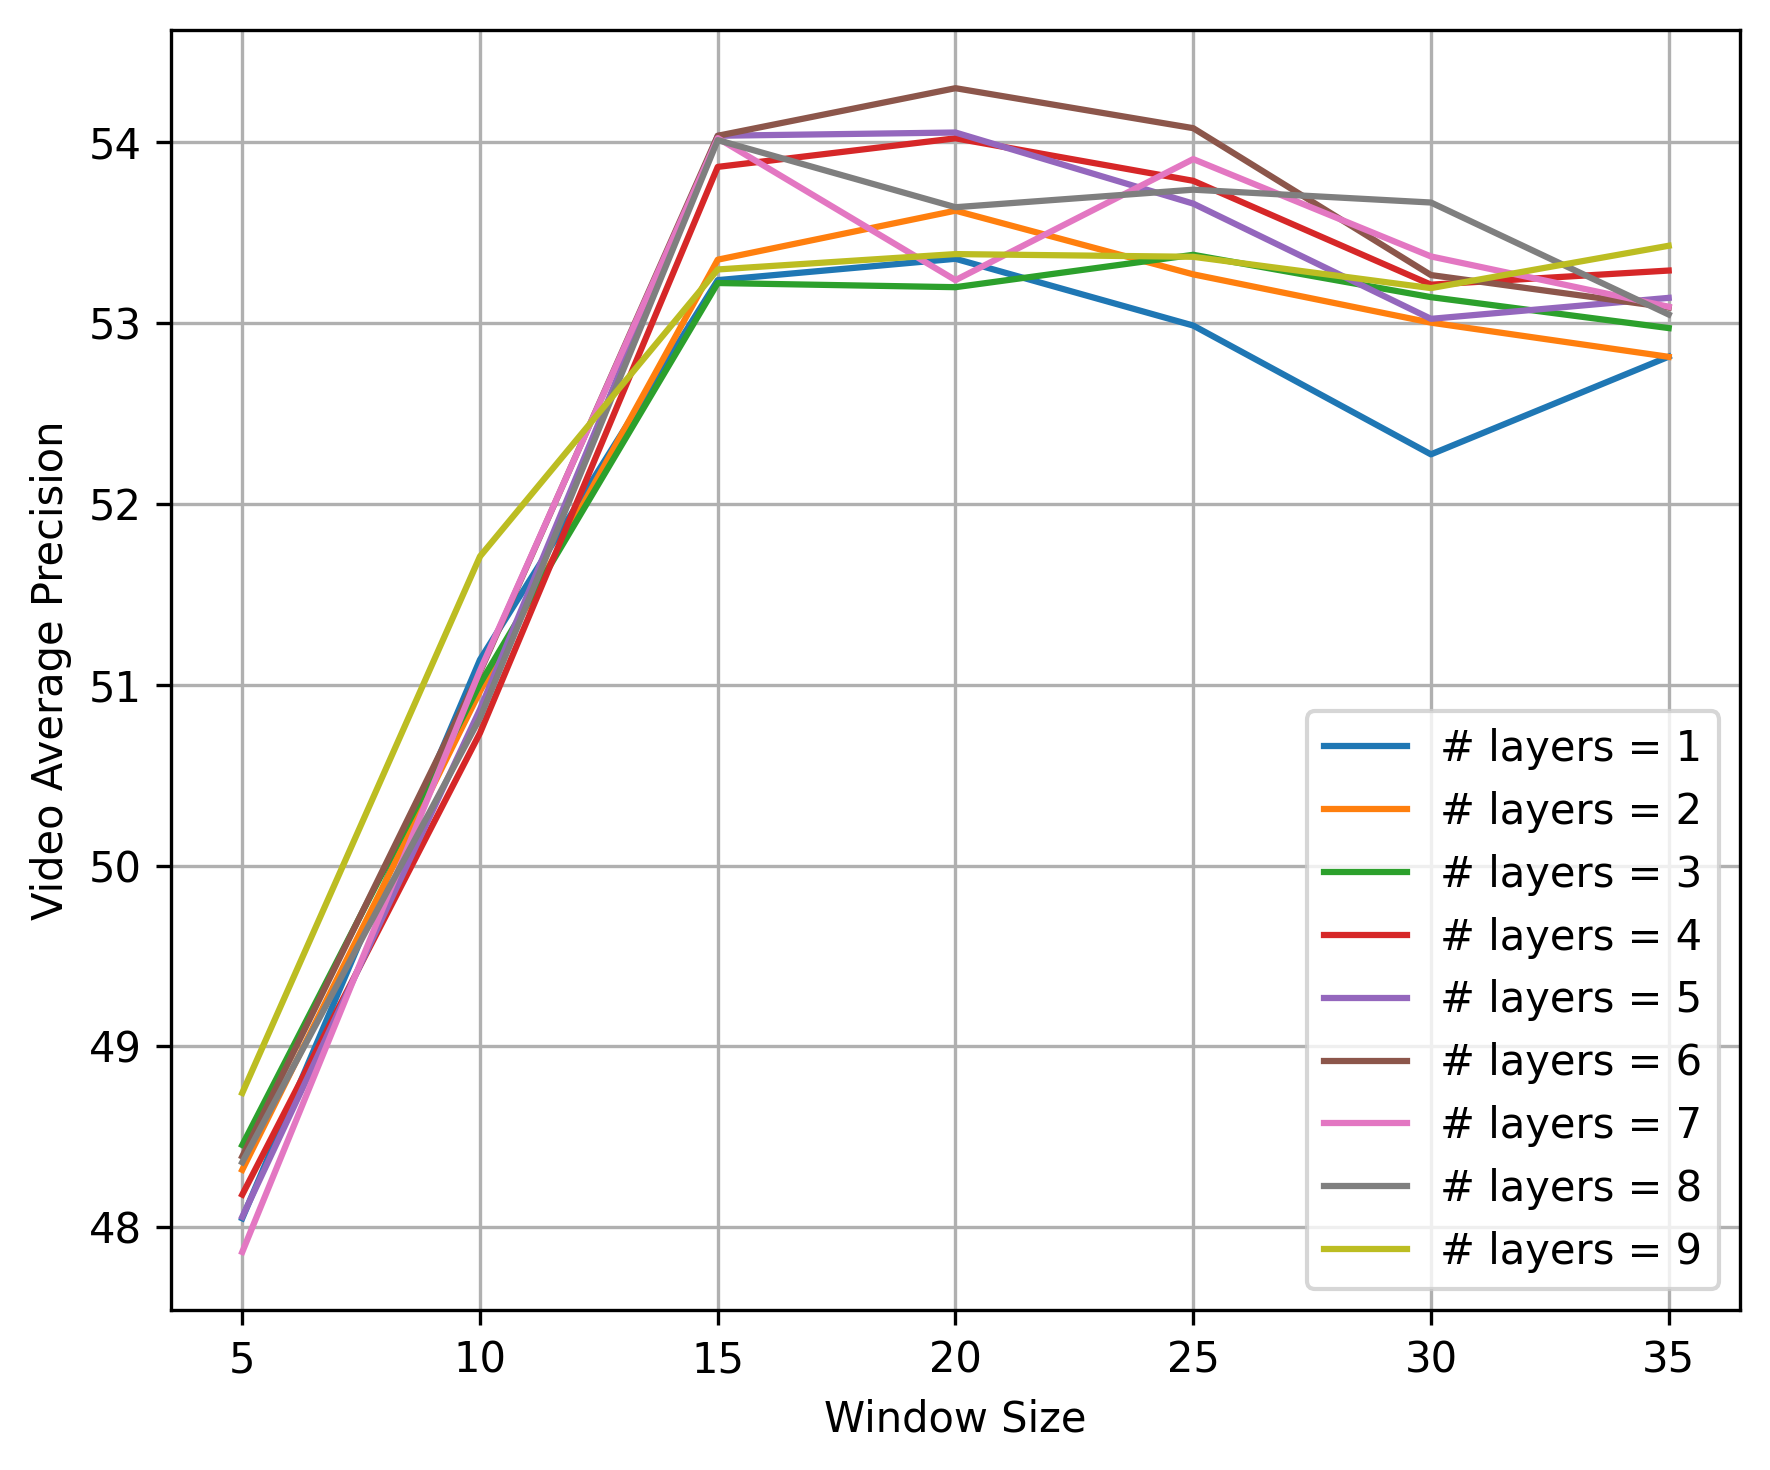

In [7]:
# plot window-size and grouping info...
data = pd.read_csv("wsdl2_stats_MOD.csv")
data['best_vid_val_AP'] = data['best_vid_val_AP'].apply(lambda x: eval(x.split('+/-')[0]))
data['best_dia_val_AP'] = data['best_dia_val_AP'].apply(lambda x: eval(x.split('+/-')[0]))
# data['best_val_AP'] = data['best_val_AP'].apply(lambda x: eval(x.split('+/-')[0]))
run_names = data['run_name']
num_layers = [1,2,3,4,5,6,7,8,9]
modality = 'vid'
# Plot for video/dialog scores
plt.figure(figsize=(6, 5), dpi=300)
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=400)
for l in num_layers:
    runs = data[data['run_name'].str.endswith(str(l))]
    runs = runs.assign(window_size=runs['run_name'].apply(lambda x: eval(x.split('|')[1][2:])))
    runs = runs.sort_values(by=['window_size'])
    # ax[0].plot(ws, runs['best_vid_val_AP'], label = f'# layers = {l}')
    # ax[1].plot(ws, runs['best_dia_val_AP'], label = f'# layers = {l}')
    plt.plot(runs['window_size'], runs[f'best_{modality}_val_AP'], label = f'# layers = {l}')
    # ax[0].set_xlabel("Window Size"); ax[1].set_xlabel("Window Size")
    # ax[0].set_ylabel("Video Average Precision"); ax[1].set_ylabel("Dialog Average Precision")
    # ax[0].grid(); ax[1].grid()
    # ax[0].legend(loc='upper right'); ax[1].legend(loc='upper right')
plt.legend(loc='lower right'); plt.grid()
name = "Video" if modality == 'vid' else "Dialog"
plt.xlabel("Window Size"); plt.ylabel(f"{name} Average Precision")
plt.tight_layout()
plt.savefig(f"../plots/window_layer_{modality}.pdf", bbox_inches='tight')
plt.show()
# fig.tight_layout()
# dec_1_vid = [46.2, 47.6, 50.0, 47.9, 46.8]
# dec_1_dia = [39.2, 41.8, 44.3, 42.1, 42.2]

# dec_2_vid = [46.4, 48.01, 51.1, 47.7, 47.8]
# dec_2_dia = [39.5, 42.3, 44.9, 41.3, 41.5]

# dec_3_vid = [45.7, 48.2, 49.4, 48.9, 48.9]
# dec_3_dia = [38.6, 41.6, 43.6, 42.7, 42.01]

# dec_4_vid = [45.9, 49.1, 48.6, 46.3, 47.4]
# dec_4_dia = [39.7, 43.1, 43.01, 40.9, 41.4]

# dec_5_vid = [46.7, 48.2, 48.3, 48.1, 47.9]
# dec_5_dia = [40.0, 42.9, 42.8, 41.9, 41.4]

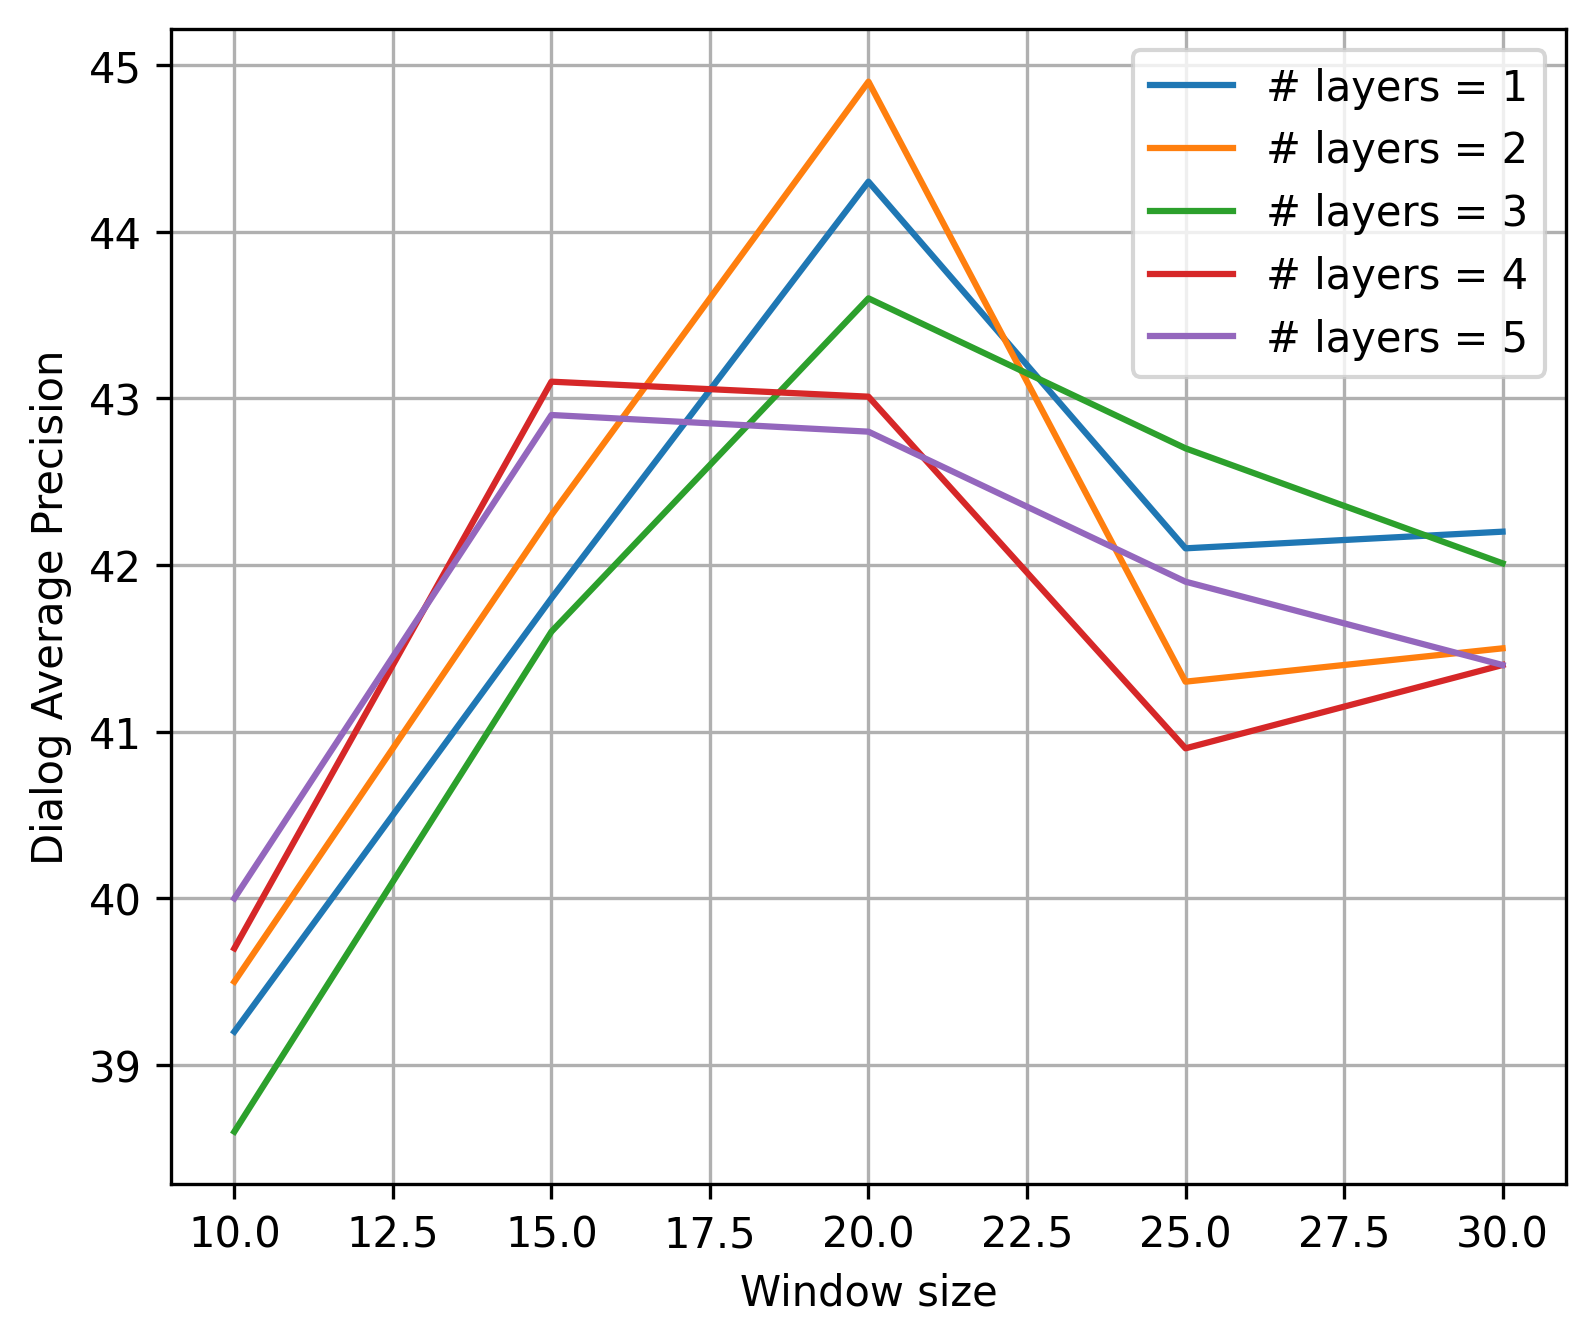

In [58]:
# fig = plt.figure(figsize=(6,5), dpi=300)
# plt.plot(window_sizes, dec_1_dia, label='# layers = 1')
# plt.plot(window_sizes, dec_2_dia, label='# layers = 2')
# plt.plot(window_sizes, dec_3_dia, label='# layers = 3')
# plt.plot(window_sizes, dec_4_dia, label='# layers = 4')
# plt.plot(window_sizes, dec_5_dia, label='# layers = 5')
# plt.xlabel("Window size")
# plt.ylabel("Dialog Average Precision")
# # plt.legend(loc = 'upper right', bbox_to_anchor=(1, 1.1), ncol=5)
# plt.legend()
# plt.grid()
# # plt.title("Dialog only")
# plt.savefig("../plots/window_layer_dia.pdf", bbox_inches='tight')
# plt.show()

## **Stitch Intervals**

In [10]:
def get_intervals_from_labels(vid_labels_from_model, series='24', season='S07', episode='E22'):
    
    def stitch_intervals(smooth_idx):
        # get smooth labels intervals ...
        i, j = 0, 1
        smooth_intervals = []
        while j < len(smooth_idx):
            if smooth_idx[j] - smooth_idx[i] == 1:
                if len(smooth_intervals):
                    smooth_intervals[-1][1] = shot_obj[smooth_idx[j]].time[1]
                else:
                    smooth_intervals.append([shot_obj[smooth_idx[i]].time[0], shot_obj[smooth_idx[j]].time[1]])
            else:
                if len(smooth_intervals):
                    smooth_intervals.append(list(shot_obj[smooth_idx[j]].time))
                else:
                    smooth_intervals += [list(shot_obj[smooth_idx[i]].time), list(shot_obj[smooth_idx[j]].time)]
            i += 1
            j += 1
        lst_intervals = [list(map(time2secs, l)) for l in smooth_intervals]

        return {'beg':[ele[0] for ele in lst_intervals], 'end':[ele[1] for ele in lst_intervals]}
    
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")

    next_ep = "E%02d"%(int(episode[-2:]) + 1)

    vid_thresh = 0.75
    vid_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/SL.pkl")
    vid_smooth_idx = np.argwhere(vid_labels[episode] > vid_thresh).squeeze()
    vid_smooth_idx_from_model = np.argwhere(vid_labels_from_model > 0).squeeze()
    
    vid_smooth_intervals = stitch_intervals(vid_smooth_idx)
    vid_smooth_intervals_from_model = stitch_intervals(vid_smooth_idx_from_model)
    
    return vid_smooth_intervals, vid_smooth_intervals_from_model 

    

In [11]:
# labels for S06E20:
ls06e20 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

ls06e22 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

ls07e22 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
vid_intervals1, model_intervals1 = get_intervals_from_labels(ls06e20, series='24', season='S06', episode='E20')
vid_intervals2, model_intervals2 = get_intervals_from_labels(ls06e22, series='24', season='S06', episode='E22')
vid_intervals3, model_intervals3 = get_intervals_from_labels(ls07e22, series='24', season='S07', episode='E22')

In [13]:
print(vid_intervals1)
print(model_intervals1)

{'beg': [451.43, 563.626, 850.537, 998.435, 1050.529, 1140.869, 1379.399, 1981.209, 2219.655, 2517.244], 'end': [463.484, 788.017, 989.259, 1005.609, 1106.251, 1258.445, 1604.332, 2057.702, 2334.144, 2582.101]}
{'beg': [563.626, 817.129, 844.865, 852.956, 925.946, 936.665, 1162.14, 1226.288, 1231.835, 1244.681, 1249.519, 1267.788, 1287.474, 1563.792, 2017.328, 2024.168, 2057.743, 2068.129, 2076.012, 2082.81, 2104.915, 2151.587, 2245.514, 2362.506, 2376.437, 2403.005, 2427.696, 2444.171, 2462.189, 2476.495, 2485.546, 2495.222, 2502.938], 'end': [675.654, 840.152, 850.496, 865.761, 932.494, 1005.609, 1223.785, 1228.415, 1242.804, 1247.142, 1261.698, 1285.222, 1290.352, 1629.482, 2018.579, 2038.724, 2058.786, 2069.255, 2079.348, 2084.979, 2114.133, 2171.774, 2334.144, 2372.641, 2385.779, 2405.132, 2431.325, 2446.799, 2471.115, 2481.291, 2492.302, 2500.519, 2582.101]}


In [14]:
print(vid_intervals2)
print(model_intervals2)

{'beg': [188.668, 282.72, 538.309, 685.915, 746.141, 803.324, 835.481, 1145.123, 1338.859, 1543.855, 1831.1, 1922.733, 2055.157], 'end': [195.258, 311.207, 674.82, 708.562, 766.078, 816.295, 878.44, 1158.345, 1361.172, 1611.381, 1889.909, 1933.911, 2561.371]}
{'beg': [373.269, 398.878, 411.682, 427.99, 439.293, 472.785, 896.542, 914.309, 922.109, 938.0, 952.556, 968.113, 1062.082, 1108.587, 1429.032, 1435.497, 1636.197, 2088.065, 2154.59, 2337.565], 'end': [376.689, 401.172, 418.522, 430.993, 443.673, 490.511, 911.181, 919.356, 927.322, 950.679, 959.605, 973.869, 1064.751, 1122.351, 1430.45, 1437.707, 1720.615, 2111.881, 2334.019, 2561.371]}


In [15]:
print(vid_intervals3)
print(model_intervals3)

{'beg': [797.484, 1137.824, 1211.314, 1303.114, 1605.25, 1667.604, 1730.208, 1794.814, 2370.806, 2410.262, 2470.656], 'end': [1012.95, 1193.505, 1218.488, 1385.447, 1617.387, 1715.985, 1788.224, 1829.766, 2383.068, 2453.931, 2541.81]}
{'beg': [479.25, 499.937, 565.252, 582.269, 601.08, 607.503, 779.925, 987.549, 1005.15, 1012.991, 1190.711, 1292.771, 1863.424, 1883.653, 1891.327, 2088.566, 2093.571, 2422.483], 'end': [488.884, 507.653, 580.559, 596.117, 604.083, 609.255, 950.596, 996.85, 1008.445, 1020.541, 1246.308, 1364.217, 1873.101, 1885.405, 1968.321, 2090.526, 2200.136, 2541.81]}


## Compute similarity between **dialog of high scoring shots vs. actual recap dialog**

##### Time plot for Video segments from smooth labels, Video GT segments, Dialog from Video, Dialog GT

In [190]:
class GetTimePlot:
    def __init__(self, vid_smooth_interval, vid_gt_interval, dia_from_vid_interval, dia_gt_interval, annotation_name="MyAnnot"):
        self.vid_smooth_interval = vid_smooth_interval
        self.vid_gt_interval = vid_gt_interval
        self.dia_from_vid_interval = dia_from_vid_interval
        self.dia_gt_interval = dia_gt_interval
        self.annotation_name = annotation_name
    
    def seg2timeline(self, interval, name=None):
        return Timeline(segments=[Segment(m, n) for m,n in interval], uri=name)
        
    def segments2lst(self, interval, name=None):
        return [Segment(m, n) for m,n in interval]
    
    def all2annote(self):
        vs = self.segments2lst(self.vid_smooth_interval)
        vg = self.segments2lst(self.vid_gt_interval)
        dv = self.segments2lst(self.dia_from_vid_interval)
        dg = self.segments2lst(self.dia_gt_interval)
        annot = Annotation(uri=self.annotation_name, modality="vid+dia")
        for ele in vs:
            annot[ele, 0] = 'Video: Smoothed'    # track name = 1
        for ele in vg:
            annot[ele, 1] = 'Video: GT'          # track name = 2
        for ele in dv:
            annot[ele, 2] = 'Dialog: From Video' # track name = 3
        for ele in dg:
            annot[ele, 3] = 'Dialog: GT'         # track name = 4
        return annot
    
    def plot_timeline(self,
                      episode_name: str,
                      save: bool,
                      save_path:str,
                      plot_title = "Segment Intervals",
                      labels: List[str] = ['Video GT Times', 'Video Smoothed Times',
                                           'Dialog GT Times', 'Dialog Times from Video'],
                      lineheight:int = 0.5,
                      linewidth:int = 4,
                      color:Union[str, List[str]] = ['b','g','r','c'],
                      xtitle:str = 'Time (in seconds)',
                      figsize:Tuple = (20,2)
                     )->None:
        """
        Given chunks/segments with starting and ending time-stamp,
        plot them in entire full-support. (Probably to have an idea of
        where these chunks (of different modalities) are located).
        """
        idx = 0
        fig = plt.figure(figsize=figsize)
        legend_done = False
        if self.vid_gt_interval is not None:
            for ele in self.vid_gt_interval:
                if not legend_done:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx], label=labels[idx])
                    legend_done = True
                else:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx])
            idx += 1
            legend_done = False
        if self.vid_smooth_interval is not None:
            for ele in self.vid_smooth_interval:
                if not legend_done:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx], label=labels[idx])
                    legend_done = True
                else:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx])
            idx += 1
            legend_done = False
        if self.dia_gt_interval is not None:
            for ele in self.dia_gt_interval:
                if not legend_done:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx], label=labels[idx])
                    legend_done = True
                else:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx])
            idx += 1
            legend_done = False
        if self.dia_from_vid_interval is not None:
            for ele in self.dia_from_vid_interval:
                if not legend_done:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx], label=labels[idx])
                    legend_done = True
                else:
                    plt.plot(ele, [idx+lineheight]*2, linewidth=linewidth, color=color[idx])
            idx += 1
        plt.xlabel(xtitle)
        plt.yticks([])
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1.25), ncol=4)
        plt.title(f"{plot_title} for {episode_name}", loc='left')
        plt.grid()
        if save:
            plt.savefig(save_path)
        plt.show()

**Test above functionalities...**

In [183]:
####### We'll use pyannote.core library to print these time segments
vid_interval_test = [[24, 150], [180, 190], [290, 340], [500, 515], [590, 610], [810, 840]]
dia_gt_time_test = [[22, 40], [290, 295], [510, 520], [590, 600], [820, 830]]
vid_gt_time_test = [[27, 37], [141, 147], [180, 188], [293, 299], [500, 510], [595, 605], [607, 612], [812, 815], [820, 824]]
dia_time_from_shots_test = [[25, 30], [70, 72], [140, 145], [295, 297], [315, 325], [505, 507], [595, 597], [812, 820], [835, 838]]

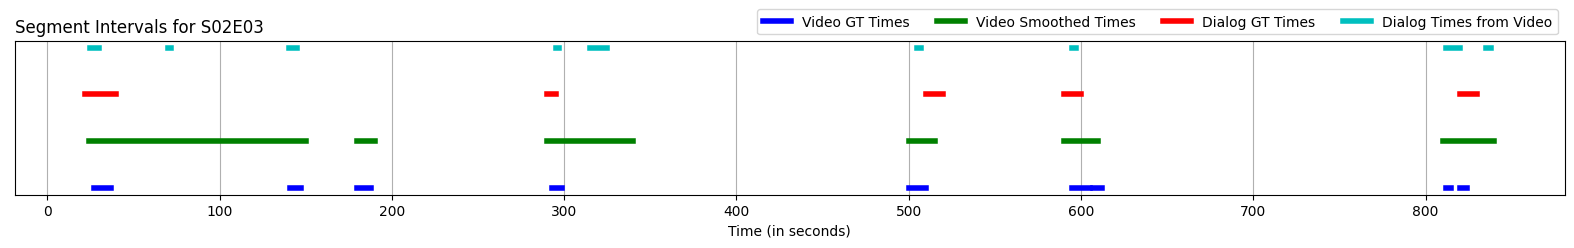

In [185]:
tplot = GetTimePlot(vid_gt_interval=vid_gt_time_test,
                    vid_smooth_interval=vid_interval_test,
                    dia_gt_interval=dia_gt_time_test,
                    dia_from_vid_interval=dia_time_from_shots_test)

tplot.plot_timeline(episode_name='S02E03')

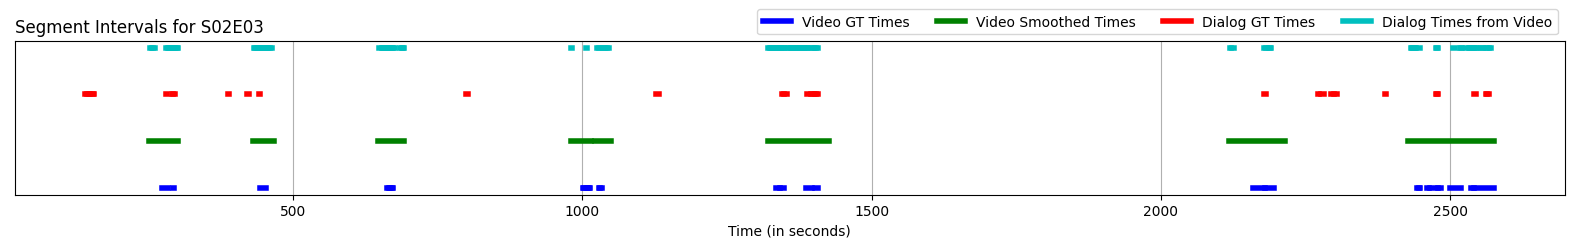

In [186]:
_, vid_gt_time1, _, vid_smooth_intervals1, _, dia_gt_time1, _, dia_time_from_shots1 = estimate_overlap(season='S02',
                                                                                                    series=24,
                                                                                                    episode='E03')
tplot1 = GetTimePlot(vid_gt_interval=vid_gt_time1,
                    vid_smooth_interval=vid_smooth_intervals1,
                    dia_gt_interval=dia_gt_time1,
                    dia_from_vid_interval=dia_time_from_shots1)
tplot1.plot_timeline(episode_name='S02E03')

In [16]:
def estimate_how_many_diaGT_in_vidSL(series, season, episode):
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")

    next_ep = "E%02d"%(int(episode[-2:]) + 1)
    vid_gt = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/GT.pkl")
    vid_gt_idx = np.argwhere(vid_gt[episode] > 0).squeeze()
    vid_gt_time = [list(map(time2secs, shot_obj[t].time)) for t in vid_gt_idx]

    vid_thresh = 0.75
    vid_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/SL.pkl")
    vid_smooth_idx = np.argwhere(vid_labels[episode] > vid_thresh).squeeze()

    # get smooth labels intervals ...
    i, j = 0, 1
    vid_smooth_intervals = []
    while j < len(vid_smooth_idx):
        if vid_smooth_idx[j] - vid_smooth_idx[i] == 1:
            if len(vid_smooth_intervals):
                vid_smooth_intervals[-1][1] = shot_obj[vid_smooth_idx[j]].time[1]
            else:
                vid_smooth_intervals.append([shot_obj[vid_smooth_idx[i]].time[0], shot_obj[vid_smooth_idx[j]].time[1]])
        else:
            if len(vid_smooth_intervals):
                vid_smooth_intervals.append(list(shot_obj[vid_smooth_idx[j]].time))
            else:
                vid_smooth_intervals += [list(shot_obj[vid_smooth_idx[i]].time), list(shot_obj[vid_smooth_idx[j]].time)]
        i += 1
        j += 1

    vid_smooth_intervals = [list(map(time2secs, l)) for l in vid_smooth_intervals]

    # Select actual ground-truth dialogs
    dia_file = get_file_name(fr"../data/{series}/{season}/{season}{episode}/encodings/dia_encodings/newSrtObj_*.pkl")
    start = int(dia_file.stem.split("_")[-1]) + 1
    dia_obj = load_pickle(dia_file)[start:]

    dia_thresh = 0.5
    dia_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/dia_scores/recapVepisode/SL.pkl")
    dia_gt_idx = np.argwhere(dia_labels[episode][start:] > dia_thresh).squeeze()
    dia_gt_time = [[time2secs(dia_obj[l].start.to_time()), time2secs(dia_obj[l].end.to_time())] for l in dia_gt_idx]
    assert len(dia_gt_idx) == len(dia_gt_time), f"Length of dia_gt_idx ({len(dia_gt_idx)}) should be same as dia_gt_time ({len(dia_gt_time)})"

    # Select dialogs falling in the shot-interval
    k = 0
    cnt = 0
    for ele in vid_smooth_intervals:
        l = 0
        for dia_ele in dia_gt_time[k:]:
            mid_time = np.mean(dia_ele)
            if ele[0] <= mid_time <= ele[1]:
                cnt += 1
                l += 1
            elif mid_time < ele[0]:
                l += 1
                continue
            else:
                break
        k += l
    # postive counts
    falling_in_vid_interval = cnt*100/len(dia_gt_time)
    return falling_in_vid_interval

In [19]:
# Extract such stats in accumulated for all episode
series_name = '24'
seasons = ['S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09']
total_episodes = [24, 24, 24, 24, 24, 24, 24, 12]
membership_lst  = []
for season, eps_cnt in zip(seasons, total_episodes):
    for k in range(1,eps_cnt):
        ep = "E%02d" % k
        membership_lst.append(estimate_how_many_diaGT_in_vidSL(series_name, season, ep))

In [21]:
print(f"{np.mean(membership_lst)}+-{np.std(membership_lst)}% of Dialogs fall in Smoothed Video interval.")

87.81520147997803+-9.374958747796711% of Dialogs fall in Smoothed Video interval.


In [171]:
def estimate_overlap(series, season, episode):
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")

    next_ep = "E%02d"%(int(episode[-2:]) + 1)
    vid_gt = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/GT.pkl")
    vid_gt_idx = np.argwhere(vid_gt[episode] > 0).squeeze()
    vid_gt_time = [list(map(time2secs, shot_obj[t].time)) for t in vid_gt_idx]

    vid_thresh = 0.75
    vid_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/SL.pkl")
    vid_smooth_idx = np.argwhere(vid_labels[episode] > vid_thresh).squeeze()

    # get smooth labels intervals ...
    i, j = 0, 1
    vid_smooth_intervals = []
    while j < len(vid_smooth_idx):
        if vid_smooth_idx[j] - vid_smooth_idx[i] == 1:
            if len(vid_smooth_intervals):
                vid_smooth_intervals[-1][1] = shot_obj[vid_smooth_idx[j]].time[1]
            else:
                vid_smooth_intervals.append([shot_obj[vid_smooth_idx[i]].time[0], shot_obj[vid_smooth_idx[j]].time[1]])
        else:
            if len(vid_smooth_intervals):
                vid_smooth_intervals.append(list(shot_obj[vid_smooth_idx[j]].time))
            else:
                vid_smooth_intervals += [list(shot_obj[vid_smooth_idx[i]].time), list(shot_obj[vid_smooth_idx[j]].time)]
        i += 1
        j += 1

    vid_smooth_intervals = [list(map(time2secs, l)) for l in vid_smooth_intervals]

    # Select actual ground-truth dialogs
    dia_file = get_file_name(fr"../data/{series}/{season}/{season}{episode}/encodings/dia_encodings/newSrtObj_*.pkl")
    start = int(dia_file.stem.split("_")[-1]) + 1
    dia_obj = load_pickle(dia_file)[start:]

    dia_thresh = 0.5
    dia_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/dia_scores/recapVepisode/SL.pkl")
    dia_gt_idx = np.argwhere(dia_labels[episode][start:] > dia_thresh).squeeze()
    dia_gt_time = [[time2secs(dia_obj[l].start.to_time()), time2secs(dia_obj[l].end.to_time())] for l in dia_gt_idx]
    assert len(dia_gt_idx) == len(dia_gt_time), f"Length of dia_gt_idx ({len(dia_gt_idx)}) should be same as dia_gt_time ({len(dia_gt_time)})"

    # Select dialogs falling in the shot-interval
    dia_time_from_shots = []
    dia_idx_from_shots = []
    k = 0
    for ele in vid_smooth_intervals:
        l = 0
        for dia_ele in dia_obj[k:]:
            mid_time = np.mean([time2secs(dia_ele.start.to_time()), time2secs(dia_ele.end.to_time())])
            if ele[0] <= mid_time <= ele[1]:
                dia_time_from_shots.append([time2secs(dia_ele.start.to_time()), time2secs(dia_ele.end.to_time())])
                dia_idx_from_shots.append(k+l)
                l += 1
            elif mid_time < ele[0]:
                l += 1
                continue
            else:
                break
        k += l

    # check if both of the lengths are equal
    assert len(dia_time_from_shots) == len(dia_idx_from_shots), f"Lengths are different!"
    return vid_gt_idx, vid_gt_time, vid_smooth_idx, vid_smooth_intervals, dia_gt_idx, dia_gt_time, dia_idx_from_shots, dia_time_from_shots

In [194]:
## SAVE TO SOME FOLDER ALL THESE RESULTS...

# folder_path = Path("../data/24/segments_data")
# os.makedirs(folder_path, exist_ok=True)
# series=24
# season=['S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09']
# total_eps_count = [24, 24, 24, 24, 24, 24, 24, 12]
# for s, cnt in zip(season, total_eps_count):
#     season_dict = {"E%02d"%(i):None for i in range(1, cnt)}
#     for k in season_dict:
#         season_dict[k] = estimate_overlap(season=s, series=series, episode=k)
#     save_pickle(folder_path/f"{s}.pkl", season_dict)

# Test
# obj = load_pickle("../data/24/segments_data/S03.pkl")

In [11]:
_, vid_gt_time6, _, vid_smooth_intervals6, _, dia_gt_time6, _, dia_time_from_shots6 = estimate_overlap(season='S07',
                                                                                                  series=24,
                                                                                                  episode='E22')

In [17]:
tplot6 = GetTimePlot(vid_smooth_interval=vid_smooth_intervals6,
                    vid_gt_interval=vid_gt_time6,
                    dia_from_vid_interval=dia_time_from_shots6,
                    dia_gt_interval=dia_gt_time6)

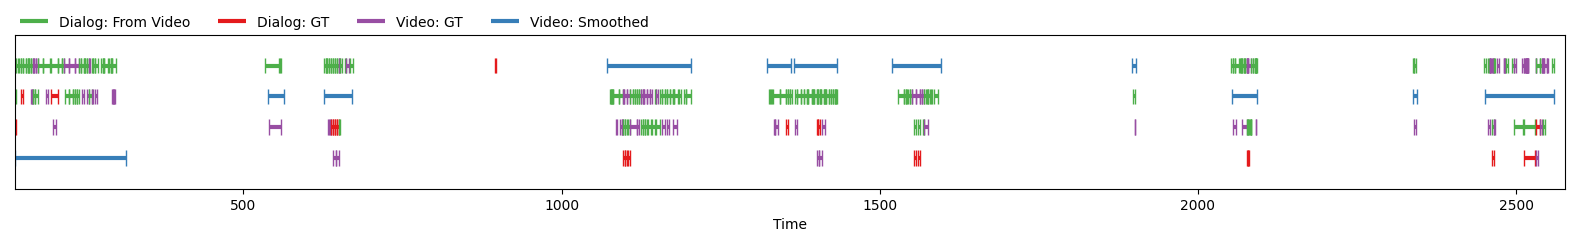

In [23]:
annot6 = tplot6.all2annote()
annot6

## Frequency plot for **Absolute Shot Index Difference** and **Absolute Shot's Starting Time Difference**:

In [4]:
recapShotWmultiShots = {}
global_index_diff = np.array([])
global_time_diff = np.array([])
binwidth = 2
time_binwidth = 5
fig1, ax1 = plt.subplots(nrows=12, ncols=2, figsize=(15, 40), dpi=300)
fig1.suptitle(f"Histogram of Shots Index Difference in all recap shots for S03 with Binwidth={binwidth}")
fig2, ax2 = plt.subplots(nrows=12, ncols=2, figsize=(15, 40), dpi=300)
fig2.suptitle(f"Histogram of Shots Time Difference (secs) in all recap shots for S03 with Binwidth={time_binwidth}")
for j, ep in enumerate(eps_names):
    # print(ep)
    # print("-"*50)
    prev_ep = "E%02d"%(int(ep[1:]) - 1)
    cnt = 0
    # ------------------------- construct shots dict with time ------------------------
    videvents = readVidEvents(Path(f"../data/24/S03/S03{prev_ep}/videvents/S03{prev_ep}.videvents"))
    shots_dict = {}
    for k, (_, i) in enumerate(videvents):
        shots_dict[k+1] = i
    shots_dict[0] = 0
    # ---------------------------------------------------------------------------------
    obj = load_pickle(f"../data/24/S03/S03{ep}/vid_scores/recapVepisode/shot_matching.pkl")
    ep_index_diff = np.array([])
    ep_time_diff = np.array([])
    for k, v in obj.items():
        if prev_ep in v:
            if len(v[prev_ep]) > 1:
                cnt += 1
                sorted_keys = np.asarray(sorted(v[prev_ep].keys()))
                time_arr = np.asarray([shots_dict[key] for key in sorted_keys])
                index_diff = sorted_keys[1:] - sorted_keys[:-1]
                time_diff = time_arr[1:] - time_arr[:-1]
                ep_index_diff = np.concatenate((ep_index_diff, index_diff))
                ep_time_diff = np.concatenate((ep_time_diff, time_diff))
                global_index_diff = np.concatenate((global_index_diff, index_diff))
                global_time_diff = np.concatenate((global_time_diff, time_diff))
    ax1[j//2, j%2].hist(ep_index_diff,
                bins=range(int(min(ep_index_diff)), int(max(ep_index_diff)) + binwidth, binwidth))
    ax1[j//2, j%2].set_title(ep)
    ax1[j//2, j%2].set_xticks(range(int(min(ep_index_diff)), int(max(ep_index_diff)) + binwidth, 10*binwidth))
    ax1[j//2, j%2].set_xticklabels(range(int(min(ep_index_diff)), int(max(ep_index_diff)) + binwidth, 10*binwidth), rotation=90)
    # ---------------------------------------------------------------------------------
    ax2[j//2, j%2].hist(ep_time_diff,
                bins=range(int(min(ep_time_diff)), int(max(ep_time_diff)) + time_binwidth, time_binwidth))
    ax2[j//2, j%2].set_title(ep)
    ax2[j//2, j%2].set_xticks(range(int(min(ep_time_diff)), int(max(ep_time_diff)) + time_binwidth, 10*time_binwidth))
    ax2[j//2, j%2].set_xticklabels(range(int(min(ep_time_diff)), int(max(ep_time_diff)) + time_binwidth, 10*time_binwidth), rotation=90)
    recapShotWmultiShots[ep] = f"{cnt}/{len(obj)}"
# ---------------------------------------------------------------------------------
ax1[11, 1].hist(global_index_diff, bins=range(int(min(global_index_diff)), int(max(global_index_diff)) + binwidth, binwidth))
ax1[11, 1].set_title("S03")
ax1[11, 1].set_xticks(range(int(min(global_index_diff)), int(max(global_index_diff)) + binwidth, 10*binwidth))
ax1[11, 1].set_xticklabels(range(int(min(global_index_diff)), int(max(global_index_diff)) + binwidth, 10*binwidth), rotation=90)
#---------------------------------------------------------------------------------
ax2[11, 1].hist(global_time_diff, bins=range(int(min(global_time_diff)), int(max(global_time_diff)) + time_binwidth, time_binwidth))
ax2[11, 1].set_title("S03")
ax2[11, 1].set_xticks(range(int(min(global_time_diff)), int(max(global_time_diff)) + time_binwidth, 10*time_binwidth))
ax2[11, 1].set_xticklabels(range(int(min(global_time_diff)), int(max(global_time_diff)) + time_binwidth, 10*time_binwidth), rotation=90)
#---------------------------------------------------------------------------------
fig1.tight_layout(rect=[0, 0, 1, 0.95])
fig2.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**The many shots in RECAP out of denominator have multiple reference shots.**

In [5]:
recapShotWmultiShots

{'E02': '16/52',
 'E03': '16/46',
 'E04': '13/56',
 'E05': '13/53',
 'E06': '15/45',
 'E07': '13/44',
 'E08': '15/49',
 'E09': '15/42',
 'E10': '18/45',
 'E11': '9/58',
 'E12': '15/49',
 'E13': '15/57',
 'E14': '8/37',
 'E15': '12/55',
 'E16': '6/38',
 'E17': '5/43',
 'E18': '20/62',
 'E19': '14/32',
 'E20': '9/44',
 'E21': '9/45',
 'E22': '15/39',
 'E23': '16/42',
 'E24': '9/58'}

**Frequency plot for shot duration so as to decide what `fps` can able to cover most of the shot.**

*Note: First 2 secs of every episode is ignored as RECAP material and hence shorter duration shots which may cause a `bias`*

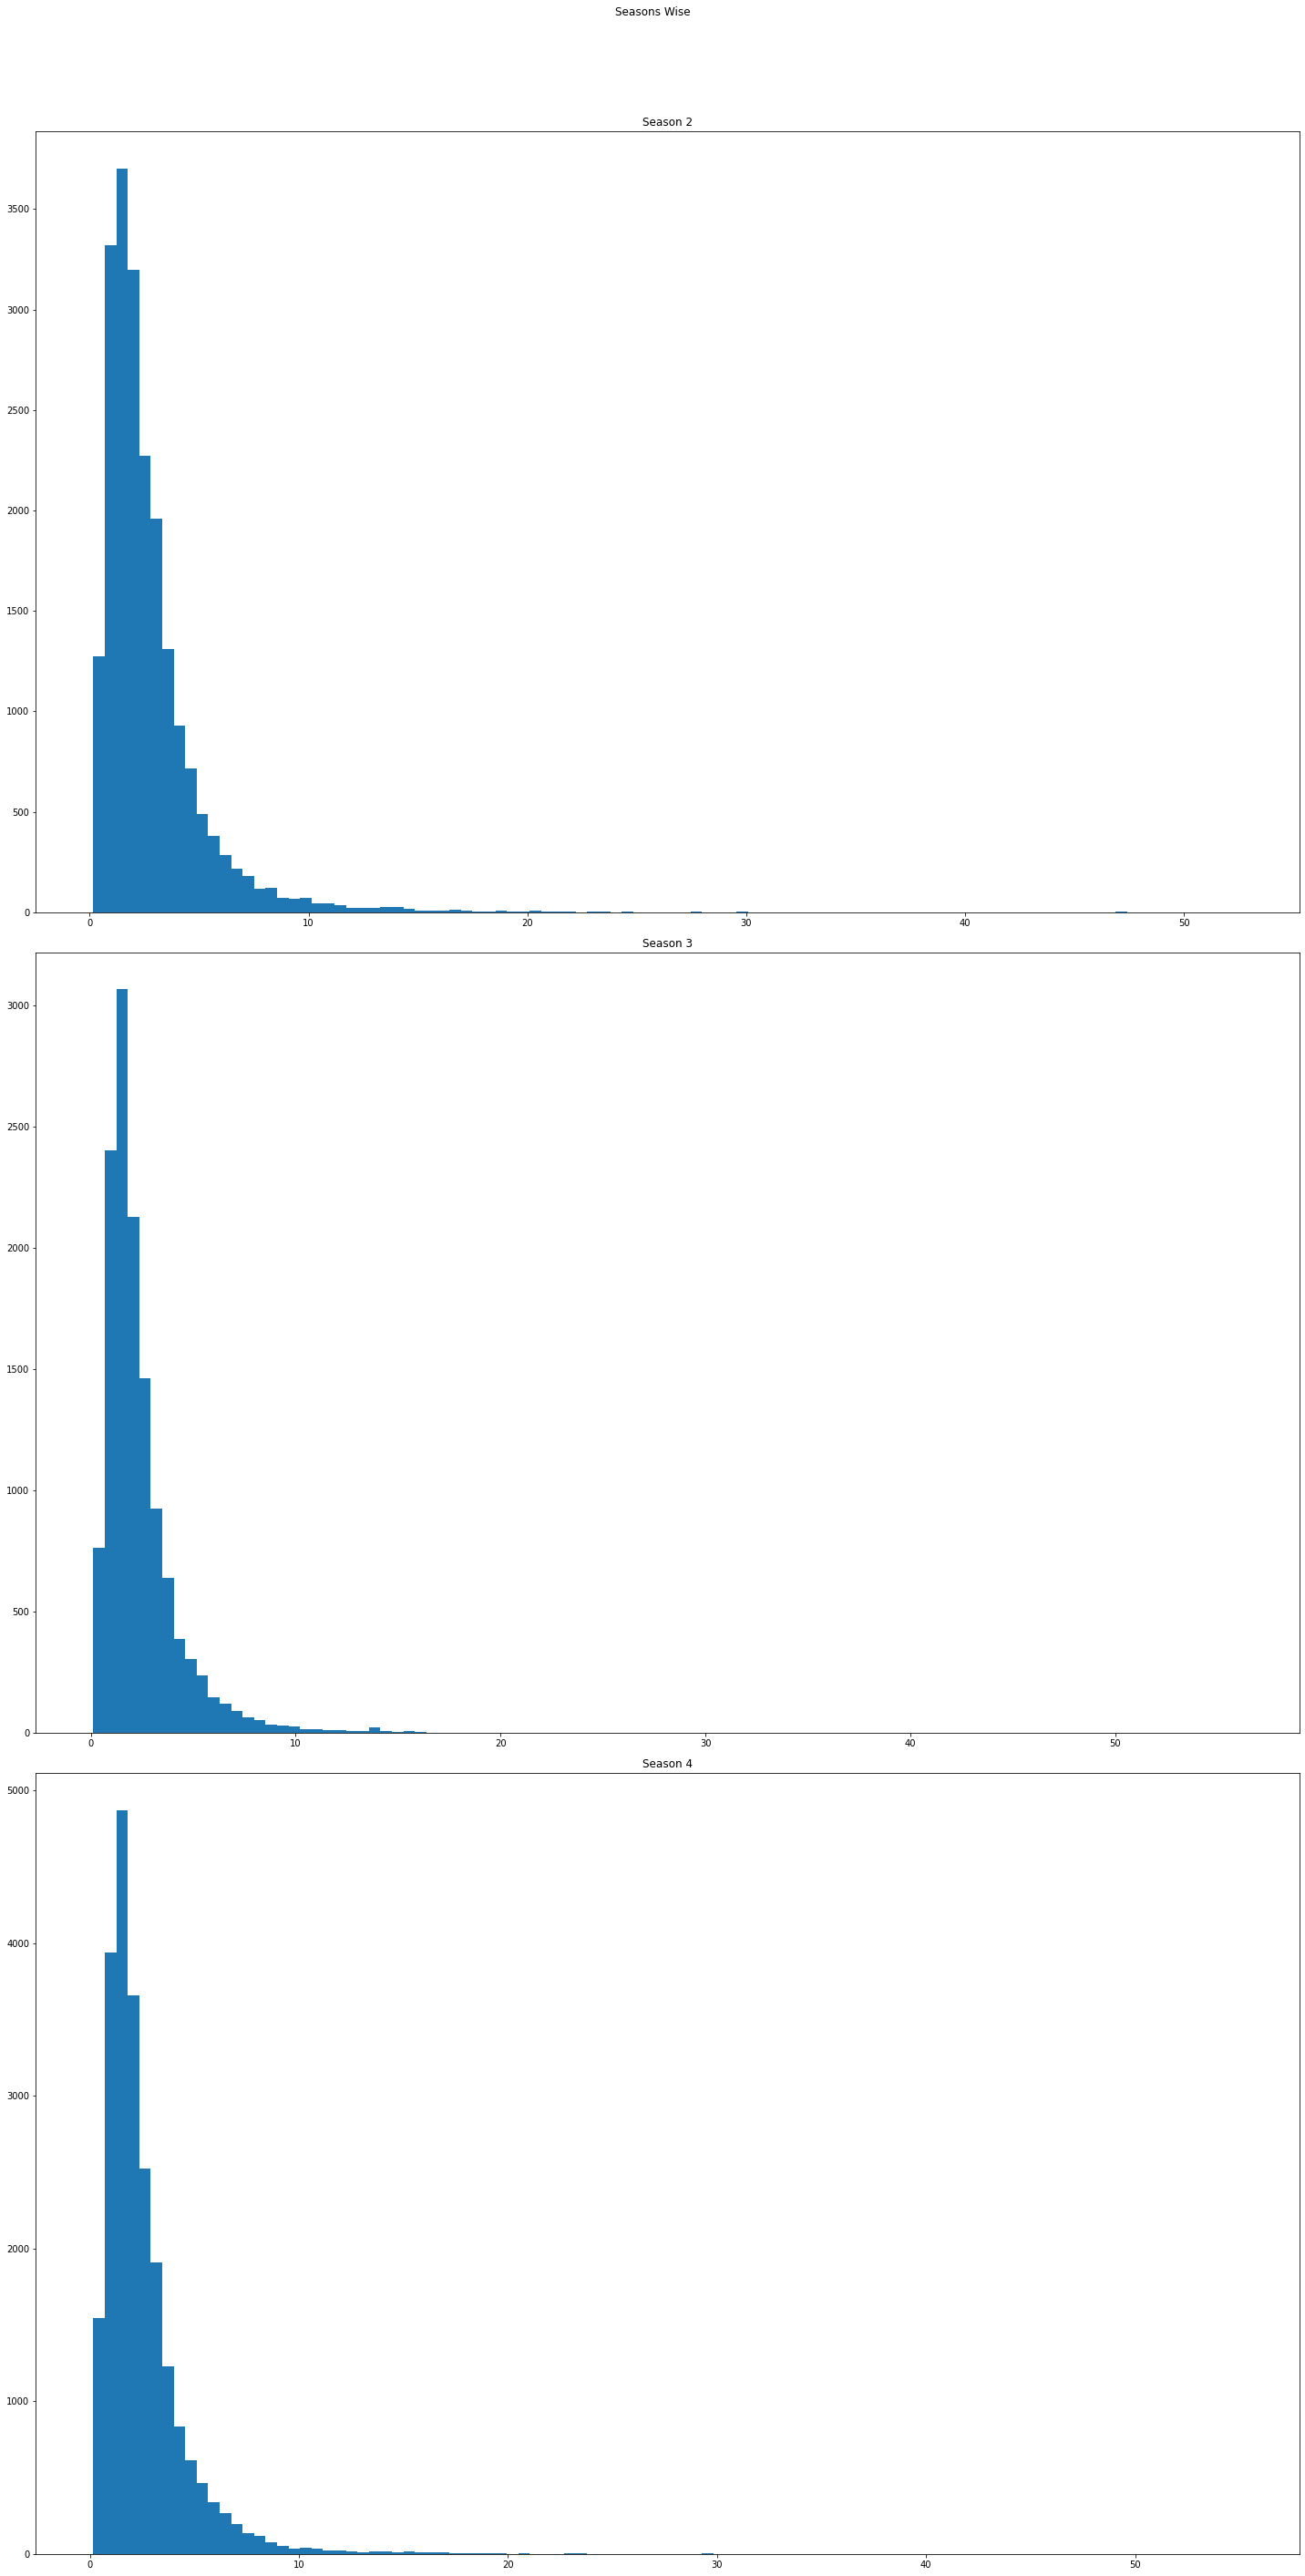

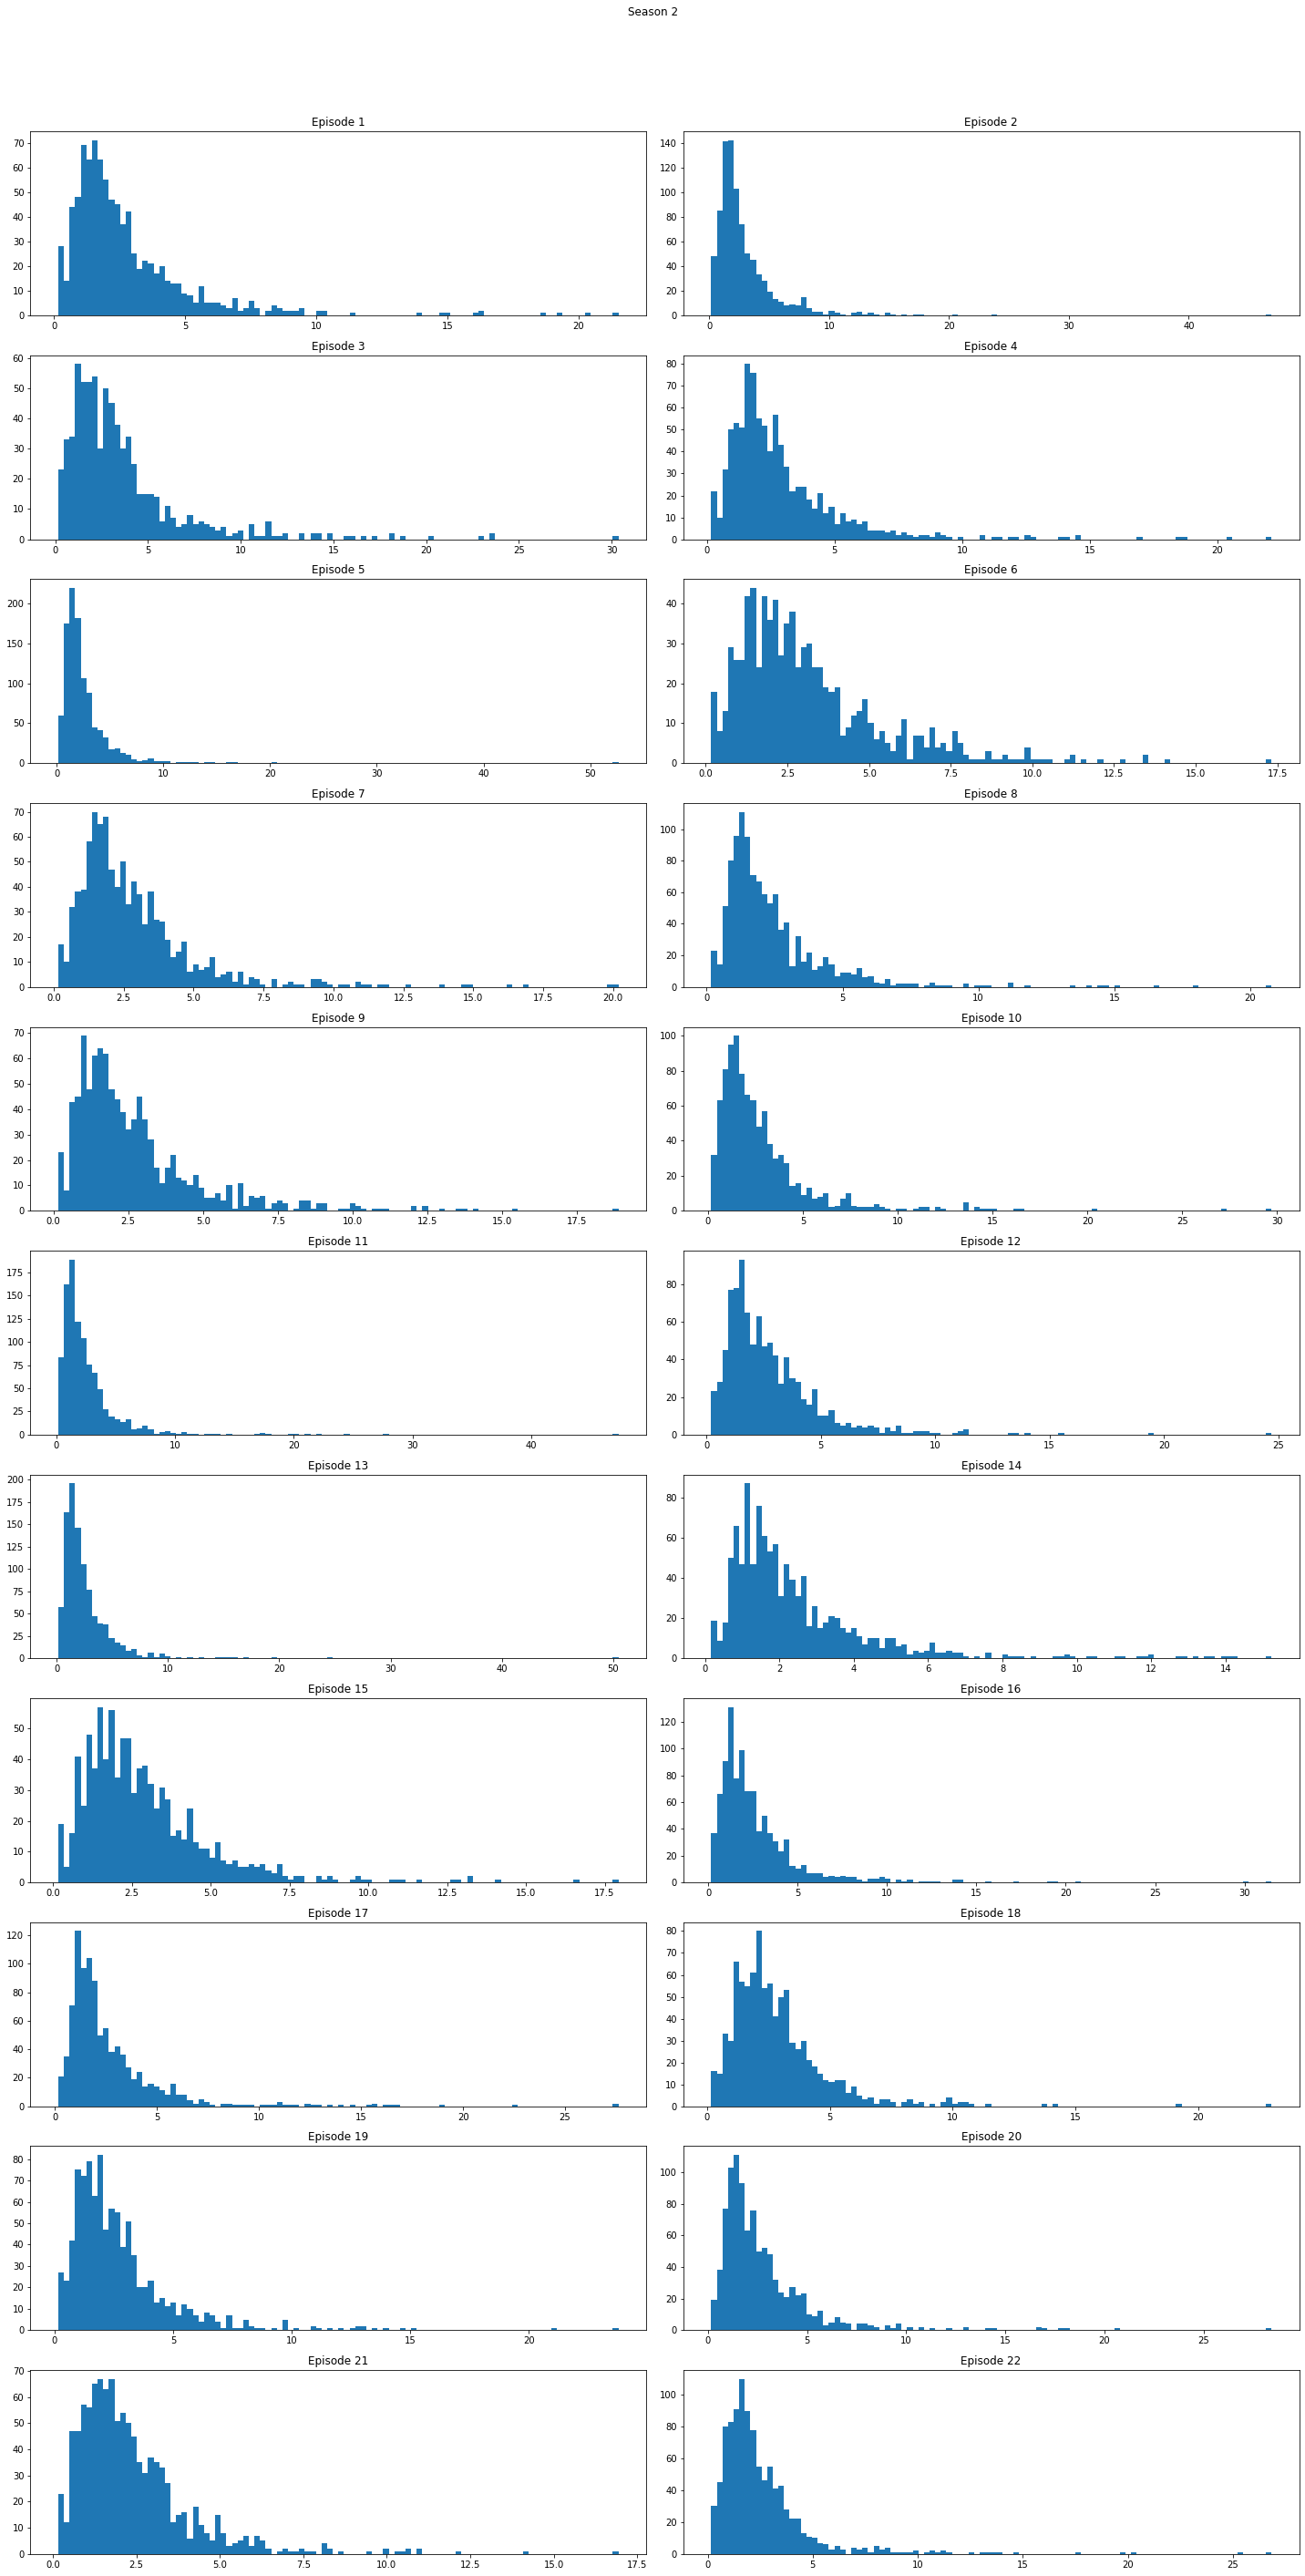

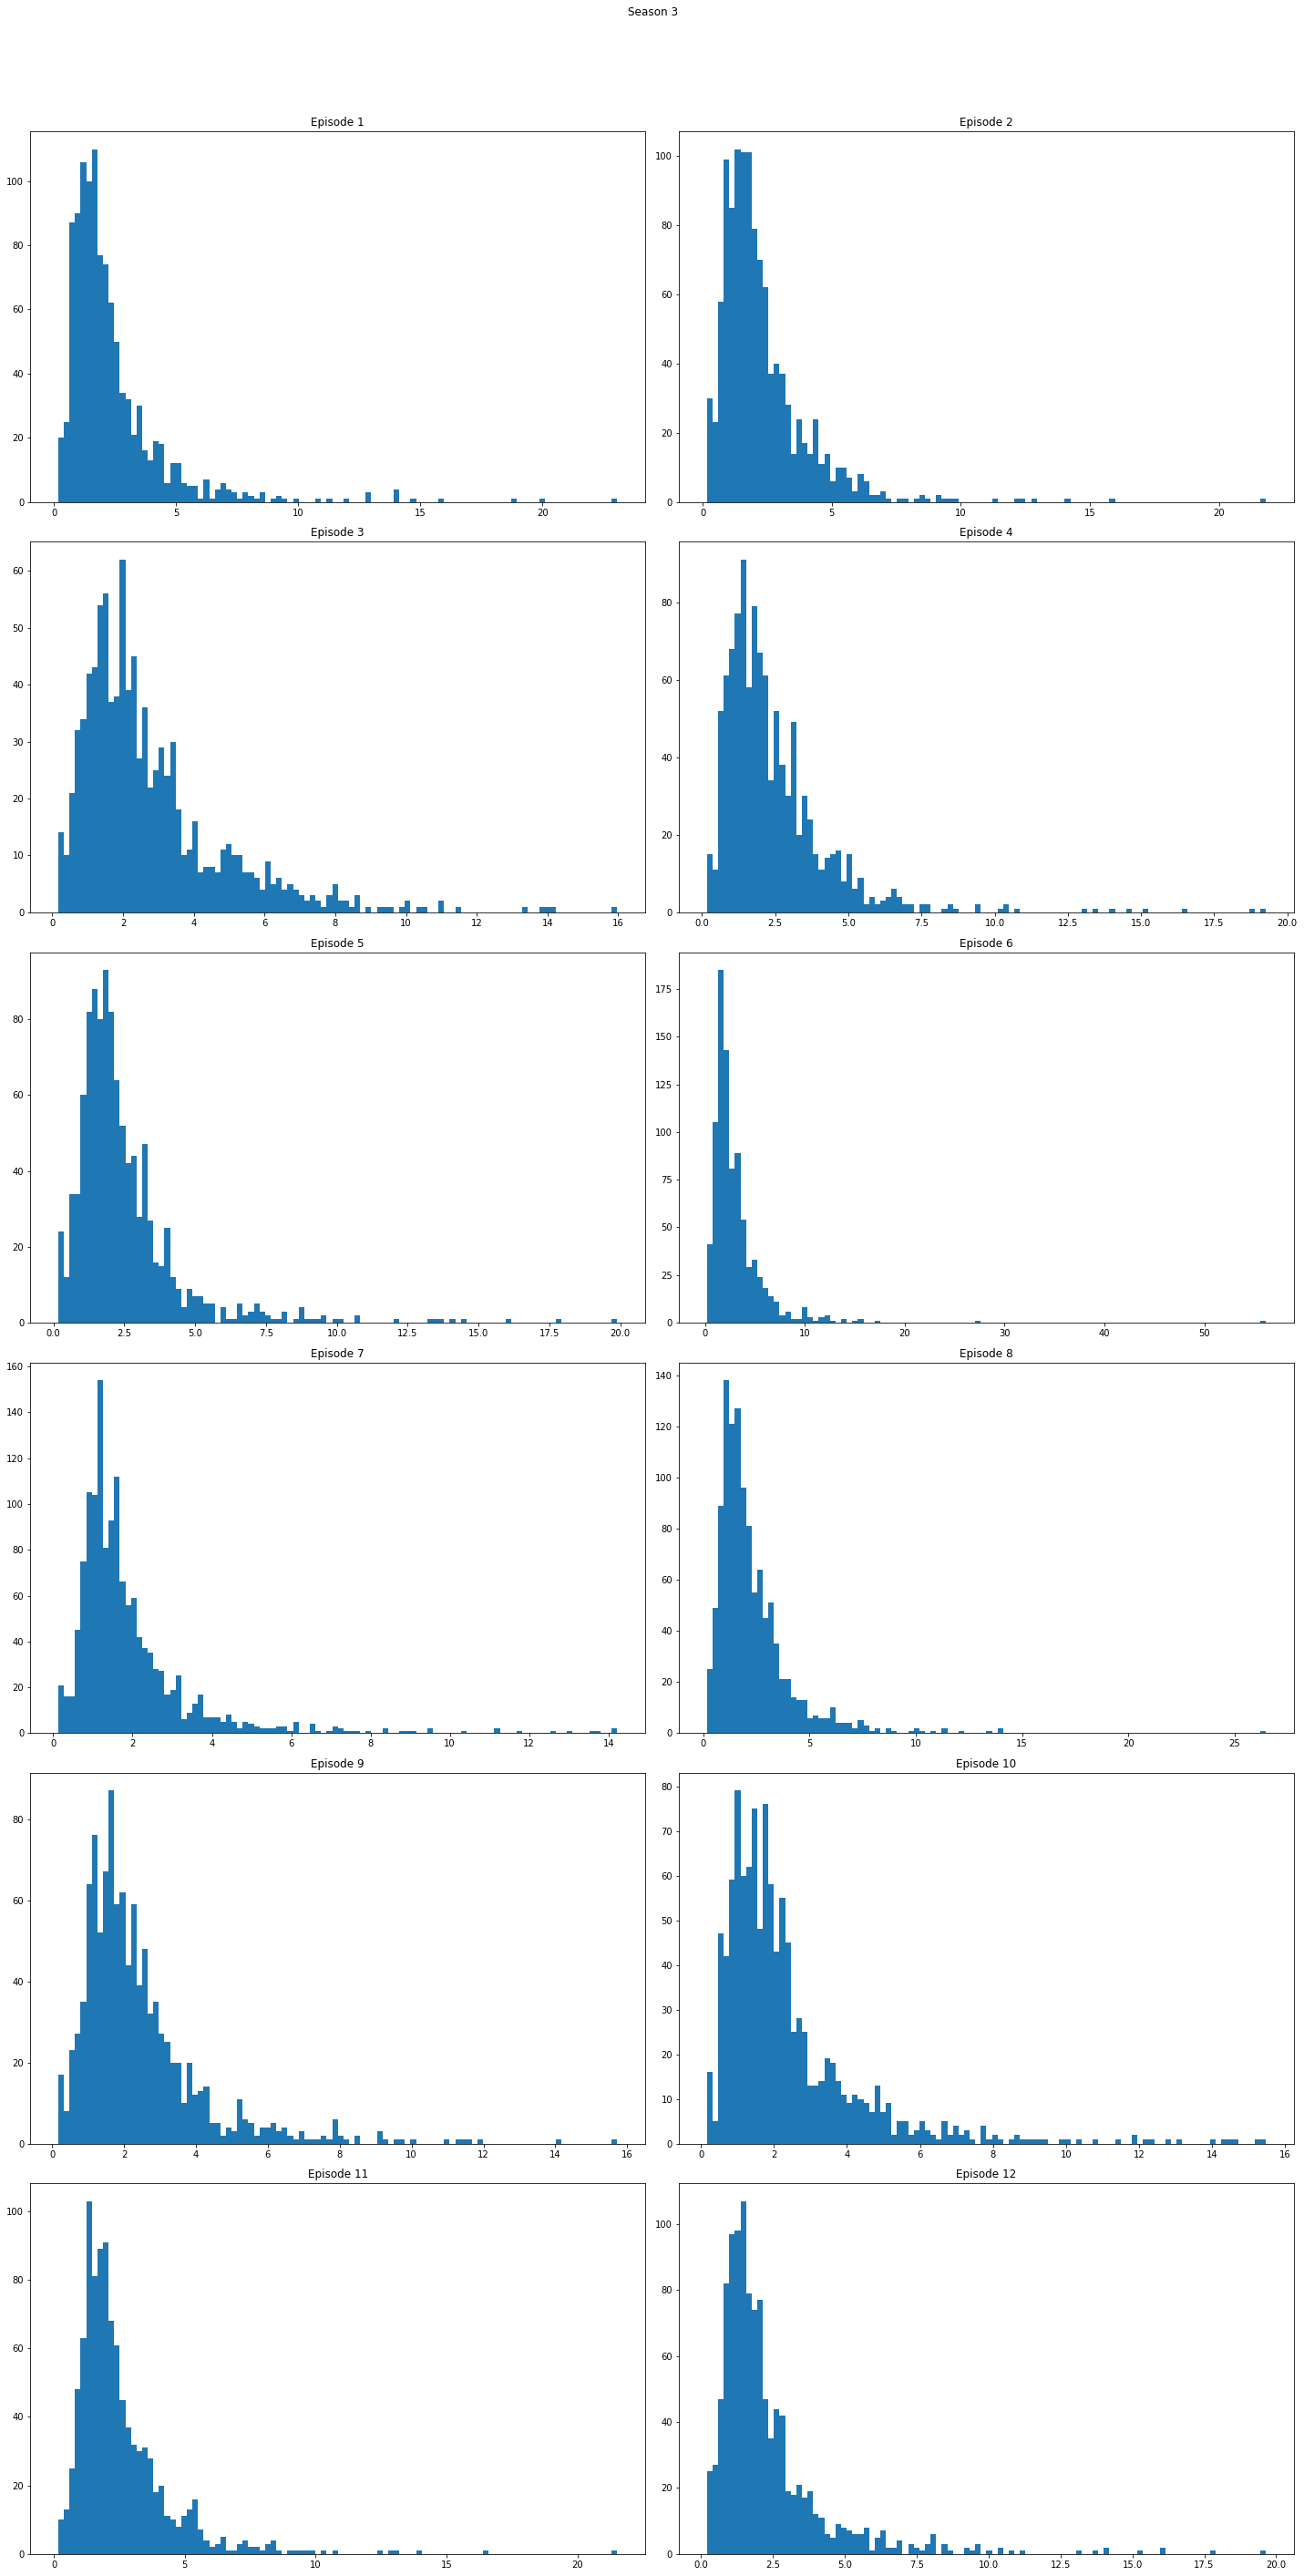

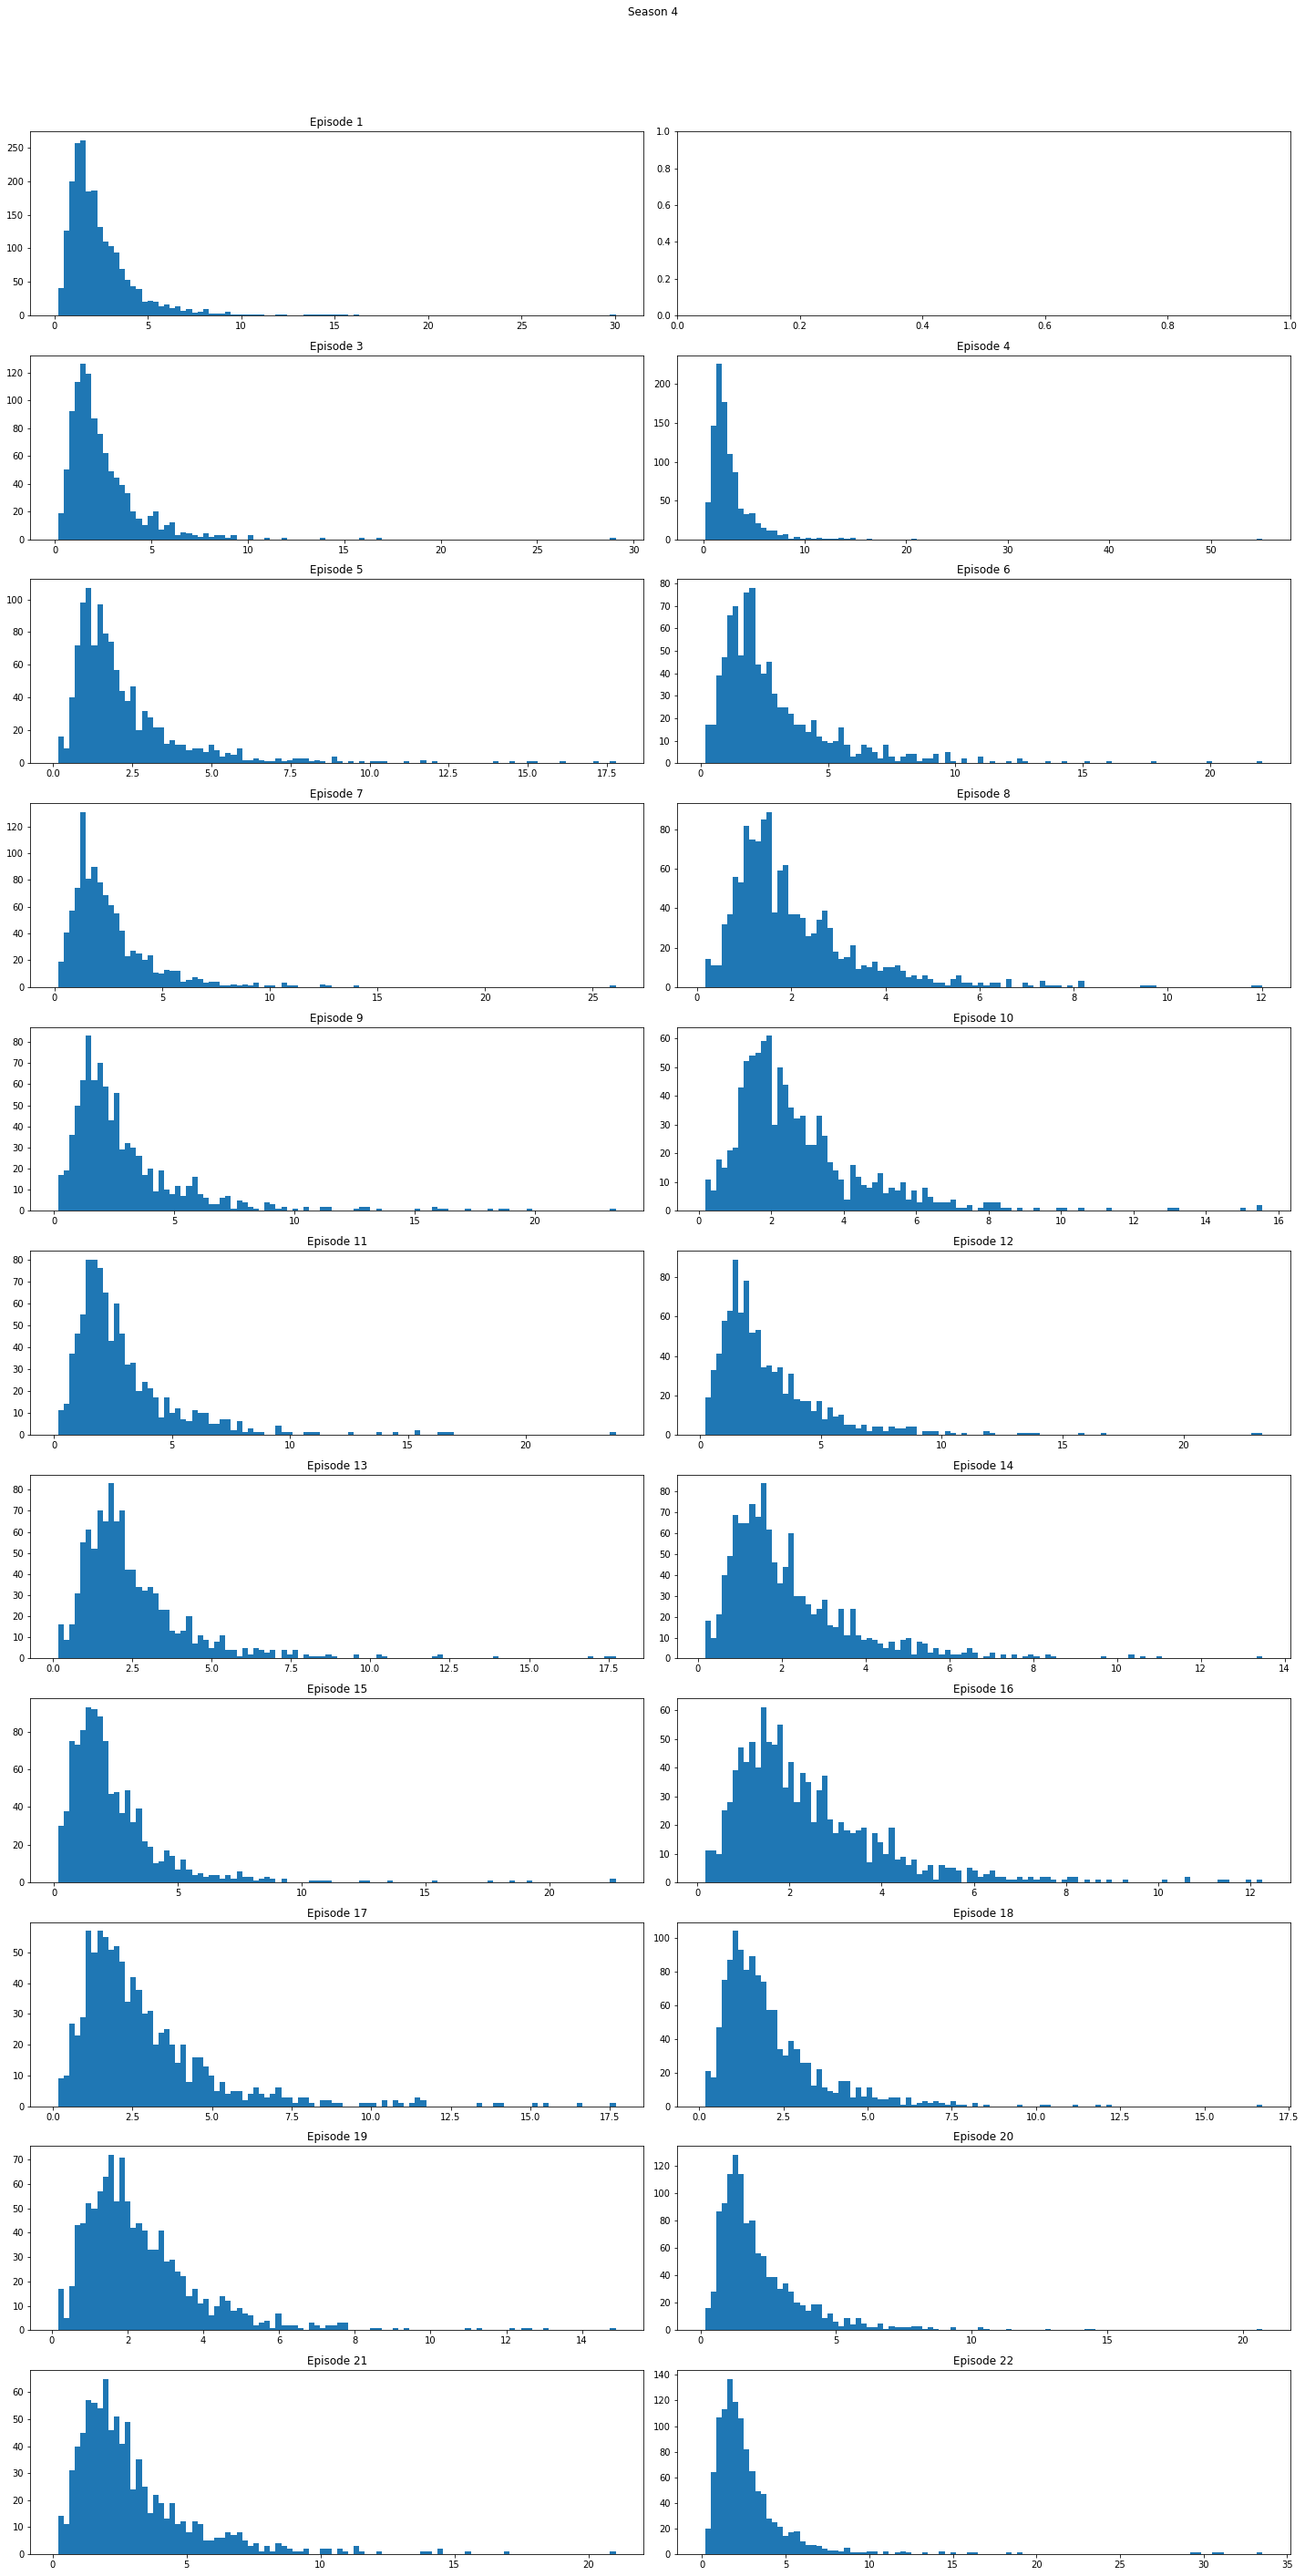

In [7]:
series_name = 'prison-break'
eps_no = [22, 13, 23]
season_start_no = 2
season_end_no = 4
# series_name = '24'
# eps_no = [24]*6 + [12]
# season_start_no = 3
# season_end_no = 9

# generic code
all_season = []
fig0, ax0 = plt.subplots(season_end_no-season_start_no+1, 1, figsize=(20, 40))
fig0.suptitle("Seasons Wise")
# for i in range(3, 10):
for i in range(season_start_no, season_end_no+1):
    fig2, ax2 = plt.subplots(eps_no[i-season_start_no]//2, 2, figsize=(20, 40))
    fig2.suptitle("Season %d" % i)
    season_level = []
    last_ep_no = eps_no[i-season_start_no] if eps_no[i-season_start_no]%2==0 else eps_no[i-season_start_no]-1
    for j in range(1, last_ep_no+1):
        if i == 4 and j == 2:
            continue
        videvents = np.asarray(readVidEvents(Path("../data/%s/S%02d/S%02dE%02d/S%02dE%02d.videvents" % (series_name, i, i, j, i, j)), split_val=2))
        shifted_videvents = np.hstack(([0], videvents[:-1, 1]))
        shot_durations = videvents[:, 1] - shifted_videvents
        all_season += shot_durations.tolist()
        season_level += shot_durations.tolist()
        ax2[(j-1)//2, (j-1)%2].hist(shot_durations, bins=100)
        ax2[(j-1)//2, (j-1)%2].set_title("Episode %d" % j)
    fig2.tight_layout(rect=[0, 0, 1, 0.95])
    ax0[i-season_start_no].hist(season_level, bins=100)
    ax0[i-season_start_no].set_title("Season %d" % i)
fig0.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

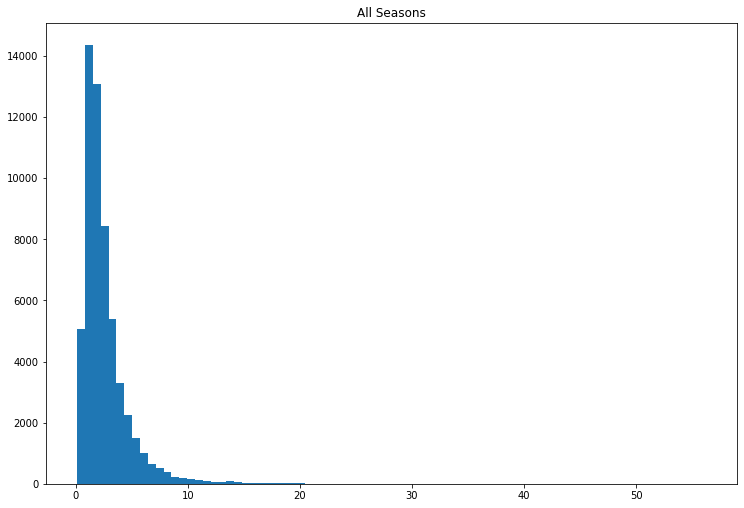

In [8]:
# For all seasons together
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.hist(all_season, bins=80)
plt.title("All Seasons")
plt.show()


##### Checking frequency plot for `frame_counts` per shot for `imagenet`, `mvit`, and `clip`.

In [ ]:
imagenet_shot_len, mvit_shot_len, clip_shot_len = [], [], []
for ep in eps_names:
    imagenet, mvit, clip = {}, {}, {}
    enc = load_pickle(f"../data/24/S03/S03{ep}/encodings/vid_encodings/episode_encodings.pkl")
    for key in enc['imagenet']:
        if int(key[5:9]) not in imagenet:
            imagenet[int(key[5:9])] = 1
        else:
            imagenet[int(key[5:9])] += 1
    for key in enc['mvit']:
        if int(key[5:9]) not in mvit:
            mvit[int(key[5:9])] = 1
        else:
            mvit[int(key[5:9])] += 1
    for key in enc['clip']:
        if int(key[5:9]) not in clip:
            clip[int(key[5:9])] = 1
        else:
            clip[int(key[5:9])] += 1
    imagenet_shot_len.extend(list(imagenet.values()))
    mvit_shot_len.extend(list(mvit.values()))
    clip_shot_len.extend(list(clip.values()))

**Plot Histogram for Imagenet, Mvit, and Clip**

In [ ]:
bin = 60
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].hist(imagenet_shot_len, bins=bin)
ax[0].set_xticks(np.arange(0, 300, 5))
ax[0].set_xticklabels(np.arange(0, 300, 5), rotation=90, fontsize=5)
ax[0].set_title("ImageNet")
ax[1].hist(mvit_shot_len, bins=bin)
ax[1].set_xticks(np.arange(0, 50, 5))
ax[1].set_xticklabels(np.arange(0, 50, 5), rotation=90)
ax[1].set_title("MVIT")
ax[2].hist(clip_shot_len, bins=bin)
ax[2].set_xticks(np.arange(0, 300, 5))
ax[2].set_xticklabels(np.arange(0, 300, 5), rotation=90, fontsize=5)
ax[2].set_title("CLIP")
plt.show()

## Visualizing distribution for episodic RECAP dependencies on Given EPISODES.

- Histograms showing no. of unique shots from earlier EPISODES for a given epsiodic RECAP.
- Analysis on what observations one can make from it will be completely discussed.

In [3]:
def df_to_dict(data:Dict):
    new_dict = defaultdict(dict)
    for k in data:
        shot = data[k]['Unnamed: 0']
        for info in list(data[k].keys()):
            if info != 'Unnamed: 0':    
                if type(data[k][info]) == str:
                    new_dict[shot][info] = eval(data[k][info])
                elif np.isnan(data[k][info]):
                    pass
                else:
                    new_dict[shot][info] = data[k][info]
    return new_dict

def extractData(eps_name:str,
                vid_part_type:str="episode",
                series_name:str='24',
                season_name: str='S03',
               )->Tuple[int, Dict[str, List[int]]]:
    """
    Extract data from the gievn EPISODE.
    Mapping each shot to the list of shots in a recent EPISODE.
    -------------------------------------------------------
    Args:
        - eps_name: name of the episode in the form of "S03E02"

    Return:
        - No. of shots in RECAP
        - Episode wise info on List of shots that matches with RECAP shot
    """
    if vid_part_type == "episode":
        data = load_pickle(f"../data/{series_name}/{season_name}/{season_name}{eps_name}/scores/vid_scores/recapVepisode/shot_matching.pkl")
    else:    
        data = df_to_dict(pd.read_csv(f"../data/{series_name}/{season_name}/{season_name}{eps_name}/scores/vid_scores/recapVrecap/shot_matching.csv").to_dict(orient='index'))
    past_episodes = ["E{0:02n}".format(k) for k in range(int(eps_name[-2:])-1, 0, -1)]
    eps_wise_shot_info = {ep_name: [] for ep_name in past_episodes}
    for shot in data:
        for eps in past_episodes:
            if data[shot]["cnt"] == 0 or eps not in data[shot]:
                break
            elif len(data[shot][eps])==0:
                continue
            elif len(data[shot][eps]):
                eps_wise_shot_info[eps].append(list(data[shot][eps].keys()))
                break
    return len(data), eps_wise_shot_info


def compareRwE(eps_name:str,
               series_name: str = '24',
               season_name: str = 'S03'):
    """
    Compare PAST RECAP R_(n-1) with R_n.
    --------------------------------------------------------------------------------
    Args:
        - eps_name: name of the episode in the form of "E02"

    Return:
        - Tuple of  total shots in E_n and E_(n-1)
        - Total count of `extractive` shots in R_n present in En-2 to E1
        - Total # of `extractive` shots present in R_n (that are in En-1 to E1)
        - How many shots are common in R_n and R_(n-1) along
          along with their episodic info as key. 
    """
    Cn, Rn = extractData(eps_name, series_name=series_name, season_name=season_name)
    En_1 = "E{:02n}".format(int(eps_name[-2:])-1)
    Cn_1, Rn_1 = extractData(En_1, series_name=series_name, season_name=season_name)
    result = {}
    Rn_shots_cnt = 0
    for eps in Rn:
        result[eps] = 0
        if eps != En_1:
            for shot_lst in Rn[eps]:
                Rn_shots_cnt += 1
                for shot_lst_1 in Rn_1[eps]:
                    if len(set(shot_lst) & set(shot_lst_1)):
                        result[eps] += 1
                        break
    return (Cn, Cn_1), Rn_shots_cnt, Rn_shots_cnt + len(Rn[En_1]), result

def plot_bar(eps_names:List[str],
             vid_part_type:str="episode",
             season:str='S03',
             series:str='24'
            )->None:
    n = len(eps_names)
    if n % 2 != 0:
        m = n - 1
    else:
        m = n
    fig, ax = plt.subplots(nrows=m//2, ncols=2, figsize=(15, 30))
    plt.suptitle(f"Dependency BAR for Recap v/s {vid_part_type} for {season} season of Series {series}.\n\n")
    for i, ep in enumerate(eps_names[:m]):
        len_shots, shots_dict = extractData(
            ep, vid_part_type=vid_part_type, series_name=series, season_name=season)
        x = list(range(1, len(shots_dict)+1))
        y = [len(shots_dict[ep_name]) for ep_name in shots_dict]#*100/len_shots
        print(f"y = {y}")
        ax[i//2, i%2].bar(x, y)
        ax[i//2, i % 2].set_title(ep)
        ax[i//2, i % 2].set_xticks(x)
        ax[i//2, i % 2].set_xticklabels(list(shots_dict.keys()), rotation=90)
    plt.tight_layout(rect=[0,0,0.97,1])
    plt.show()
    if n % 2 != 0:
        len_shots, shots_dict = extractData(
            eps_names[-1], vid_part_type=vid_part_type, series_name=series, season_name=season)
        x = list(range(len(shots_dict)))
        y = [len(shots_dict[ep_name]) for ep_name in shots_dict]#*100/len_shots
        plt.bar(np.asarray(x), np.asarray(y))
        plt.xticks(x, list(shots_dict.keys()), rotation = 90)
        plt.title(eps_names[-1])
    plt.show()

### Data ANALYSIS for 24

In [5]:
eps_names = ["E02", "E03", "E04", "E05", "E06",
             "E07", "E08", "E09", "E10", "E11",
             "E12", "E13", "E14", "E15", "E16",
             "E17", "E18", "E19", "E20", "E21",
             "E22", "E23", "E24"]

eps_names_new = ["E18", "E19", "E20", "E21", "E22", "E23", "E24"]
eps_names_E09 = ["E09", "E10", "E11", "E12"]


y = [35, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [24, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
y = [31, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


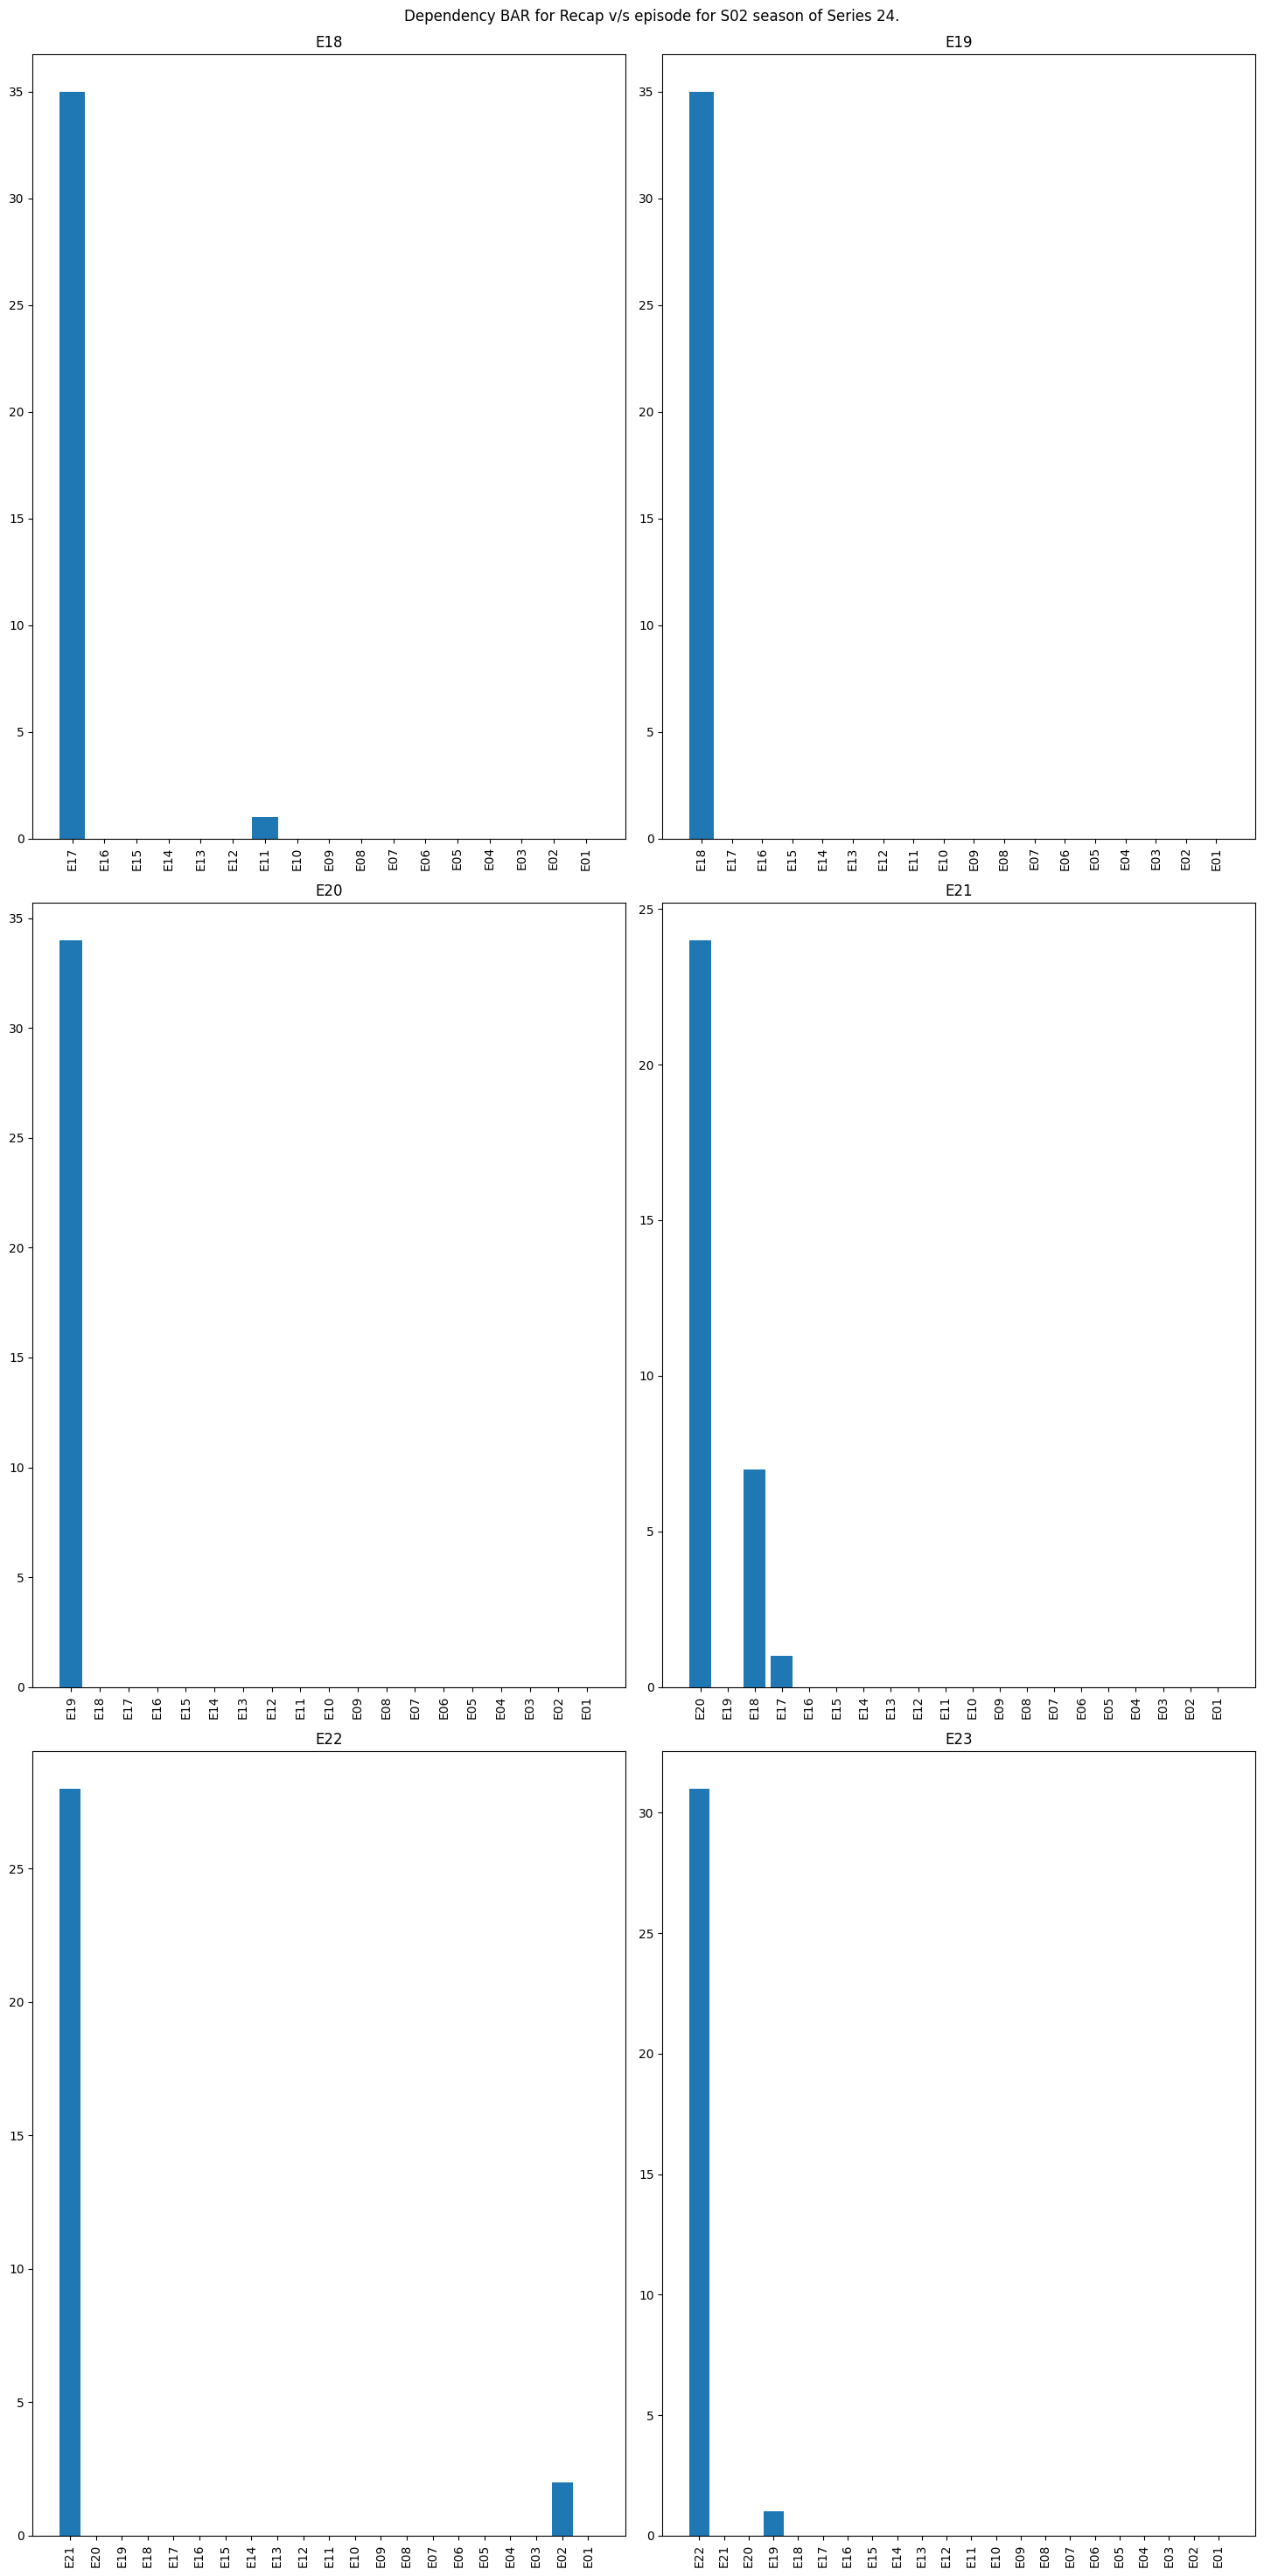

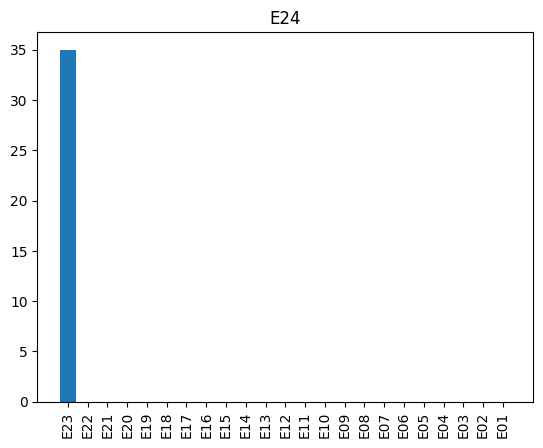

In [20]:
plot_bar(eps_names_new, season="S02")

y = [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [29, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


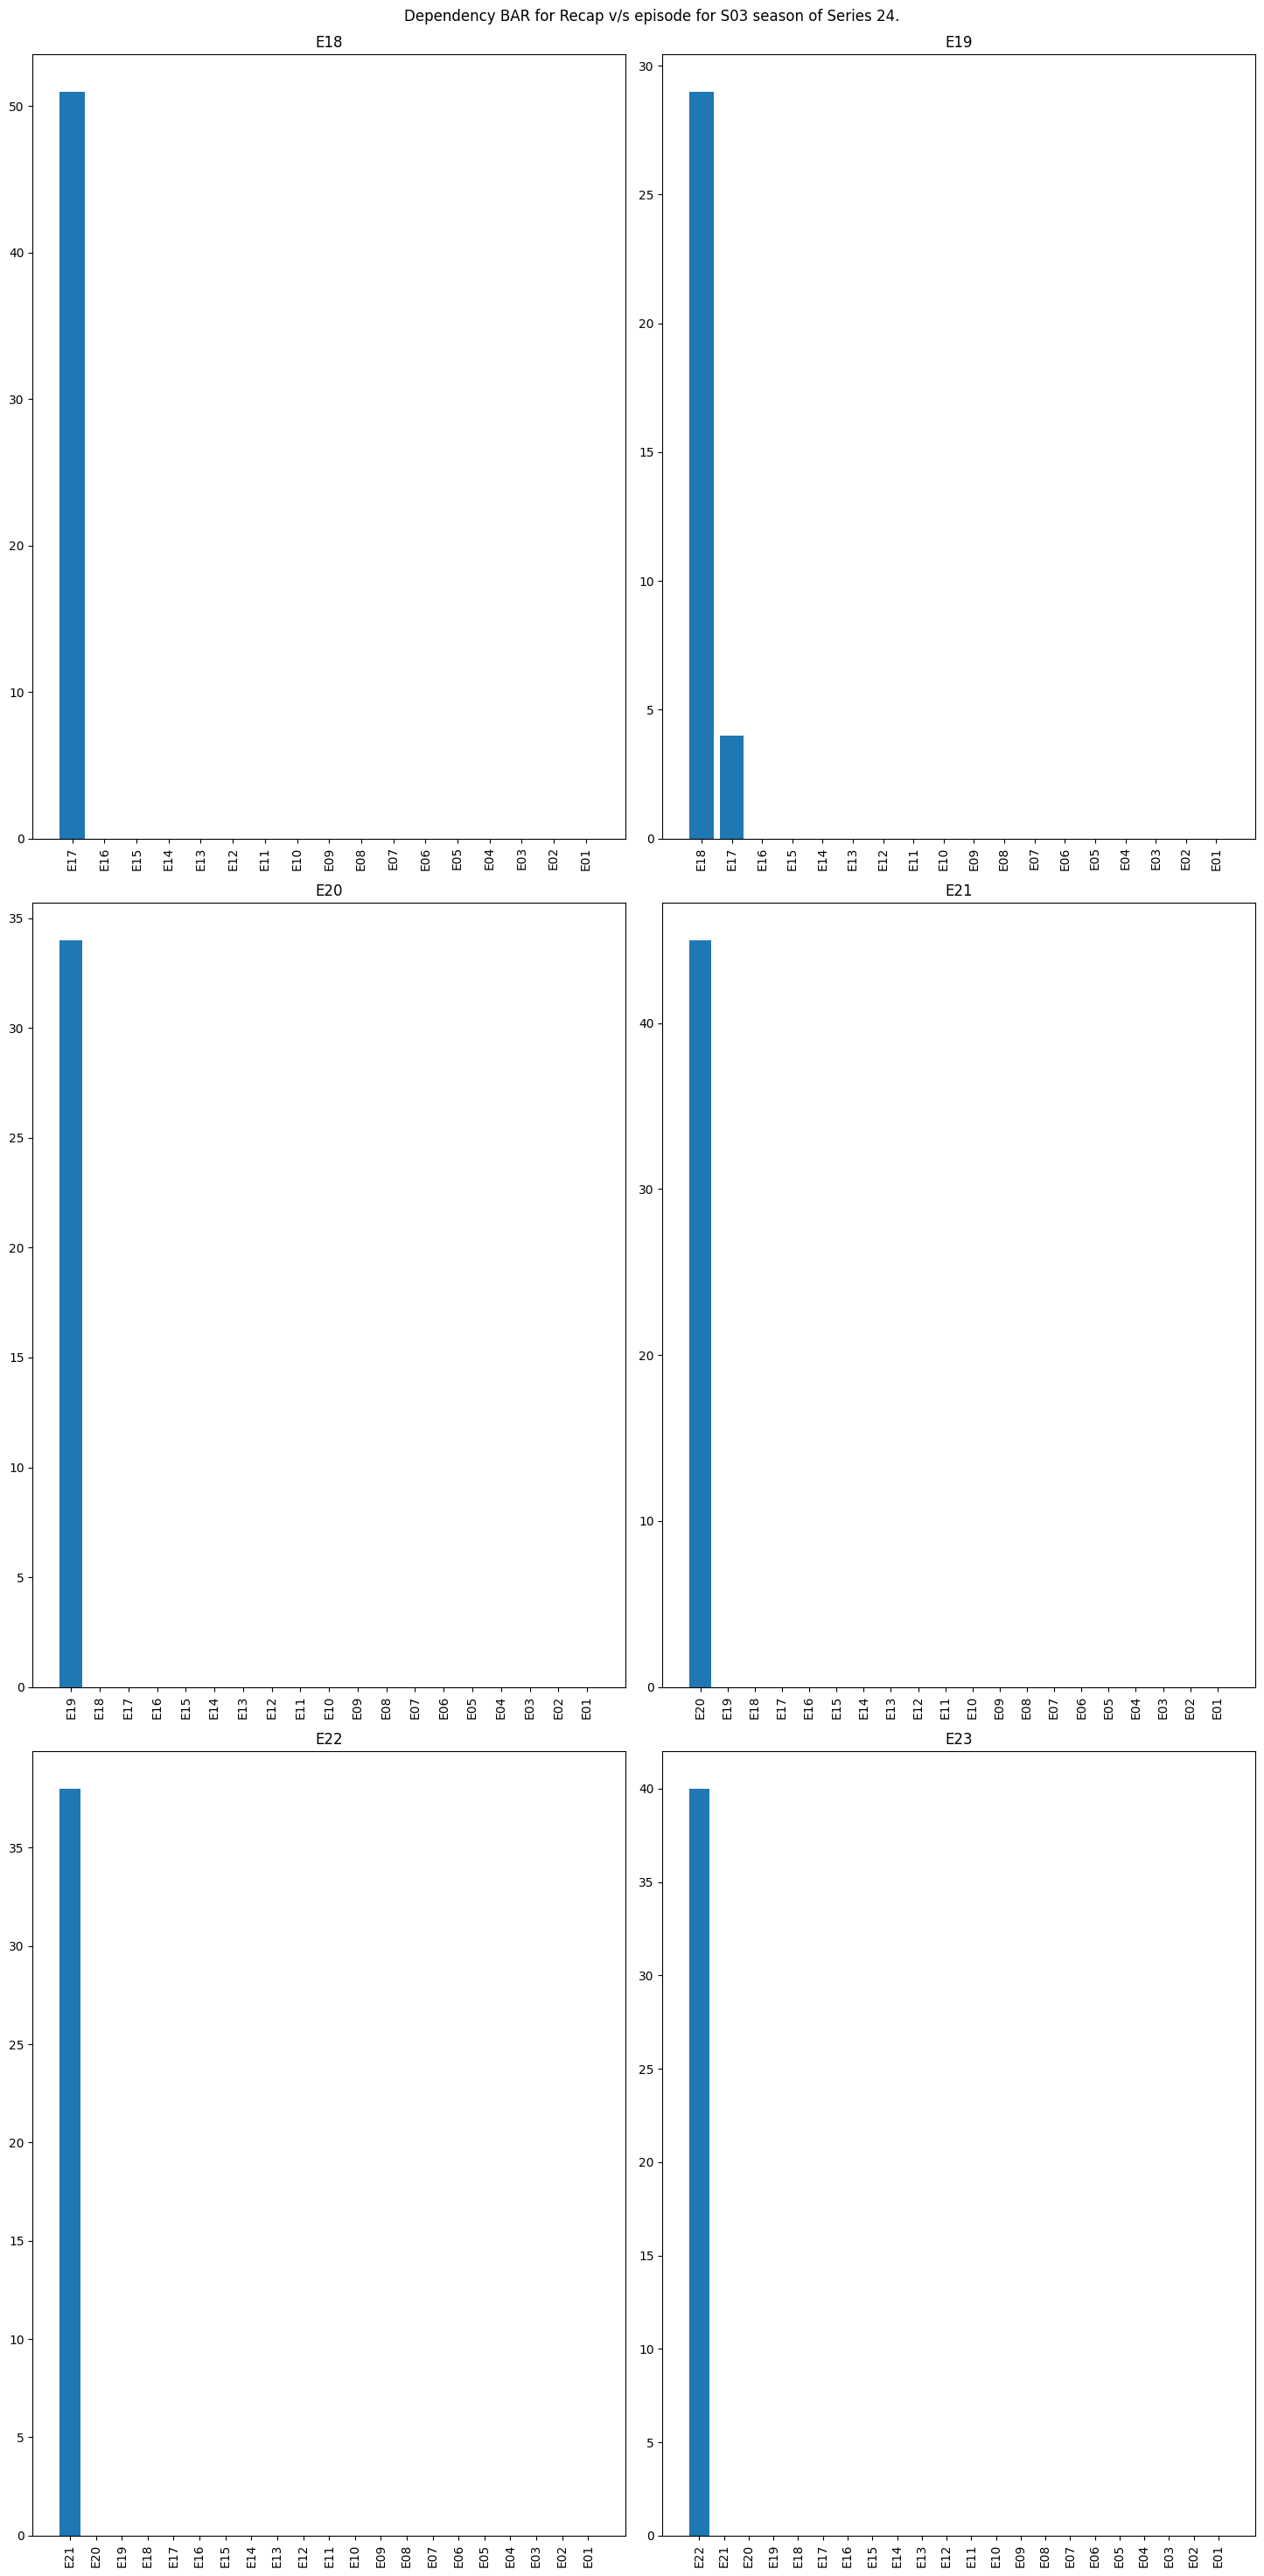

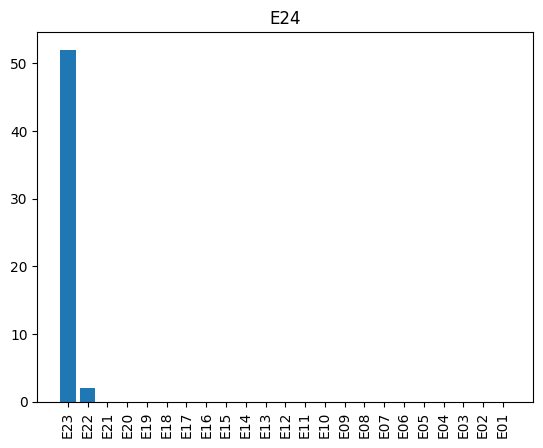

In [21]:
plot_bar(eps_names_new, season="S03")

y = [47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [45, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [52, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
y = [46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [32, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


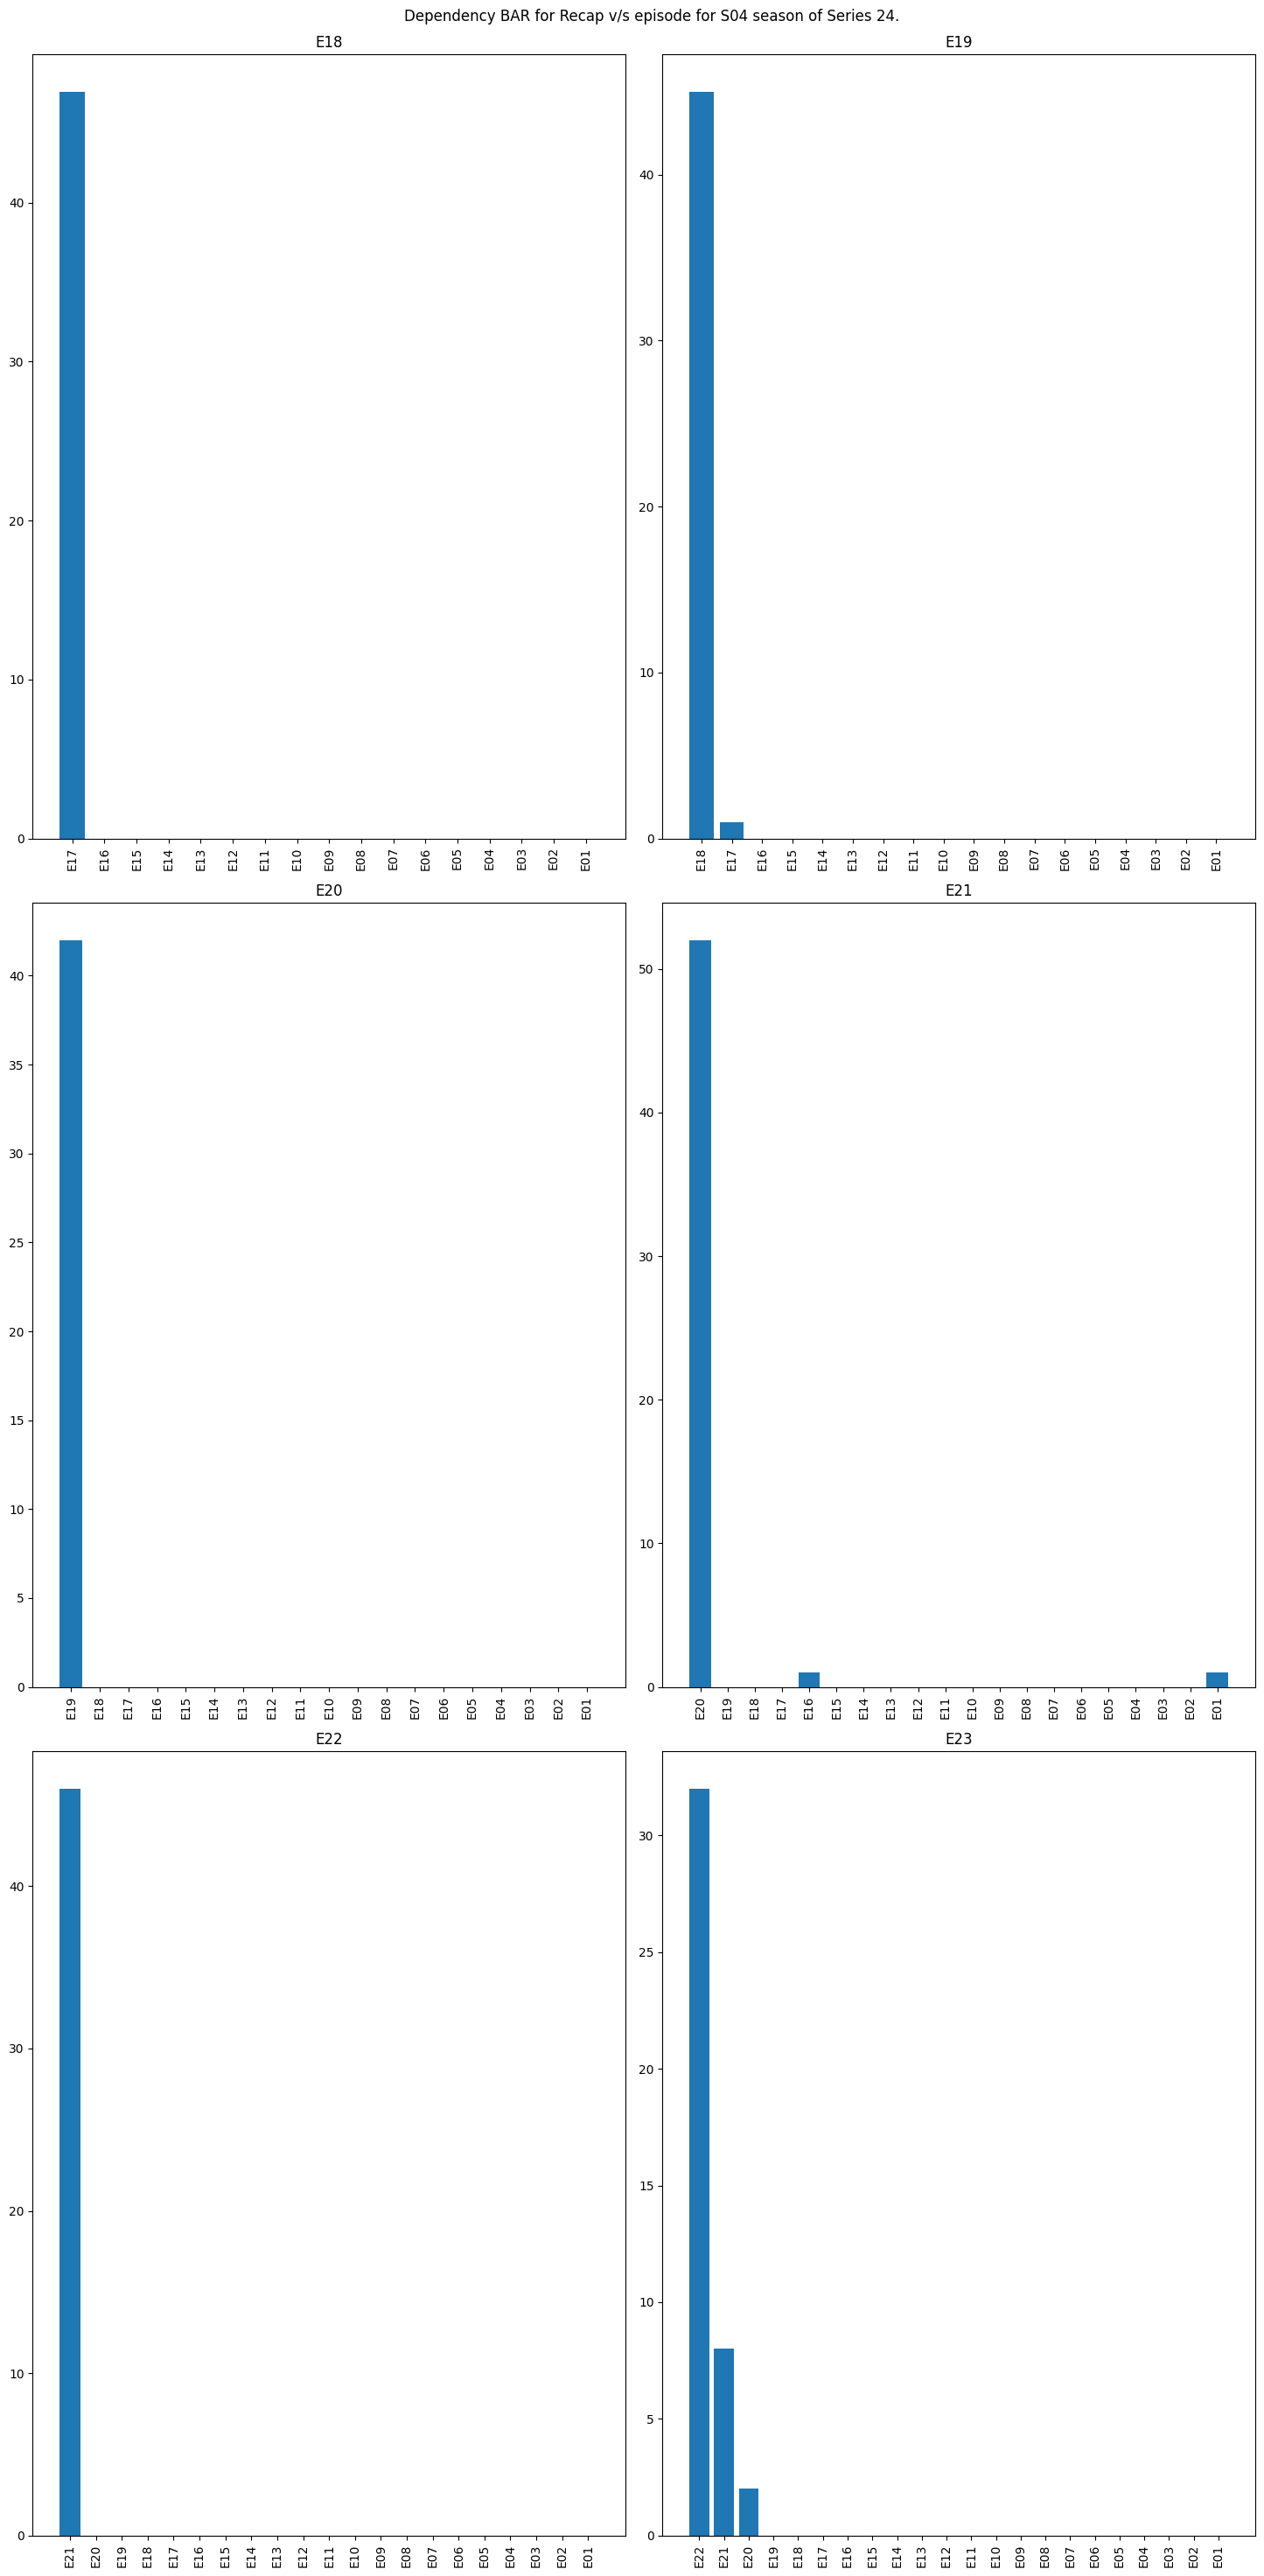

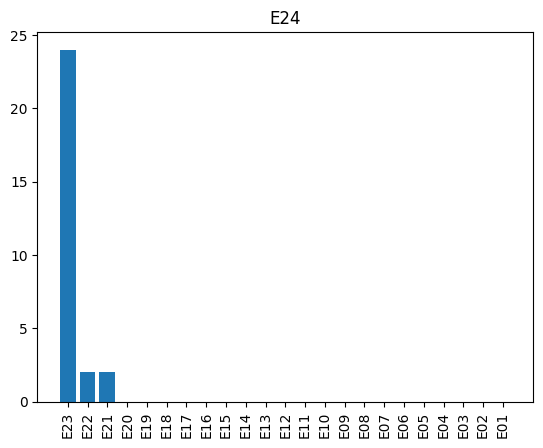

In [22]:
plot_bar(eps_names_new, season="S04")

y = [47, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [67, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [31, 1, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


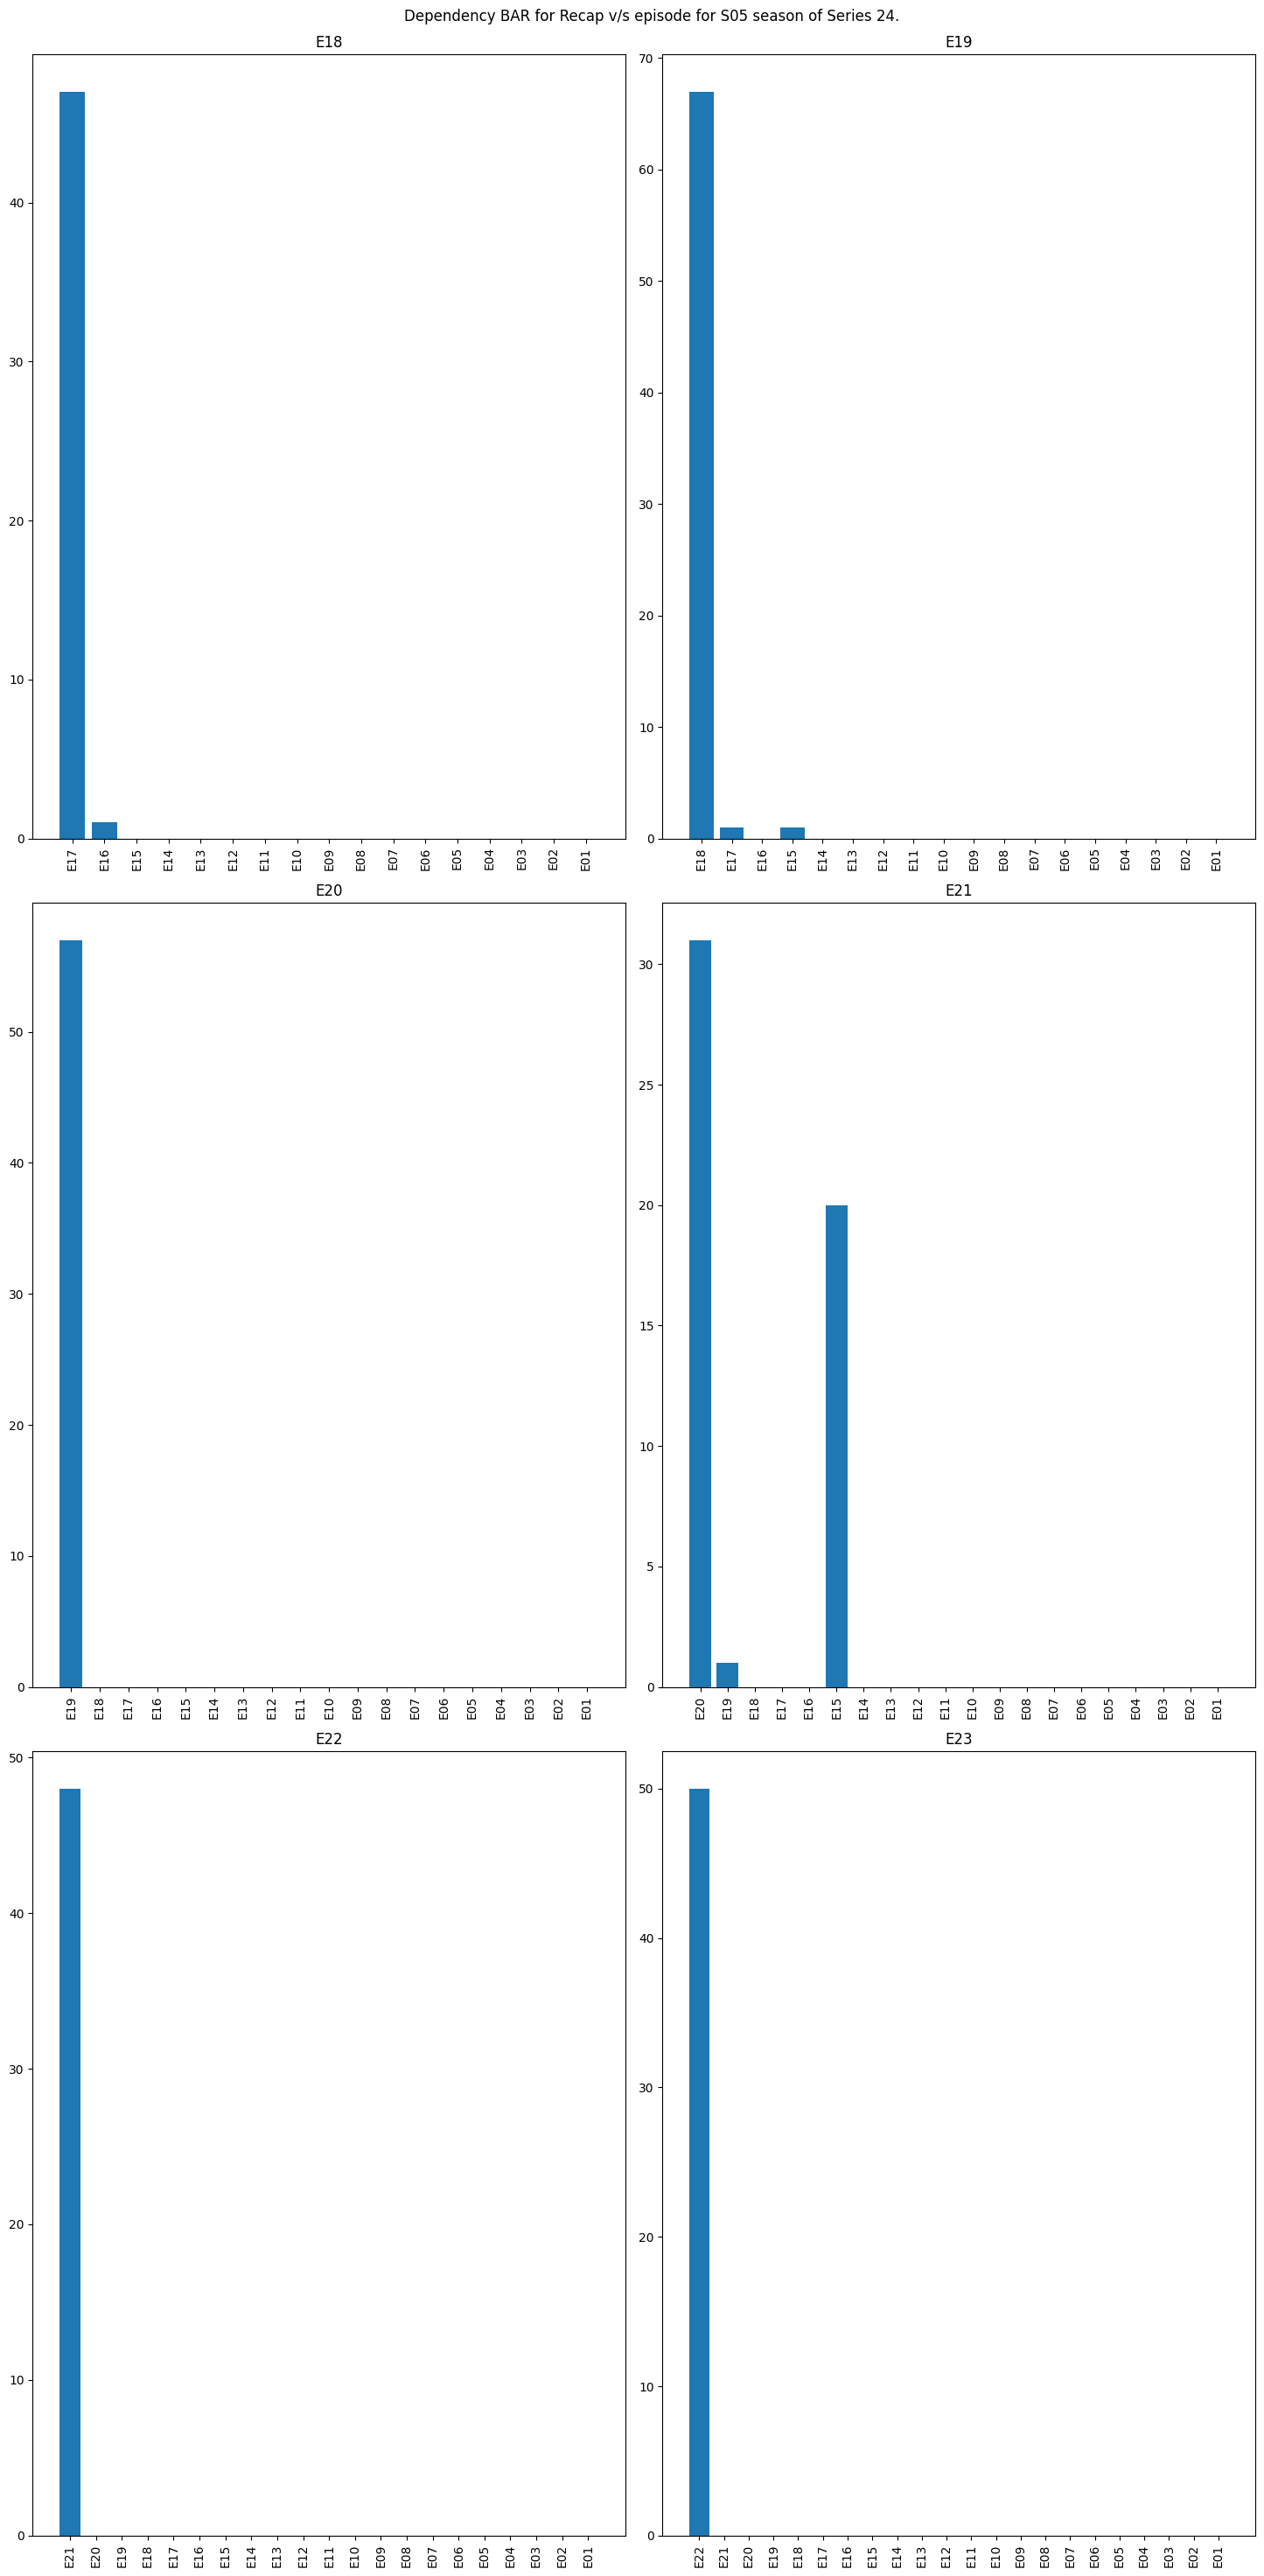

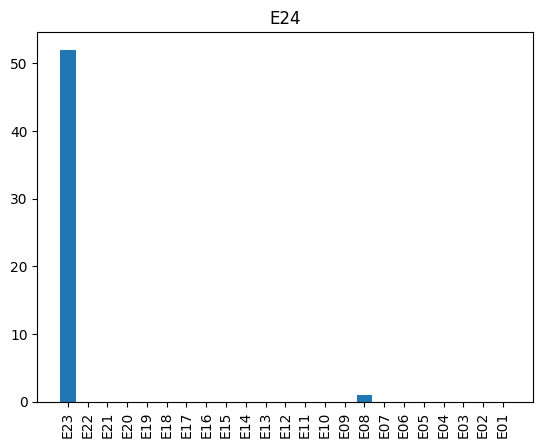

In [23]:
plot_bar(eps_names_new, season="S05")

y = [50, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [47, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [50, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [55, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [37, 7, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


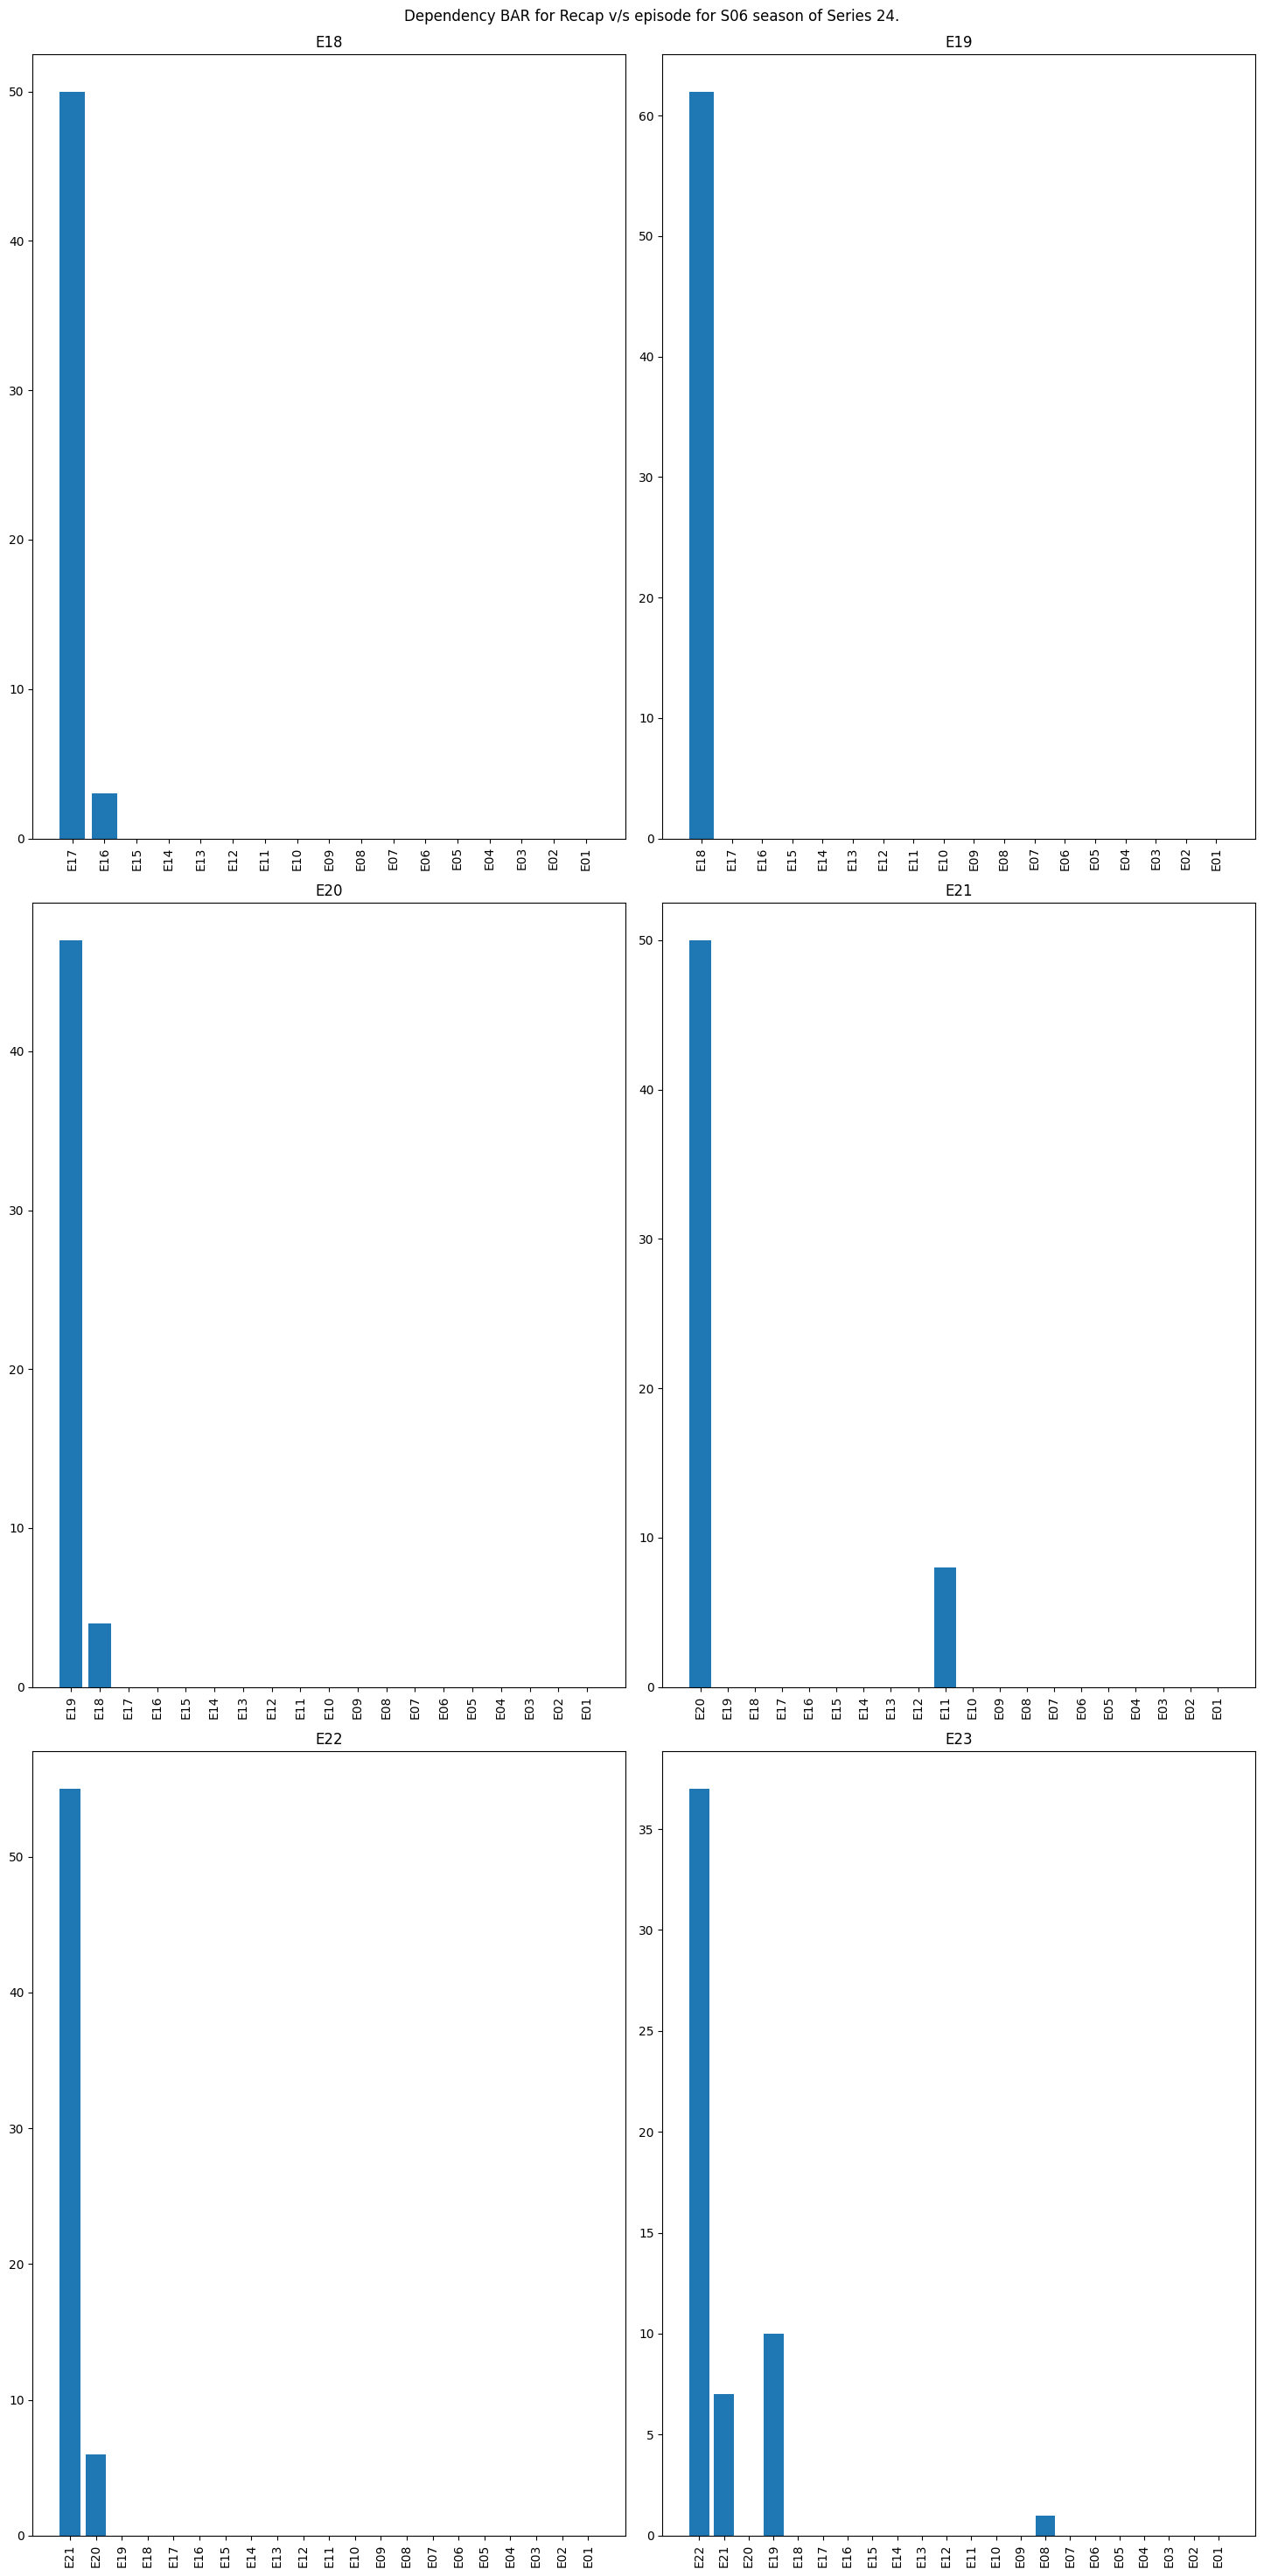

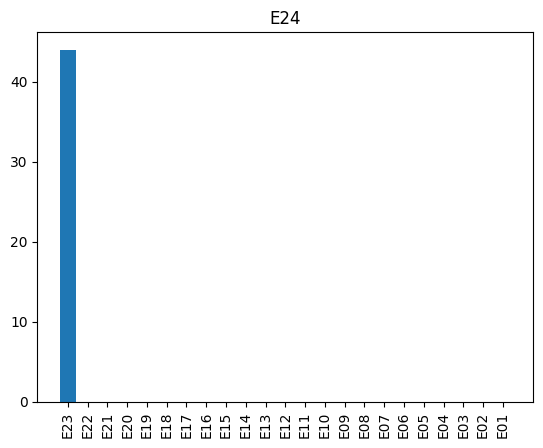

In [6]:
plot_bar(eps_names_new, season="S06")

y = [64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [57, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [51, 1, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [30, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


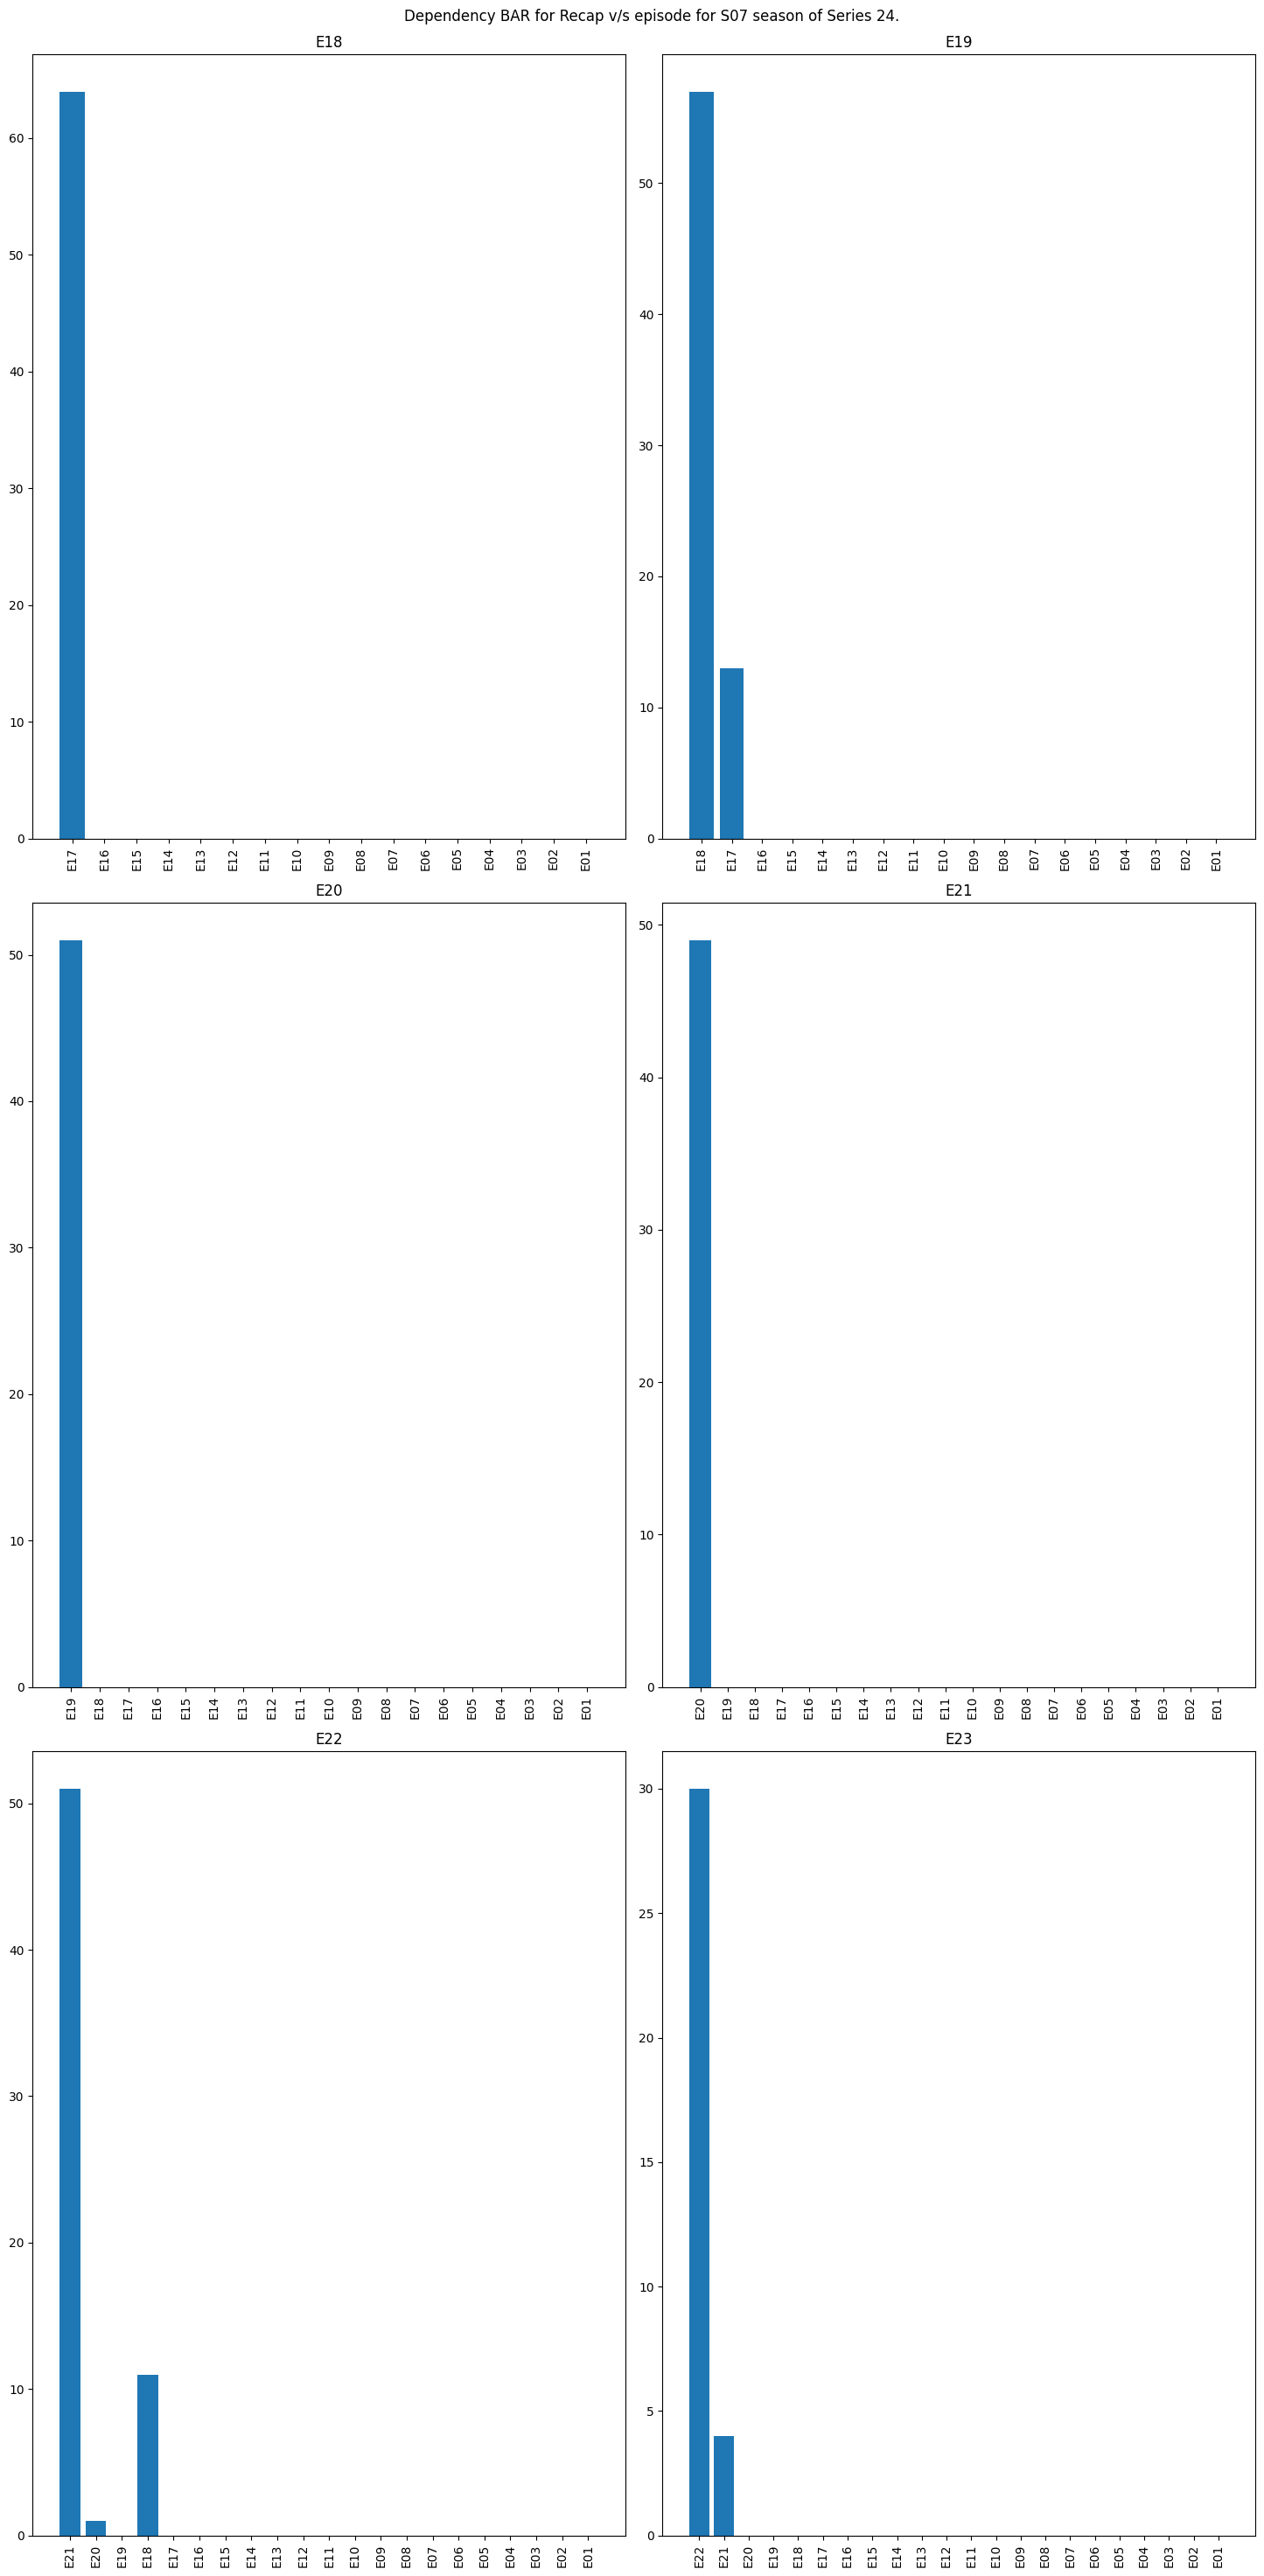

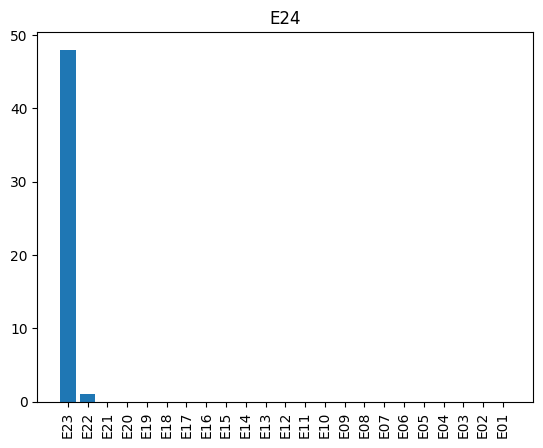

In [7]:
plot_bar(eps_names_new, season="S07")

y = [47, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [51, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


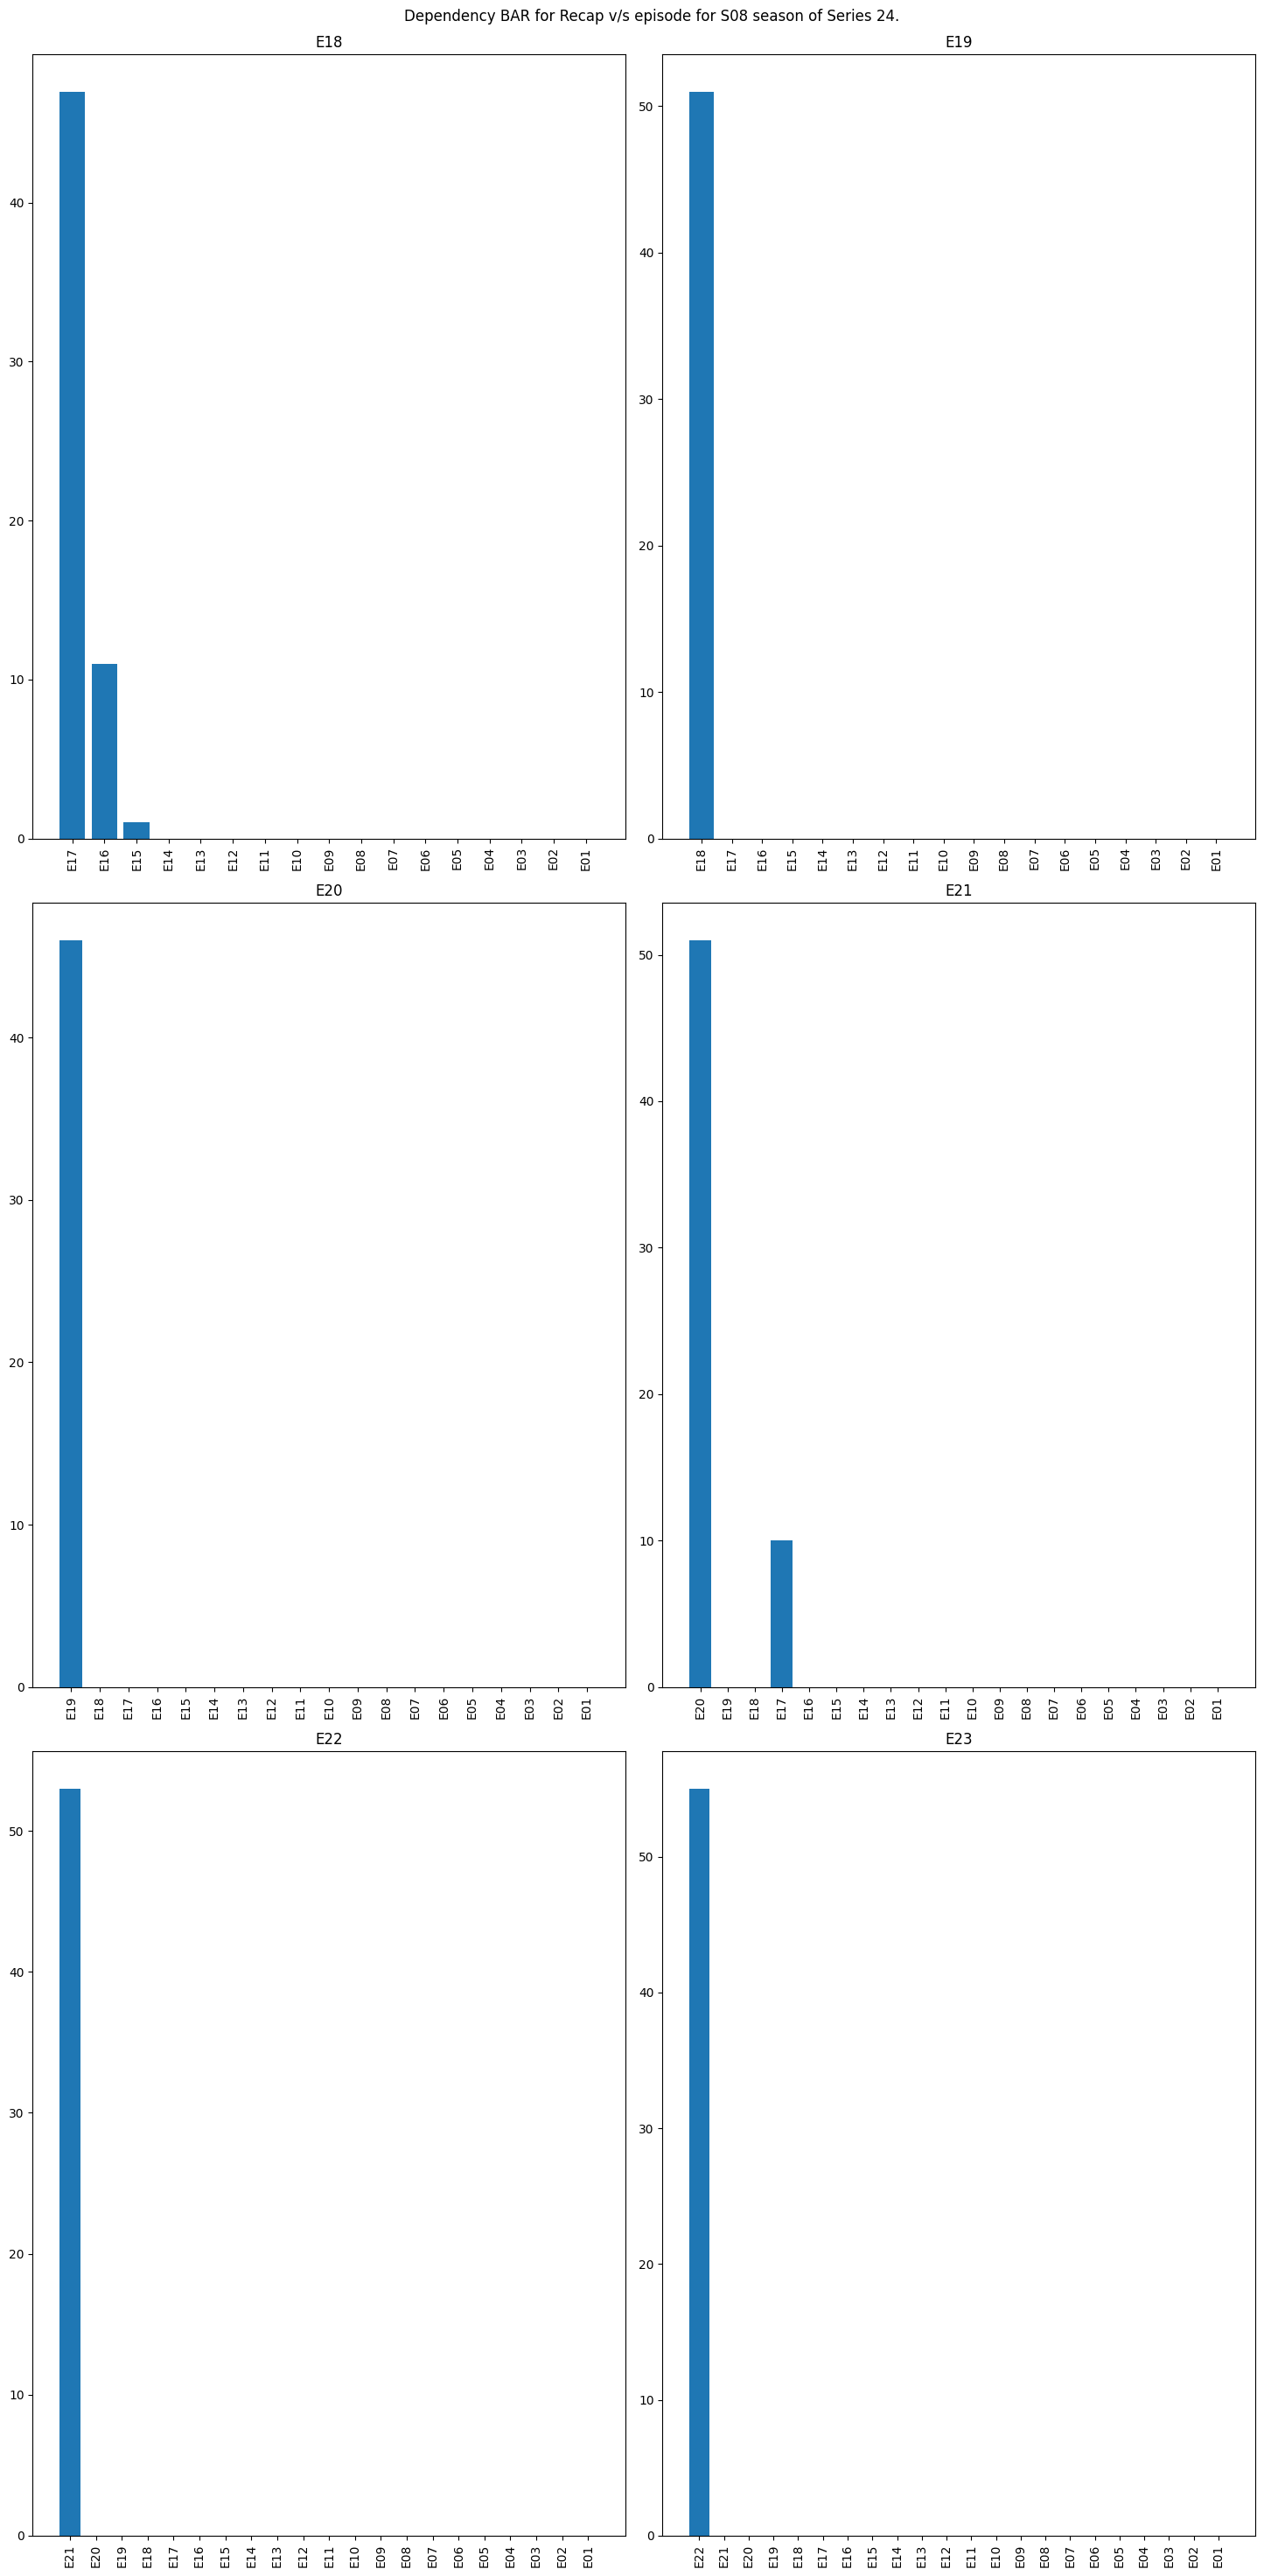

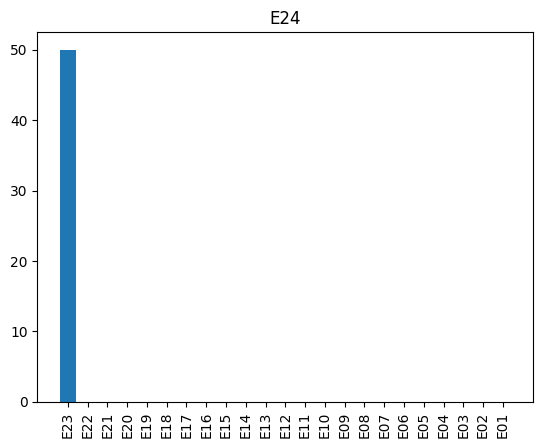

In [24]:
plot_bar(eps_names_new, season="S08")

y = [36, 12, 0, 7, 0, 0, 0, 0]
y = [35, 5, 13, 2, 1, 0, 7, 0, 2]
y = [72, 0, 0, 0, 0, 2, 0, 0, 0, 0]
y = [65, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0]


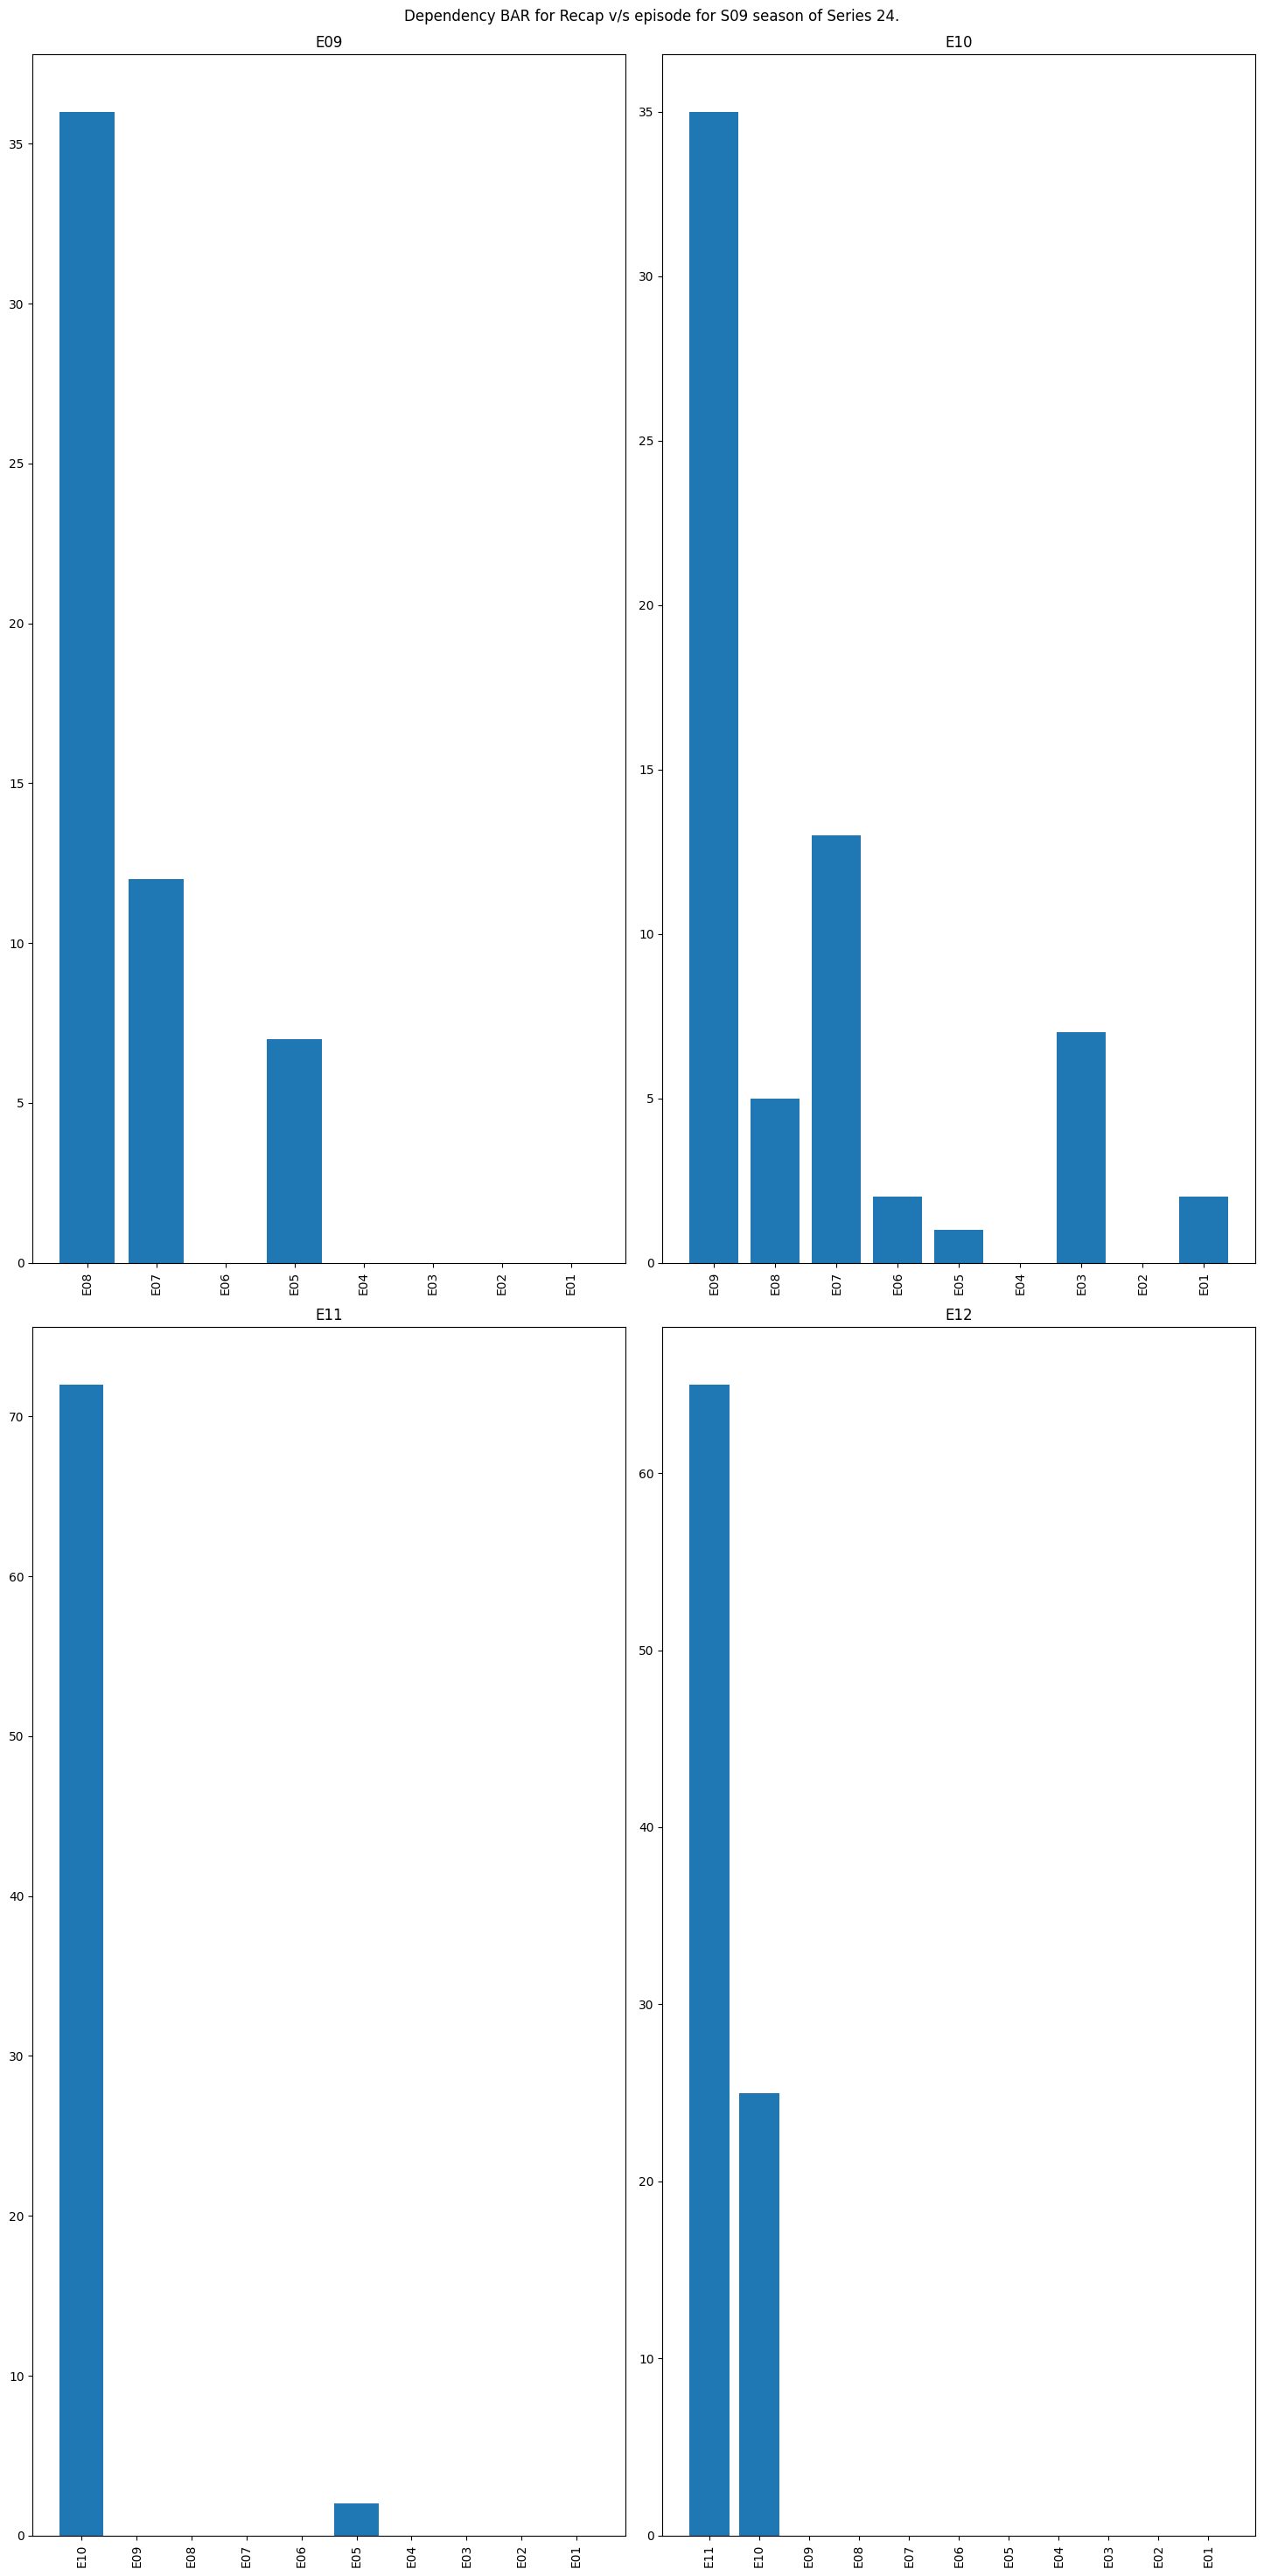

In [28]:
plot_bar(eps_names_E09, season="S09")

y = [37]
y = [34, 3]
y = [27, 0, 1]
y = [36, 1, 0, 2]
y = [36, 0, 0, 0, 0]
y = [29, 2, 0, 0, 0, 1]
y = [33, 0, 0, 0, 0, 0, 0]
y = [33, 0, 0, 0, 0, 0, 0, 1]
y = [34, 0, 0, 0, 0, 0, 0, 0, 0]
y = [26, 21, 0, 0, 0, 0, 1, 0, 0, 0]
y = [40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [53, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [28, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
y = [40, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
y = [24, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [21, 5, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [25, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [25, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


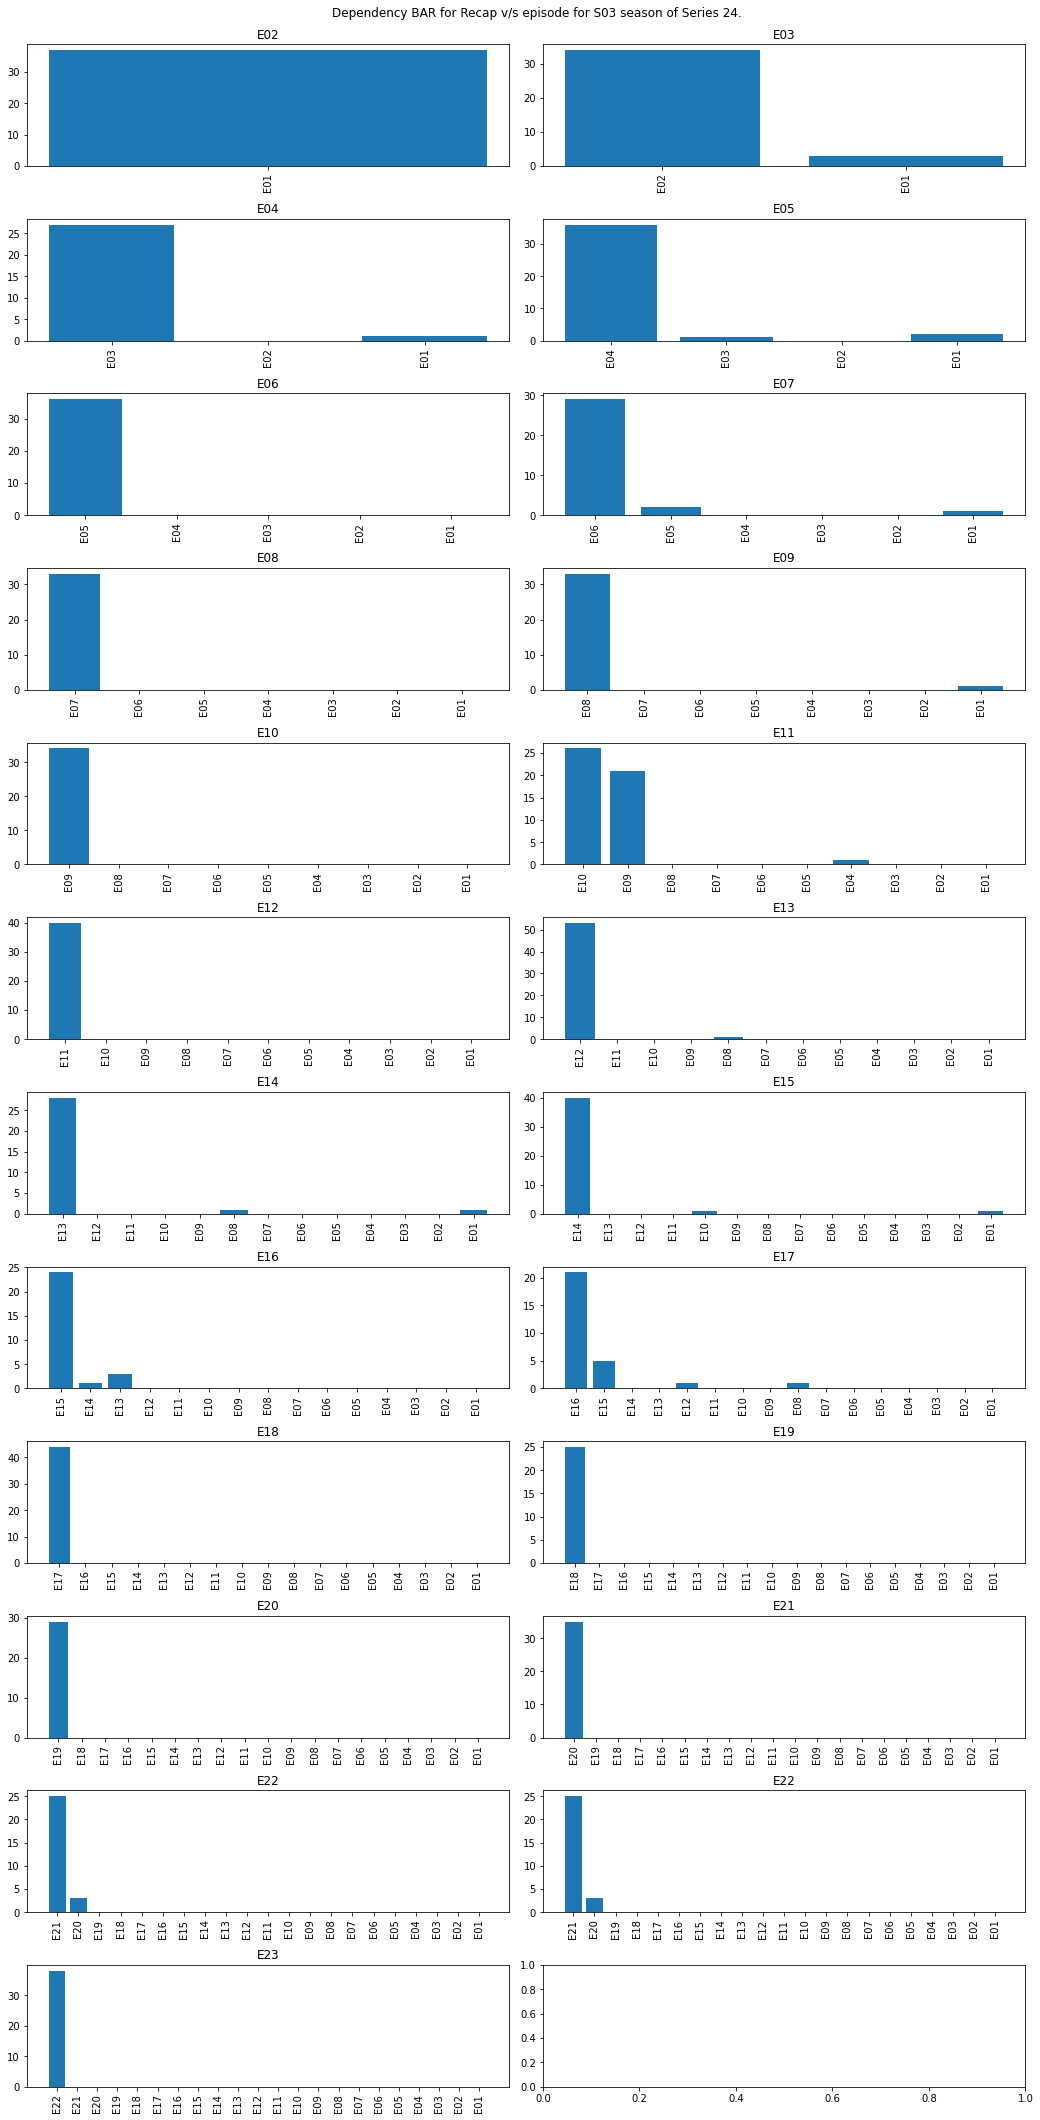

In [20]:
plot_bar(eps_names)
# plot_bar(eps_names, vid_part_type="episode", season="S04", series="24")

y = [6, 0]
y = [6, 4, 0]
y = [6, 0, 1, 0]
y = [1, 0, 3, 0, 0]
y = [2, 4, 0, 1, 3, 0]
y = [3, 0, 4, 1, 0, 0, 0]
y = [1, 2, 0, 2, 1, 1, 0, 0]
y = [2, 2, 3, 0, 0, 1, 0, 0, 0]
y = [20, 3, 4, 1, 0, 0, 0, 1, 0, 0]
y = [5, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0]
y = [2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
y = [1, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]
y = [5, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
y = [6, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [4, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [8, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
y = [1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
y = [4, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [4, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [2, 4, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


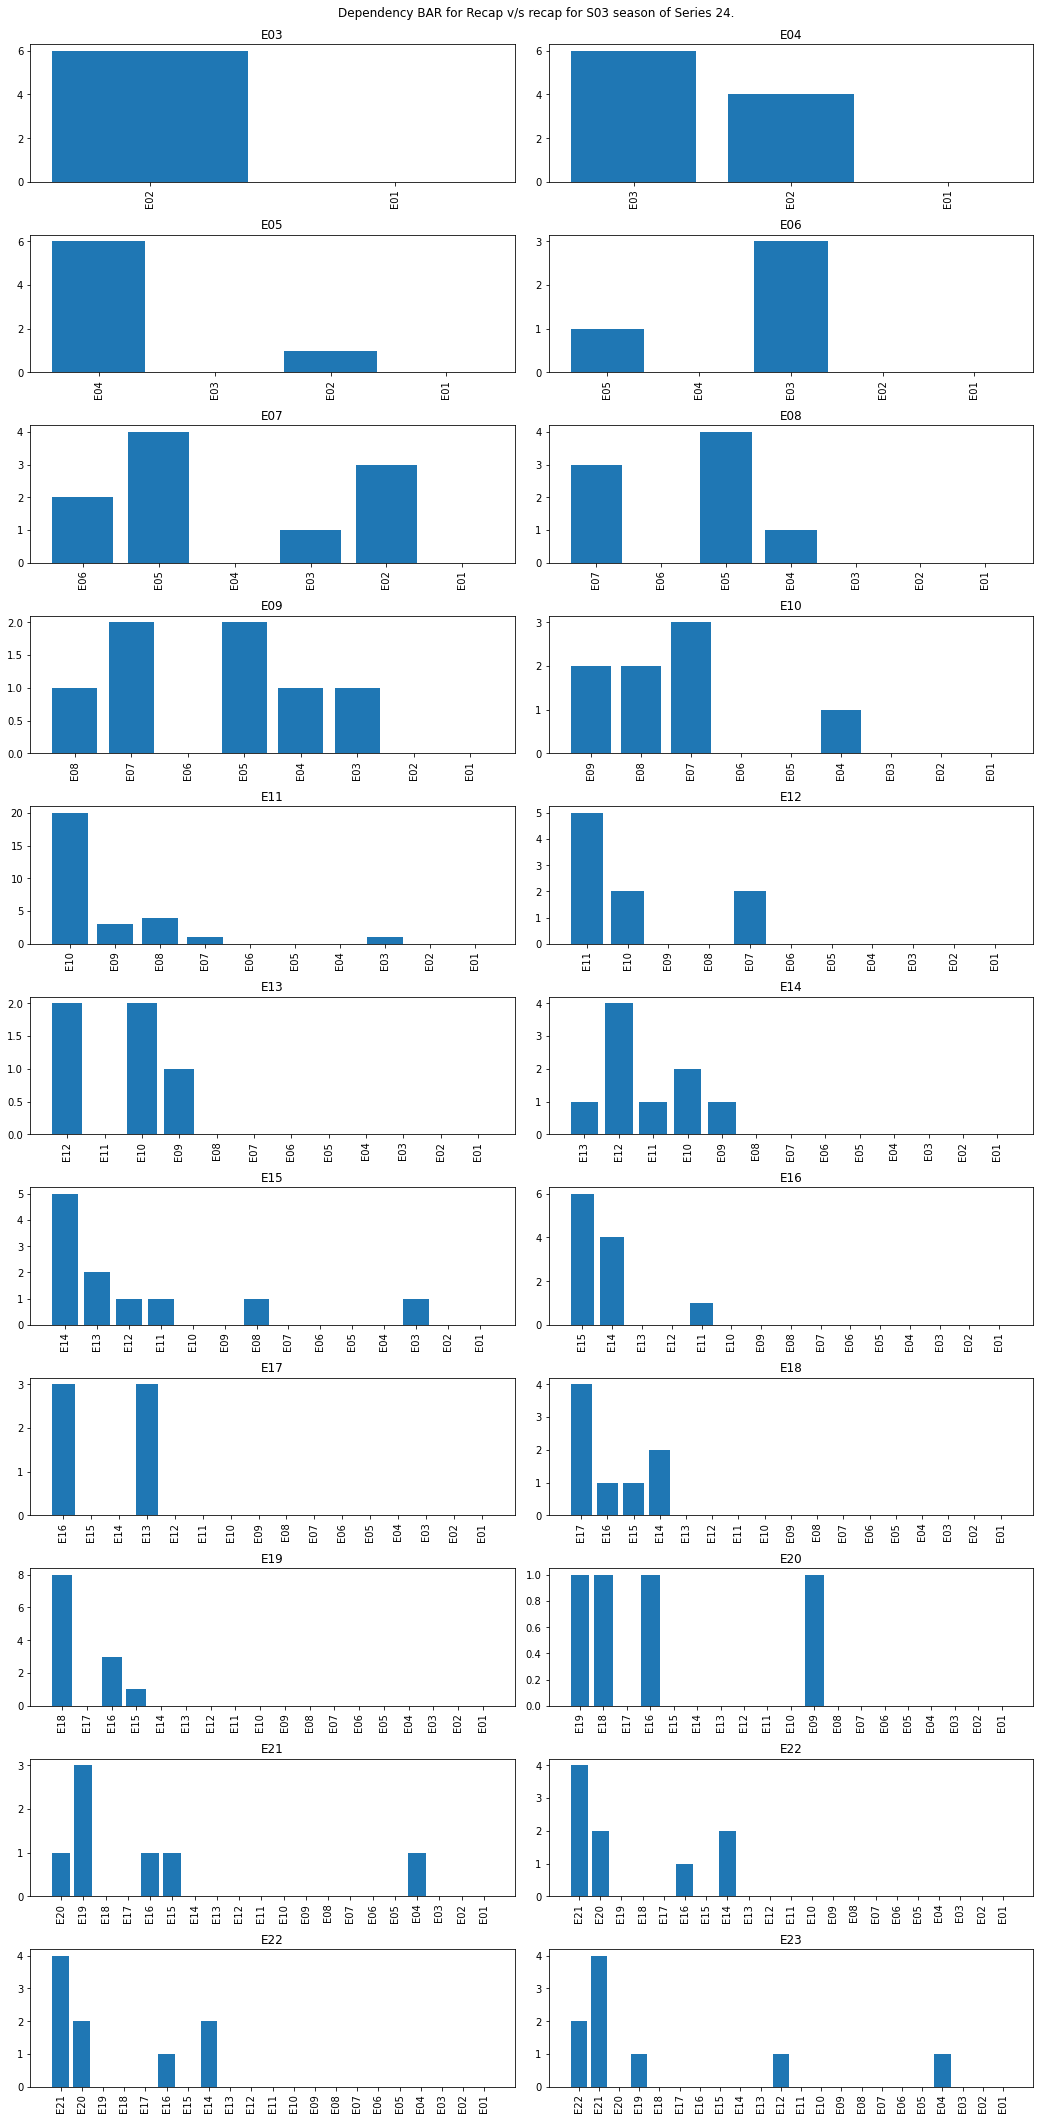

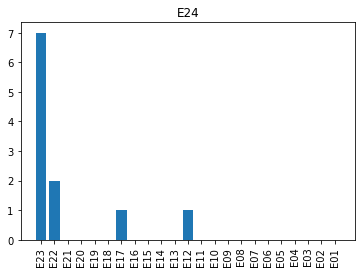

In [21]:
plot_bar(eps_names[1:], vid_part_type="recap")

**Now let's look how many of the shots in $R_n$ coming from $E_{n-2}, \ldots, E_1$ are actually in $R_{n-1}$**  

In [7]:
season='S03'
# For existence of R_(n-1) we should start from E03
df_dict = {'Current Episode Name v/s Previous Episode Name':[],
           'No. of shots in the current RECAP':[],
           'No. of extractive shots from Previous Episode to First Episode':[],
           'No. of extractive shots from Previous to Previous Episode to First Episode':[],
           'No. of abstractive (or remodified) shots in the current RECAP (& hence ignored)': [],
           'No. of shots common in current and previous RECAP (Denom = Current - Ignored)': [],
           'No. of shots in the previous RECAP':[]}
for ep_name in eps_names[1:]:
    shots_cnt, cnt_2to1, cnt_1to1, common_shots = compareRwE(ep_name)
    prev_ep = season+"E{0:02n}".format(int(ep_name[-2:])-1)
    prev_prev_ep = season+"E{0:02n}".format(int(ep_name[-2:])-2)
    df_dict['Current Episode Name v/s Previous Episode Name'].append(f"{ep_name} v/s {prev_ep}")
    df_dict['No. of shots in the current RECAP'].append(shots_cnt[0])
    df_dict['No. of extractive shots from Previous Episode to First Episode'].append(
        f"{cnt_1to1}/{shots_cnt[0]}")
    df_dict['No. of extractive shots from Previous to Previous Episode to First Episode'].append(
        f"{cnt_2to1}/{shots_cnt[0]}")
    df_dict['No. of abstractive (or remodified) shots in the current RECAP (& hence ignored)'].append(
        f"{shots_cnt[0] - cnt_1to1}/{shots_cnt[0]}")
    df_dict['No. of shots common in current and previous RECAP (Denom = Current - Ignored)'].append(
        f"{sum(list(common_shots.values()))}/{cnt_1to1}")
    df_dict['No. of shots in the previous RECAP'].append(shots_cnt[1])

df = pd.DataFrame.from_dict(df_dict)
# df.to_csv("dependency_bar.csv")
df

Current Episode Name v/s Previous Episode Name  \
0                                  E03 v/s S03E02   
1                                  E04 v/s S03E03   
2                                  E05 v/s S03E04   
3                                  E06 v/s S03E05   
4                                  E07 v/s S03E06   
5                                  E08 v/s S03E07   
6                                  E09 v/s S03E08   
7                                  E10 v/s S03E09   
8                                  E11 v/s S03E10   
9                                  E12 v/s S03E11   
10                                 E13 v/s S03E12   
11                                 E14 v/s S03E13   
12                                 E15 v/s S03E14   
13                                 E16 v/s S03E15   
14                                 E17 v/s S03E16   
15                                 E18 v/s S03E17   
16                                 E19 v/s S03E18   
17                                 E20 v/s S03E19   
18                                 E21 v/s S03E20   
19                                 E22 v/s S03E21   
20                                 E23 v/s S03E22   
21                                 E24 v/s S03E23   

    No. of shots in the current RECAP  \
0                                  44   
1                                  52   
2                                  52   
3                                  45   
4                                  43   
5                                  48   
6                                  41   
7                                  46   
8                                  55   
9                                  49   
10                                 56   
11                                 34   
12                                 52   
13                                 36   
14                                 40   
15                                 56   
16                                 33   
17                                 41   
18                                 46   
19                                 39   
20                                 42   
21                                 55   

   No. of extractive shots from Previous Episode to First Episode  \
0                                               39/44               
1                                               44/52               
2                                               45/52               
3                                               41/45               
4                                               42/43               
5                                               44/48               
6                                               39/41               
7                                               43/46               
8                                               55/55               
9                                               47/49               
10                                              53/56               
11                                              33/34               
12                                              52/52               
13                                              34/36               
14                                              37/40               
15                                              51/56               
16                                              33/33               
17                                              34/41               
18                                              45/46               
19                                              38/39               
20                                              40/42               
21                                              54/55               

   No. of extractive shots from Previous to Previous Episode to First Episode  \
0                                                2/44                           
1                                                0/52                           
2       

In [11]:
# Extract such stats in accumulated for all episode
series_name = '24'
seasons = ['S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09']
total_episodes = [24, 24, 24, 24, 24, 24, 24, 12]
stats = {'percent_from_121':[], 'percent_from_221':[], 'percent_from_prev':[], 'num_abs':[]}
for season, eps_cnt in zip(seasons, total_episodes):
    for k in range(3, eps_cnt+1):
        ep = "E%02d" % k
        shots_cnt, cnt_2to1, cnt_1to1, common_shots = compareRwE(ep)
        stats['percent_from_121'].append(cnt_1to1*100/shots_cnt[0])
        stats['percent_from_221'].append(cnt_2to1*100/shots_cnt[0])
        stats['percent_from_prev'].append((cnt_1to1 - cnt_2to1)*100/shots_cnt[0])
        stats['num_abs'].append((shots_cnt[0] - cnt_1to1)*100/shots_cnt[0])        

# Avg stats
print(f"Avg no. of extractive shots from Previous to First Episode = {np.mean(stats['percent_from_121'])}+-{np.std(stats['percent_from_121'])}")
print(f"Avg no. of extractive shots from Previous-1 to First Episode = {np.mean(stats['percent_from_221'])}+-{np.std(stats['percent_from_221'])}")
print(f"Avg no. of extractive shots from Previous-1 Episode = {np.mean(stats['percent_from_prev'])}+-{np.std(stats['percent_from_prev'])}")
print(f"Avg no. of abstractive (or remodified) shots in the current RECAP = {np.mean(stats['num_abs'])}+-{np.std(stats['num_abs'])}")

Avg no. of extractive shots from Previous to First Episode = 93.8254381112842+-4.781348551749055
Avg no. of extractive shots from Previous-1 to First Episode = 5.444872610215776+-11.926230339249722
Avg no. of extractive shots from Previous-1 Episode = 88.38056550106843+-11.441939534552114
Avg no. of abstractive (or remodified) shots in the current RECAP = 6.174561888715793+-4.781348551749054


### Data ANALYSIS for PRiSON-BREAK

In [27]:
pb_eps_names = ["E02", "E03", "E04", "E05", "E06",
             "E07", "E08", "E09", "E10", "E11",
             "E12", "E13", "E14", "E15", "E16",
             "E17", "E18", "E19", "E20", "E21",
             "E22", "E22"]


y = [24]
y = [27, 1]
y = [24, 13, 2]
y = [4, 23, 4, 5]
y = [42, 0, 0, 2, 0]
y = [40, 0, 0, 0, 0, 0]
y = [42, 0, 5, 8, 0, 0, 0]
y = [23, 13, 0, 0, 0, 7, 0, 0]
y = [52, 8, 0, 0, 3, 0, 0, 0, 0]
y = [36, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [36, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]
y = [35, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [34, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
y = [30, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 1, 0, 0]
y = [41, 12, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [10, 5, 1, 5, 3, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0]
y = [25, 0, 0, 0, 0, 4, 19, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0]
y = [52, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [28, 4, 5, 0, 0, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [49, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


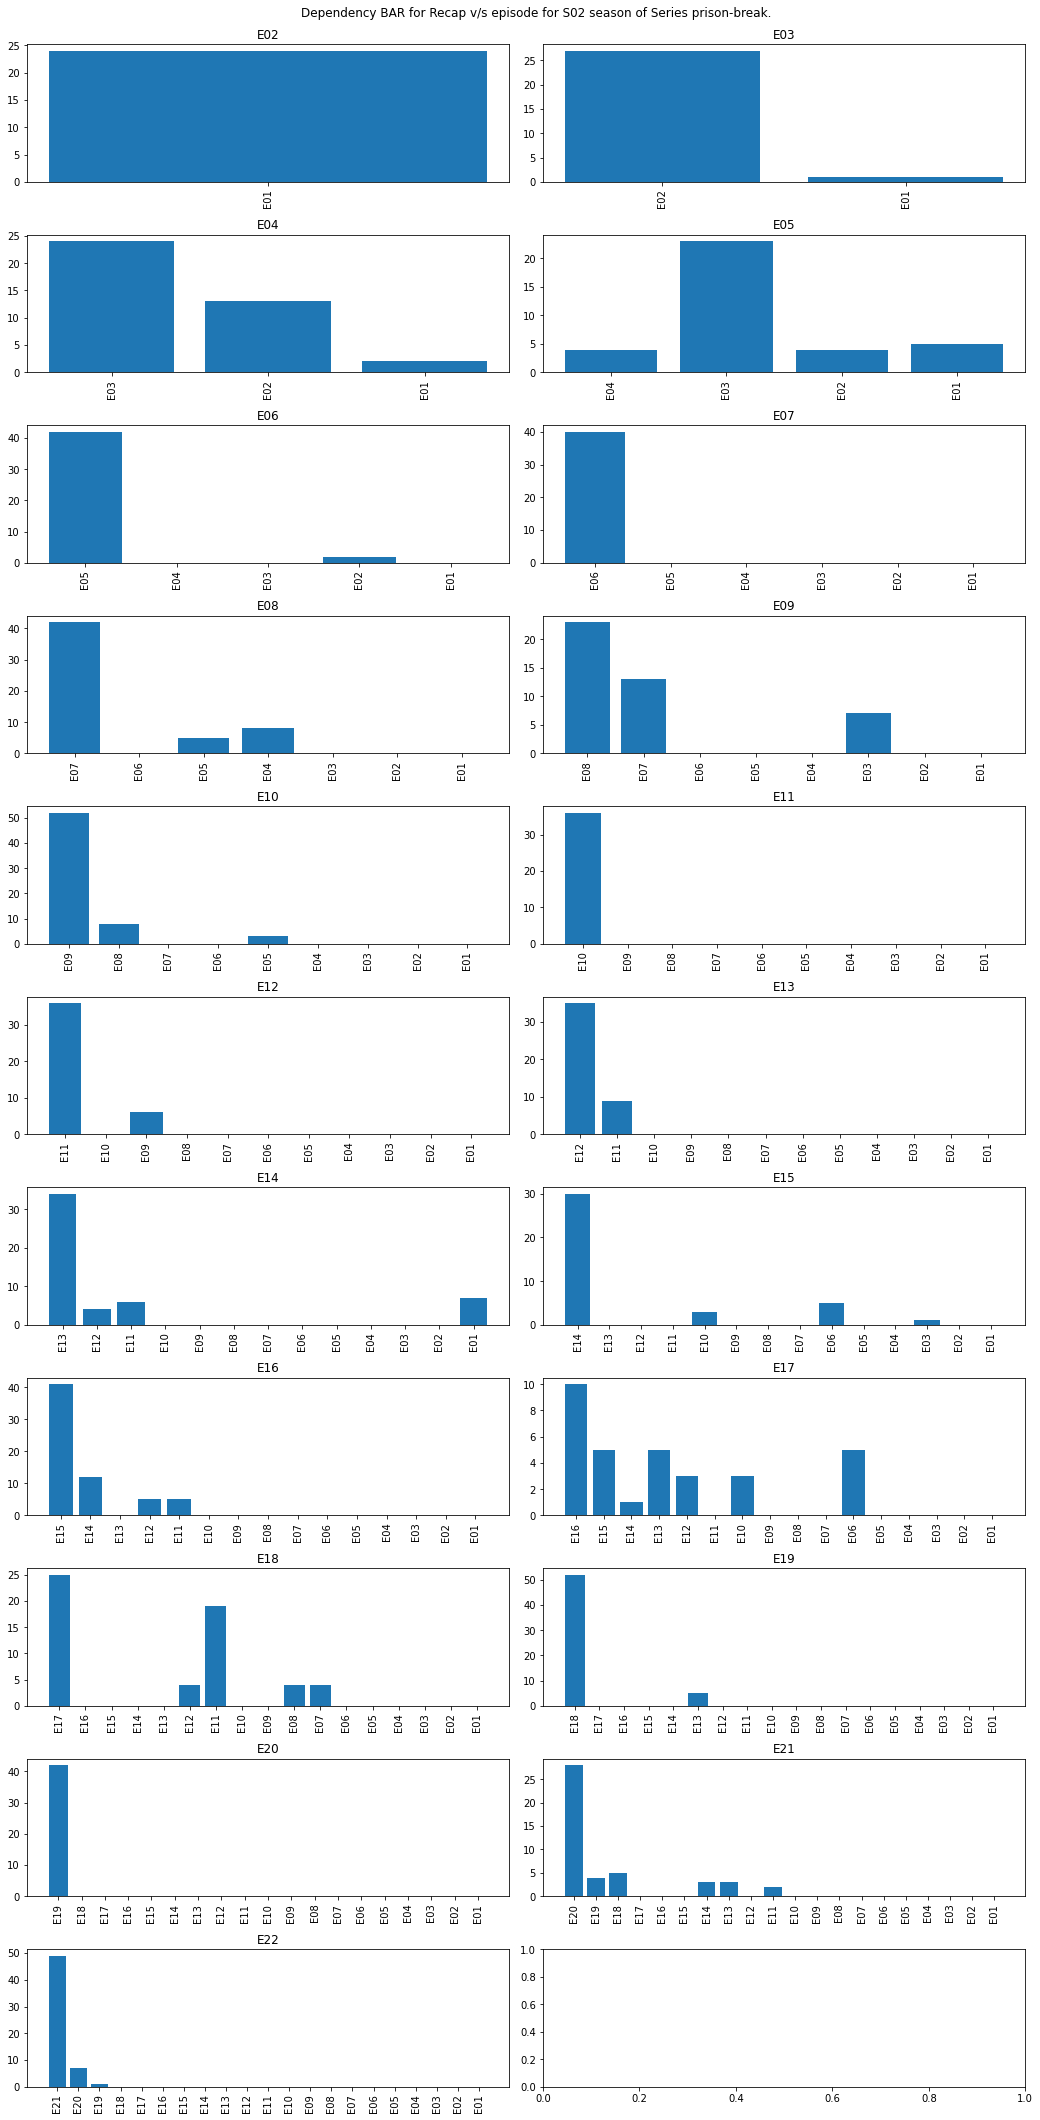

In [28]:
plot_bar(pb_eps_names, series='prison-break', season='S02')

y = [0, 0]
y = [0, 0, 0]
y = [6, 3, 0, 0]
y = [0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0]
y = [0, 0, 1, 0, 0, 1, 0]
y = [7, 2, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0]
y = [0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
y = [9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
y = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [4, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


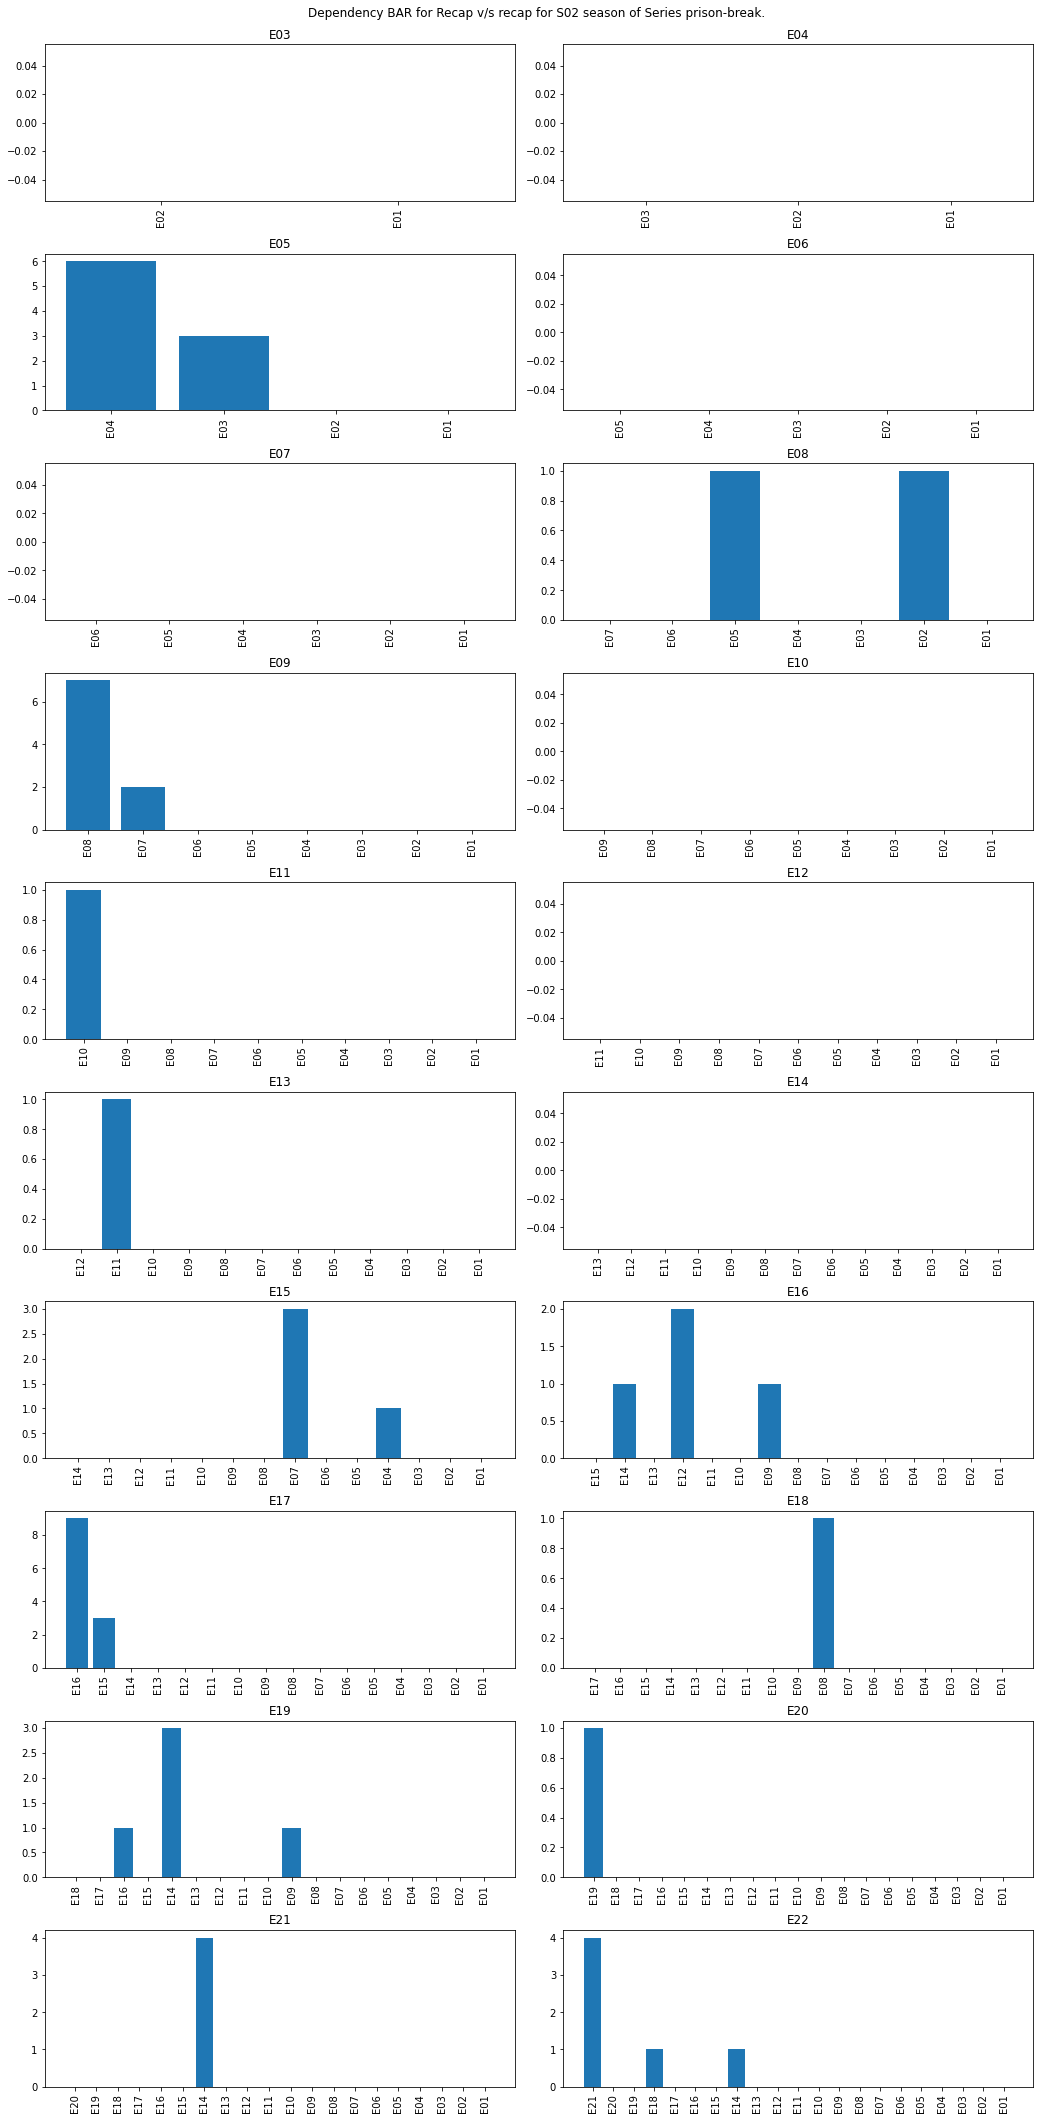

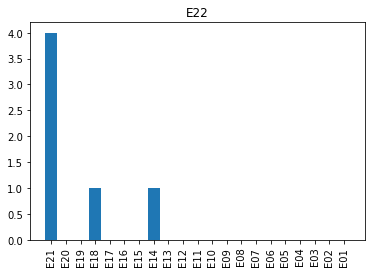

In [30]:
plot_bar(pb_eps_names[1:], vid_part_type="recap", series='prison-break', season='S02')

**Now let's look how many of the shots in $R_n$ coming from $E_{n-2}, \ldots, E_1$ are actually in $R_{n-1}$**  

In [31]:
# For existence of R_(n-1) we should start from E03
df_dict = {'Current Episode Name v/s Previous Episode Name':[],
           'No. of shots in the current RECAP':[],
           'No. of extractive shots from Previous Episode to First Episode':[],
           'No. of extractive shots from Previous to Previous Episode to First Episode':[],
           'No. of abstractive (or remodified) shots in the current RECAP (& hence ignored)': [],
           'No. of shots common in current and previous RECAP (Denom = Current - Ignored)': [],
           'No. of shots in the previous RECAP':[]}
for ep_name in pb_eps_names[1:]:
    shots_cnt, cnt_2to1, cnt_1to1, common_shots = compareRwE(ep_name,
                                                             series_name='prison-break',
                                                             season_name='S02')
    prev_ep = "S03E{0:02n}".format(int(ep_name[-2:])-1)
    prev_prev_ep = "S03E{0:02n}".format(int(ep_name[-2:])-2)
    df_dict['Current Episode Name v/s Previous Episode Name'].append(f"{ep_name} v/s {prev_ep}")
    df_dict['No. of shots in the current RECAP'].append(shots_cnt[0])
    df_dict['No. of extractive shots from Previous Episode to First Episode'].append(
        f"{cnt_1to1}/{shots_cnt[0]}")
    df_dict['No. of extractive shots from Previous to Previous Episode to First Episode'].append(
        f"{cnt_2to1}/{shots_cnt[0]}")
    df_dict['No. of abstractive (or remodified) shots in the current RECAP (& hence ignored)'].append(
        f"{shots_cnt[0] - cnt_1to1}/{shots_cnt[0]}")
    df_dict['No. of shots common in current and previous RECAP (Denom = Current - Ignored)'].append(
        f"{sum(list(common_shots.values()))}/{cnt_1to1}")
    df_dict['No. of shots in the previous RECAP'].append(shots_cnt[1])

df = pd.DataFrame.from_dict(df_dict)
# df.to_csv("dependency_bar.csv")
df

Current Episode Name v/s Previous Episode Name  \
0                                  E03 v/s S03E02   
1                                  E04 v/s S03E03   
2                                  E05 v/s S03E04   
3                                  E06 v/s S03E05   
4                                  E07 v/s S03E06   
5                                  E08 v/s S03E07   
6                                  E09 v/s S03E08   
7                                  E10 v/s S03E09   
8                                  E11 v/s S03E10   
9                                  E12 v/s S03E11   
10                                 E13 v/s S03E12   
11                                 E14 v/s S03E13   
12                                 E15 v/s S03E14   
13                                 E16 v/s S03E15   
14                                 E17 v/s S03E16   
15                                 E18 v/s S03E17   
16                                 E19 v/s S03E18   
17                                 E20 v/s S03E19   
18                                 E21 v/s S03E20   
19                                 E22 v/s S03E21   
20                                 E22 v/s S03E21   

    No. of shots in the current RECAP  \
0                                  65   
1                                  48   
2                                  44   
3                                  53   
4                                  46   
5                                  57   
6                                  50   
7                                  67   
8                                  39   
9                                  46   
10                                 50   
11                                 58   
12                                 42   
13                                 65   
14                                 41   
15                                 58   
16                                 61   
17                                 44   
18                                 46   
19                                 62   
20                                 62   

   No. of extractive shots from Previous Episode to First Episode  \
0                                               28/65               
1                                               39/48               
2                                               36/44               
3                                               44/53               
4                                               40/46               
5                                               55/57               
6                                               43/50               
7                                               63/67               
8                                               36/39               
9                                               42/46               
10                                              44/50               
11                                              51/58               
12                                              39/42               
13                                              63/65               
14                                              32/41               
15                                              56/58               
16                                              57/61               
17                                              42/44               
18                                              45/46               
19                                              57/62               
20                                              57/62               

   No. of extractive shots from Previous to Previous Episode to First Episode  \
0                                                1/65                           
1                                               15/48                           
2                                               32/44                           
3                                                2/53                           
4        

### Blackiness Test

In [4]:
# s03e05_imgs_idx = [(6, 413), (11, 752), (11, 758), (6, 407), (8, 533), (9, 594),
#                    (11, 704), (11, 758), (11, 755), (17, 1004)]
# s03e04_imgs_idx = [(7, 552), (8, 616), (9, 691), (17, 1027), (20, 1131)]
# s03e03_imgs_idx = [(29, 1688)]
# s03e05_blacky_imgs = ["shot_{0:04n}_fn_{1:06n}.jpg".format(i, j) for i, j in s03e05_imgs_idx]
# s03e04_blacky_imgs = ["shot_{0:04n}_fn_{1:06n}.jpg".format(i, j) for i, j in s03e04_imgs_idx]
# s03e03_blacky_imgs = ["shot_{0:04n}_fn_{1:06n}.jpg".format(i, j) for i, j in s03e03_imgs_idx]

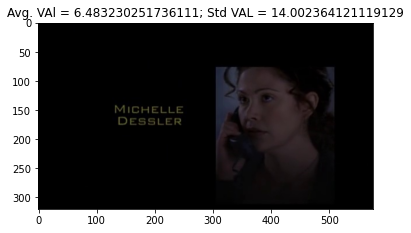

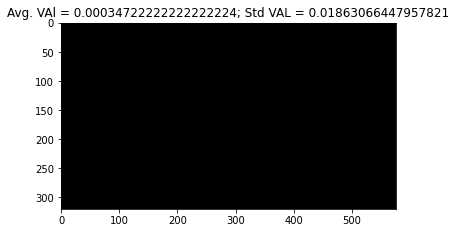

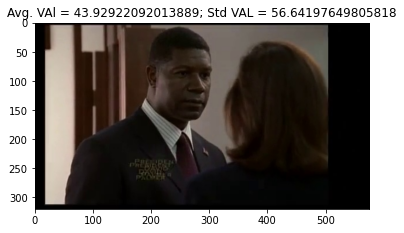

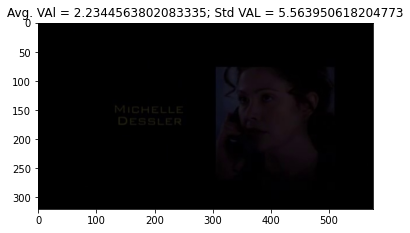

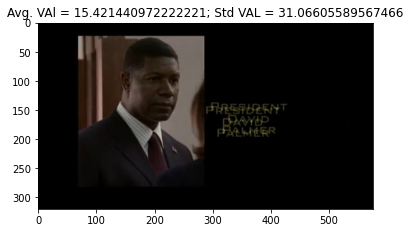

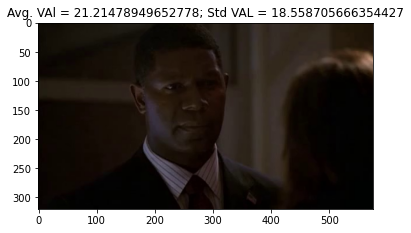

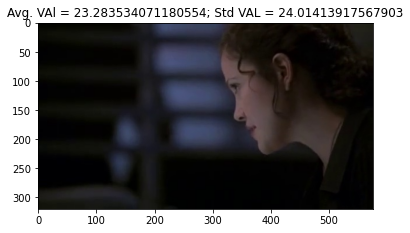

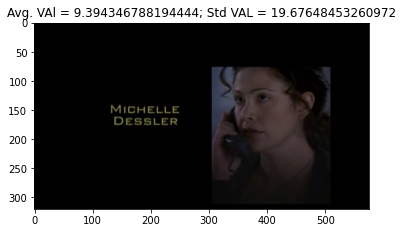

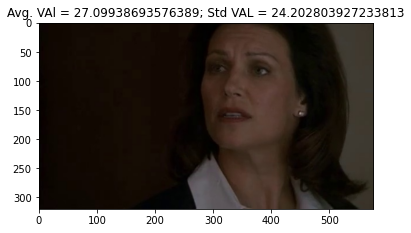

In [6]:
eps = "S03E05"
for img_name in os.listdir(f"black_test_24/{eps}"):
    img = cv2.cvtColor(cv2.imread(f"black_test_24/{eps}/{img_name}"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    avg_val = np.average(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    std_val = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    plt.title(f"Avg. VAl = {avg_val}; Std VAL = {std_val}")
    plt.show()


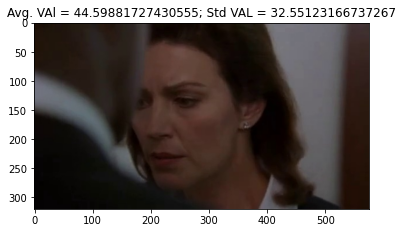

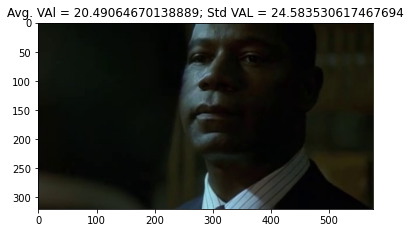

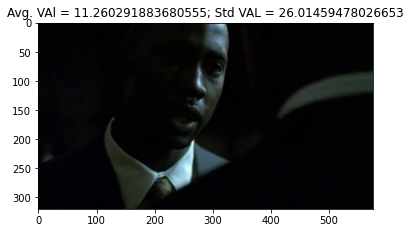

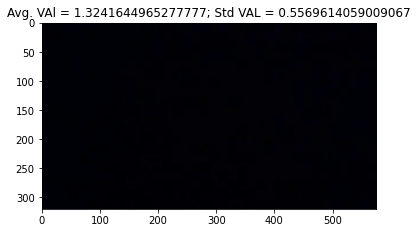

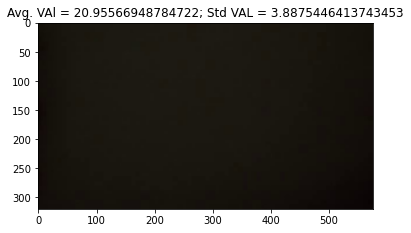

In [7]:
eps = "S03E04"
for img_name in os.listdir(f"black_test_24/{eps}"):
    img = cv2.cvtColor(cv2.imread(f"black_test_24/{eps}/{img_name}"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    avg_val = np.average(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    std_val = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    plt.title(f"Avg. VAl = {avg_val}; Std VAL = {std_val}")
    plt.show()


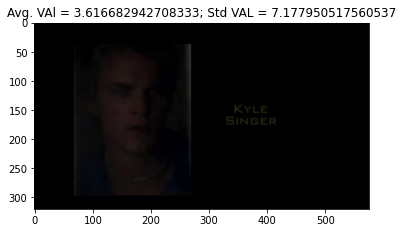

In [8]:
eps = "S03E03"
for img_name in os.listdir(f"black_test_24/{eps}"):
    img = cv2.cvtColor(cv2.imread(
        f"black_test_24/{eps}/{img_name}"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    avg_val = np.average(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    std_val = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    plt.title(f"Avg. VAl = {avg_val}; Std VAL = {std_val}")
    plt.show()


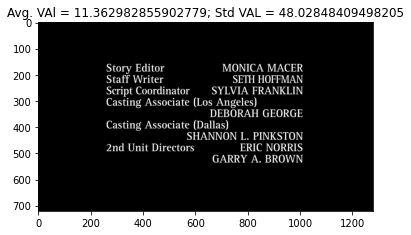

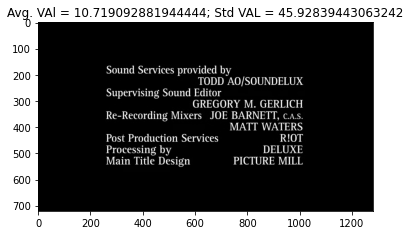

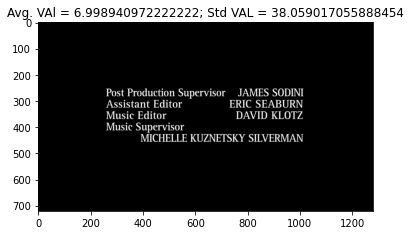

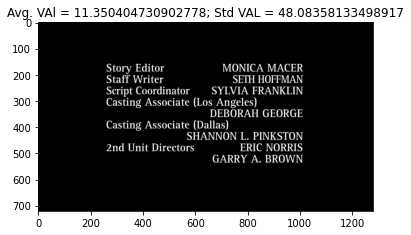

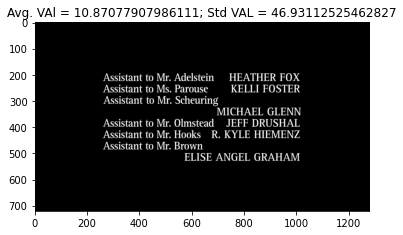

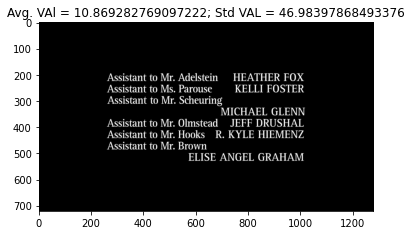

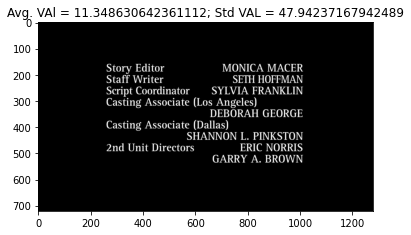

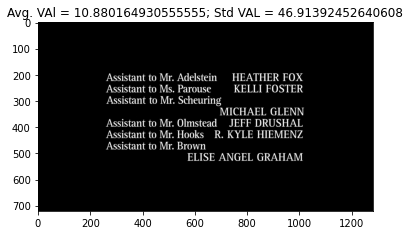

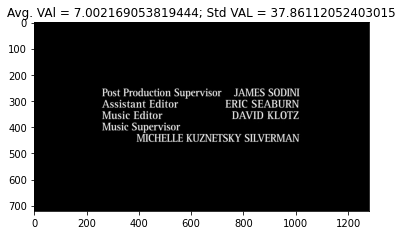

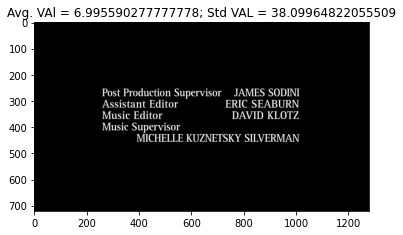

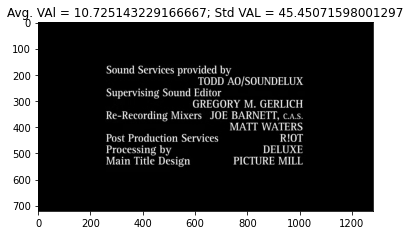

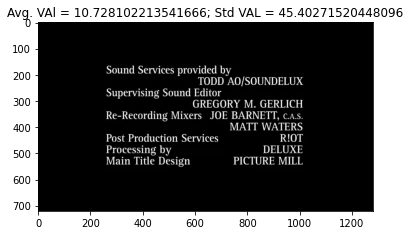

In [2]:
for img_name in os.listdir(f"black_test_pb"):
    img = cv2.cvtColor(cv2.imread(
        f"black_test_pb/{img_name}"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    avg_val = np.average(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    std_val = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    plt.title(f"Avg. VAl = {avg_val}; Std VAL = {std_val}")
    plt.show()


In [8]:
def blackwhite_test(image: np.ndarray,
                    black_thresh: float=8,
                    white_thresh: float=180
                    ) -> bool:
    """
        Checks white/black tone in image. If excess (`> thresh`)
        then `return True else False`.
        --------------------------------------------------------
        Args:
            - image: 3-D Numpy array of image (expects `dtype=uint8`).
            - black_thresh: Decision value for blackiness.
            - white_thresh: Decision value for whiteness.
        """
    avg_VAL = np.average(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    std_VAL = np.std(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    return True if (avg_VAL < black_thresh and std_VAL < black_thresh+4) or\
        (avg_VAL > white_thresh and std_VAL < 255-white_thresh-45) else False


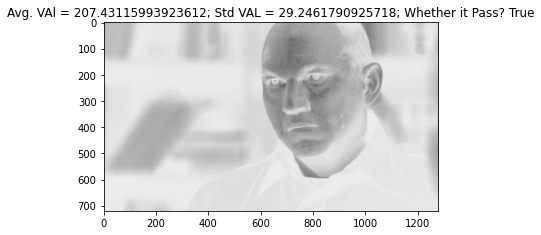

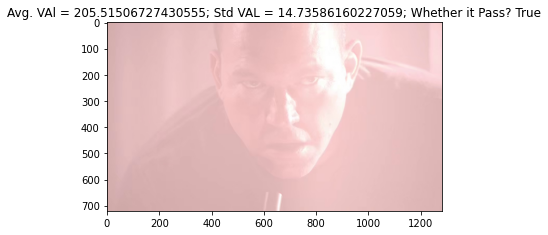

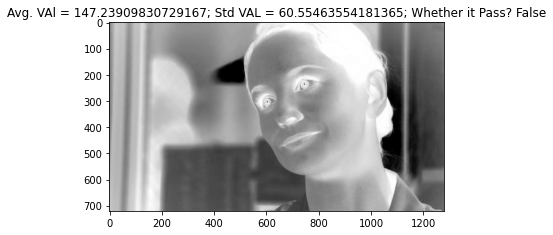

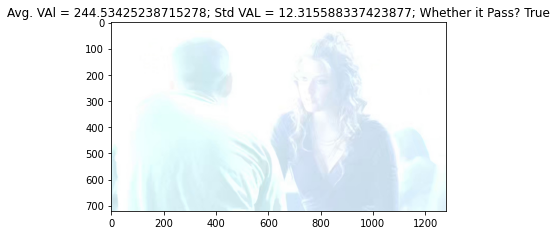

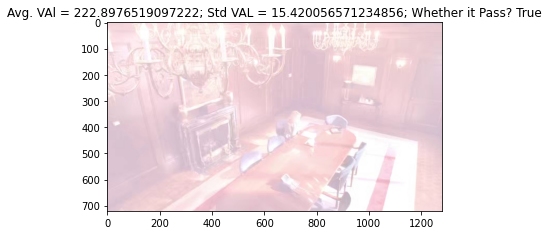

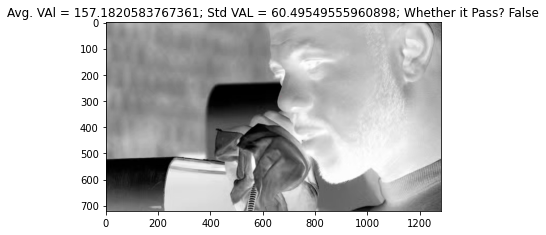

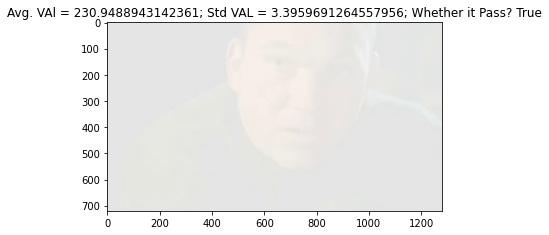

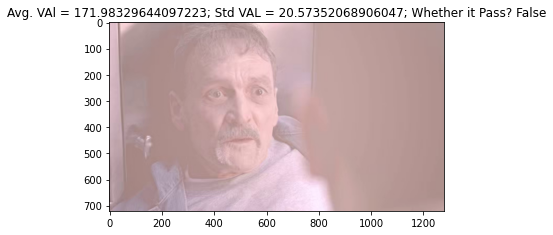

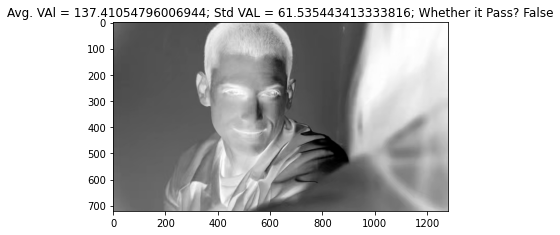

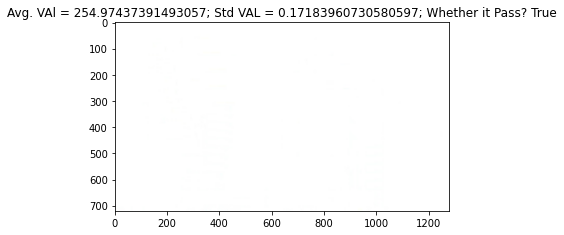

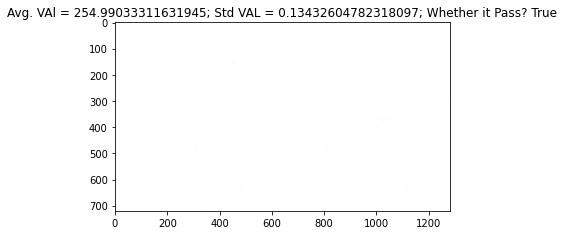

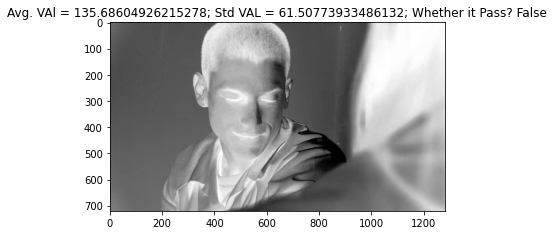

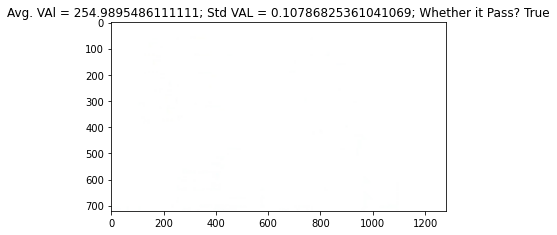

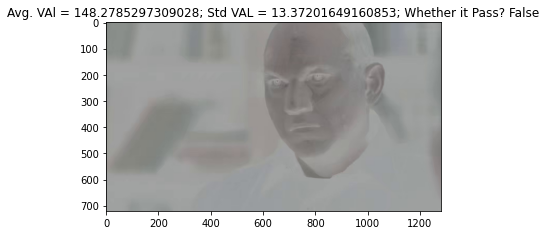

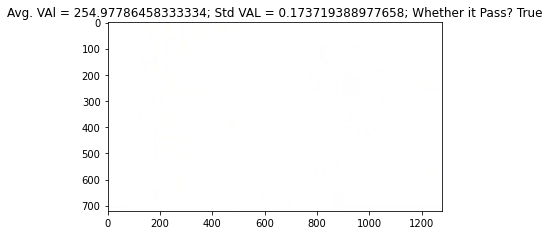

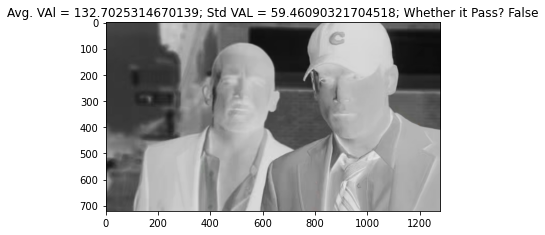

In [9]:
for img_name in os.listdir(f"white_test_pb"):
    img = cv2.cvtColor(cv2.imread(
        f"white_test_pb/{img_name}"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    avg_val = np.average(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    std_val = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    plt.title(f"Avg. VAl = {avg_val}; Std VAL = {std_val}; Whether it Pass? {blackwhite_test(img)}")
    plt.show()
